# <center>Ch2 法律领域私有数据模型蒸馏 </center>

# 背景 

### 1. 大模型的计算与部署瓶颈
- **模型规模爆炸**：随着深度学习的发展，模型参数量急剧增长，导致训练和推理的计算成本极高。
- **硬件资源限制**：大模型对GPU、算力需求极大，难以在边缘设备（如手机、IoT设备）或资源受限场景中部署。
- **推理速度问题**：大模型的推理延迟高，无法满足实时性要求（如自动驾驶、实时翻译等场景）。

### 2. 模型轻量化需求
- **移动端与嵌入式场景**：智能终端设备（手机、传感器等）需要轻量级模型以降低功耗和存储占用。
- **商业化落地需求**：企业需要低成本、高效率的模型部署方案，大模型的运维成本过高。



### 3. 学术界与工业界的协同推动
- **大模型研究的兴起**：BERT、GPT等预训练模型的成功，促使研究者探索如何压缩其能力。
- **实际应用场景扩展**：工业界需要将大模型能力下沉到实际产品中，蒸馏成为关键技术之一。



### 4. 数据隐私与训练成本优化
- **减少数据依赖**：蒸馏允许学生模型复用教师模型的知识，降低对原始训练数据的依赖（尤其在敏感数据场景）。
- **降低训练成本**：直接训练大模型需要海量计算资源，而蒸馏小模型的成本显著降低。


# 1.蒸馏概念回顾

### 第一种：响应级蒸馏（Response-based Distillation）

这种方式与SFT相似：

- **数据形式**：教师模型生成的问答对（文本对）
- **训练方式**：学生模型直接学习生成这些文本
- **损失函数**：通常是交叉熵损失
- **优点**：实现简单，易于部署
- **缺点**：丢失了教师模型的不确定性信息

这种方法有时被称为"弱蒸馏"或"伪蒸馏"，因为它只传递了最终答案，而非教师模型的思考过程。



### 第二种：分布级蒸馏（Distribution-based Distillation）

这是更完整、更传统意义上的蒸馏：

- **数据形式**：教师模型的输出概率分布（logits或token概率）
- **训练方式**：学生模型学习模仿整个分布，而非仅有最终输出
- **损失函数**：KL散度、MSE等测量分布差异的损失
- **优点**：传递更丰富的知识，包括教师模型的"不确定性"
- **缺点**：实现更复杂，需要保存更多数据



### 还有第三种：特征级蒸馏（Feature-based Distillation）


- **数据形式**：教师模型的中间层激活值、注意力分布等
- **训练方式**：学生模型尝试匹配这些内部表示
- **损失函数**：特征匹配损失、注意力匹配损失等
- **优点**：传递更深层次的知识，更好的泛化能力
- **缺点**：通常需要模型架构上的兼容性，实现复杂度高

### 实际应用中的组合使用

在真实应用中，这些方法常常被组合使用：

```json
总损失 = α·响应损失 + β·分布损失 + γ·特征损失
```

其中α、β、γ是权重系数，根据具体任务调整。

### 具体示例说明

假设有问题"今天天气怎么样？"：

1. **响应级蒸馏**：学生只学习生成"今天是晴天"这个答案文本
2. **分布级蒸馏**：学生学习教师的token概率，例如"晴天"73%，"多云"20%，"下雨"7%
3. **特征级蒸馏**：学生还学习教师处理这个问题时内部注意力如何分配，哪些特征被激活等


# 2.蒸馏流程

<div align=center><img src="https://typora-photo1220.oss-cn-beijing.aliyuncs.com/DataAnalysis/muyan/image-20250512221519078.png" width=100%></div>

蒸馏过程就是学生模型像教师模型学习数据产生的过程 。

## 2.1 综合蒸馏

<div align=center><img src="https://typora-photo1220.oss-cn-beijing.aliyuncs.com/DataAnalysis/muyan/image-20250512221557906.png" width=100%></div>


### 1. 仅使用问题（只有输入）

**适用场景:**
- 教师模型在目标领域已经非常强大，几乎不需要参考标准答案
- 目标是让学生模型完全模仿教师模型的行为，包括其缺陷
- 数据集中没有高质量的标准答案
- 任务是开放性的，没有唯一正确答案

**好处:**
- 最简化的数据准备流程，减少数据处理复杂度
- 避免了标准答案可能带来的限制，保留教师模型的创造性
- 数据获取成本低，不需要人工标注答案
- 训练过程简单直接，学生完全学习教师的输出

**坏处:**
- 完全继承教师模型的错误和偏见，无法修正
- 如果教师模型在目标领域能力不足，学生模型将同样受限
- 无法利用已有的高质量标准答案提升性能
- 难以针对特定领域进行定向优化
- 无法确保输出的专业准确性，特别是在法律、医疗等严格领域



### 2. 输入+输出全量使用

**适用场景:**
- 教师模型需要看到完整问答对来生成更好的内部表示
- 任务涉及复杂的上下文理解，需要答案来完善理解
- 教师模型在领域知识上有所欠缺，需要借助标准答案引导
- 希望保留教师模型的通用能力同时提升特定领域能力

**好处:**
- 教师模型能生成更高质量的特征表示和概率分布
- 可以捕获问题和答案之间的关系模式
- 增强教师模型对专业领域的理解
- 在不直接使用标准答案监督的情况下仍能提高输出质量

**坏处:**
- 输入序列变长，增加计算资源消耗
- 可能导致注意力分散，模型关注非关键信息
- 数据处理复杂度增加，需要完整的问答对
- 如果标准答案质量不高，可能引入噪声
- 间接学习方式效率可能低于直接监督



### 3. 使用问题进行约束

**适用场景:**
- 需要限制模型输出在特定范围内
- 任务有明确的输入限制和期望输出格式
- 希望模型专注于特定类型的问题
- 应用于需要高度一致性回答的场景

**好处:**
- 提高模型在特定任务上的精确性
- 减少不相关回答的可能性
- 使最终模型更加专注于目标领域
- 提高推理效率，避免不必要的计算

**坏处:**
- 可能限制模型的创造性和灵活性
- 过度约束可能导致过拟合特定问题模式
- 难以处理边缘情况和未见过的问题类型
- 实施复杂，需要设计适当的约束机制
- 可能降低模型对开放性问题的处理能力


### 4. 引入混合损失评估

**适用场景:**
- 教师模型与标准答案质量差异明显
- 有高质量的标准答案可供参考
- 需要平衡教师模型知识和标准答案指导
- 针对需要高精度回答的专业领域(法律、医疗等)

**好处:**
- 同时从教师模型和标准答案中获取知识
- 减少教师模型可能的错误传播
- 提高学生模型在特定领域的准确性
- 保留教师模型的推理能力同时确保输出质量

**坏处:**
- 实现技术复杂，需要设计多种损失函数
- 超参数调整难度高，不同损失的权重敏感
- 计算开销大，需要同时计算多个损失项
- 可能导致训练不稳定，不同目标相互冲突
- 需要高质量的标准答案，否则可能引入额外噪声


## 2.2 分步蒸馏

<div align=center><img src="https://typora-photo1220.oss-cn-beijing.aliyuncs.com/DataAnalysis/muyan/image-20250512221539051.png" width=100%></div>

### 基本流程

1. **教师模型微调阶段**:
   - 选择合适的预训练大模型作为基础教师模型
   - 准备领域专业数据集，包含高质量的问答对
   - 使用SFT(监督微调)技术对教师模型进行领域适应
   - 可选择全参数微调或参数高效微调(如LoRA、QLoRA等)
   - 评估微调后的教师模型在目标领域的表现

2. **知识蒸馏阶段**:
   - 准备蒸馏数据集(可以与微调数据集相同或不同)
   - 设计蒸馏损失函数(响应级、分布级、特征级)
   - 学生模型学习微调后教师模型的输出和内部表示
   - 进行蒸馏训练，可能包含多种损失组合
   - 评估和优化学生模型性能


### 适用场景

这种"先微调后蒸馏"的方法特别适合以下场景:

1. **专业领域应用**:
   - 法律、医疗、金融等需要高度专业知识的领域
   - 科学研究、工程技术等专业术语丰富的领域
   - 特定行业客服、咨询系统等垂直应用

2. **原始教师模型领域能力不足**:
   - 通用大模型对特定领域知识覆盖不足
   - 模型需要学习特定行业术语和表达方式
   - 需要纠正模型在特定领域的错误认知

3. **有高质量领域数据可用**:
   - 拥有大量标注良好的领域专业数据
   - 有专家可以验证和改进训练数据质量
   - 有明确的领域知识体系和标准

4. **资源允许两阶段训练**:
   - 有足够的计算资源支持大模型微调
   - 有充足的时间完成完整的训练流程
   - 对最终模型质量要求高，愿意投入更多资源



## 优点

1. **显著提升领域能力**:
   - 微调使教师模型获得深度的专业领域知识
   - 蒸馏能有效传递这些专业知识到小模型
   - 最终学生模型在目标领域表现优于直接蒸馏

2. **避免错误知识传递**:
   - 微调过程可以纠正原始大模型的领域错误
   - 学生模型学习的是已经"净化"的知识
   - 减少原始模型偏见和错误的传播

3. **更高的知识传递效率**:
   - 教师模型具备更精准的领域表示能力
   - 蒸馏过程中的知识传递更加聚焦和高效
   - 学生模型可以用更少的参数捕获关键知识

4. **定制化能力强**:
   - 可以针对特定应用场景定制模型能力
   - 灵活调整微调和蒸馏侧重点
   - 更容易满足特定业务需求

5. **可控性与可解释性更强**:
   - 两阶段过程提供更多检查点和调整机会
   - 可以分析微调效果，针对性改进
   - 蒸馏过程更透明，容易识别问题



## 缺点

1. **资源消耗大**:
   - 需要两阶段训练，计算资源需求高
   - 大模型微调通常需要多GPU/TPU设备
   - 整体训练时间长，开发周期延长

2. **数据需求高**:
   - 需要高质量的领域专业数据
   - 数据准备和清洗成本高
   - 可能需要领域专家参与数据评估

3. **过度专精风险**:
   - 微调可能导致教师模型过度专注于特定领域
   - 可能丧失部分通用能力和创造性
   - 学生模型可能继承这种过度专精倾向

4. **调参复杂度高**:
   - 微调和蒸馏各有一套超参数需要调整
   - 两个过程的最优参数可能互相影响
   - 需要更多实验来找到最佳配置

5. **错误累积可能**:
   - 如果微调方向有误，蒸馏会放大这些错误
   - 两阶段都可能引入新的错误
   - 调试更复杂，错误来源难以定位

## 2.3 蒸馏层级详解

### 1. 分词与词嵌入层 (Tokenization & Embedding Layer)

**官方名称**：Embedding Layer

**形象比喻**：**"翻译官"** - 将人类语言翻译成机器理解的数字向量

**详细描述**：
- **输入**：原始文本 "人工智能正在改变世界"
- **处理**：
  - 文本被分词器切分为token IDs: [101, 3209, 1744, 7305, 4638, 720, 1767, 1399, 782, 102]
  - 每个ID通过查表操作映射为固定维度的向量
- **输出**：嵌入矩阵 [seq_len, embedding_dim]，例如 [10, 768]
- **数据变化**：从离散token转为连续向量表示，编码了词汇语义信息

**形象解释**：
- 词嵌入层就像一本巨大的"词典"，包含5万多个单词(词表大小)
- 每个单词在这本词典中都有一个768维的"定义"(或"身份证")
- 当"人工智能"这个短语进入模型时，分词器先把它切成适合查词典的单位
- 然后查词典，将每个单位转换成768维的向量，就像把文字翻译成了"数学语言"

**蒸馏相关性**：
- 在特征级蒸馏中很少直接使用，因为这是基础输入层
- 有时学生模型和教师模型使用不同的词表，需要特殊处理



### 2. 位置编码层 (Positional Encoding Layer)

**官方名称**：Positional Encoding Layer

**形象比喻**：**"地址标签员"** - 给每个词贴上位置标签

**详细描述**：
- **输入**：嵌入向量 [batch_size, seq_len, 768]
- **处理**：
  - 生成位置编码(可以是预先计算的正弦/余弦函数，或可学习的参数)
  - 将位置编码与词嵌入向量相加
- **输出**：位置编码后的嵌入向量 [batch_size, seq_len, 768]
- **数据变化**：向量中融入了位置信息，使模型能识别词序

**形象解释**：
- 没有位置信息，模型只知道句子中有哪些词，但不知道它们的顺序
- 位置编码像是给每个词加上了邮政编码："第1位的词"、"第2位的词"
- 这种"标记"融入了每个词的768维向量，而不是单独保存
- 就像在每个词的"身份证"上额外盖了一个表明其位置的章

**蒸馏相关性**：
- 类似嵌入层，很少在蒸馏中直接对位置编码进行操作
- 但它会影响后续所有层的表示，间接影响特征级蒸馏



### 3. Transformer编码层 (Transformer Encoder Layers)

#### 3.1 自注意力子层 (Self-Attention Sublayer)

**官方名称**：Multi-Head Self-Attention Layer

**形象比喻**：**"上下文关联器"** - 让每个词"看到"并关联其他相关词

**详细描述**：
- **输入**：上一层输出 [batch_size, seq_len, 768]
- **处理**：
  - 生成查询(Q)/键(K)/值(V)矩阵：每个都是 [batch_size, seq_len, 768]
  - 计算注意力分数：Q·K^T / sqrt(d_k) → [batch_size, seq_len, seq_len]
  - 应用softmax获得注意力权重
  - 加权汇总：权重与V相乘得到 [batch_size, seq_len, 768]
- **输出**：注意力输出 [batch_size, seq_len, 768]

**形象解释**：
- 自注意力就像"词与词之间开会"，每个词都能发言和倾听
- 在"人工智能正在改变世界"中，"改变"一词会特别关注"世界"，因为它们有强关联
- 多头注意力相当于同时举行8个不同主题的小组讨论，每组关注不同角度
- 注意力权重就像会议中的"发言权重表"，显示谁在跟谁交流及其重要程度

**蒸馏相关性**：
- 属于特征级蒸馏的关键层
- 注意力权重矩阵 [batch_size, num_heads, seq_len, seq_len] 有时单独作为蒸馏目标
- 如：让学生模型学习教师模型在"改变"和"世界"之间建立的强关联模式



#### 3.2 前馈网络子层 (Feed-Forward Network Sublayer)

**官方名称**：Position-wise Feed-Forward Network (FFN)

**形象比喻**：**"信息加工站"** - 深入处理每个位置的信息

**详细描述**：
- **输入**：注意力层输出 [batch_size, seq_len, 768]
- **处理**：
  - 第一个线性变换：768 → 3072维 (扩展)
  - 激活函数(GELU)添加非线性
  - 第二个线性变换：3072 → 768维 (压缩回原维度)
- **输出**：FFN输出 [batch_size, seq_len, 768]

**形象解释**：
- 如果注意力层是"开会收集信息"，前馈网络就是"独自思考消化信息"
- 先将信息展开(768→3072)，像是把笔记本展开成大海报，有更多空间思考
- 通过激活函数处理，就像用荧光笔标记重点，增加思考深度
- 再将信息压缩回原尺寸(3072→768)，把思考结果整理成简洁笔记

**蒸馏相关性**：
- 属于特征级蒸馏目标
- FFN输出通常作为整个Transformer层输出的一部分被蒸馏
- 教师模型FFN输出可能是4096维，学生模型是2048维，需要特征映射



#### 3.3 残差连接与层归一化 (Residual Connection & Layer Normalization)

**官方名称**：Residual Connection & Layer Normalization

**形象比喻**：**"信息保鲜器"** - 确保重要信息不会在传递中丢失

**详细描述**：
- **输入**：原始输入X和子层输出SubLayer(X)
- **处理**：
  - 残差连接：X + SubLayer(X)
  - 层归一化：统计均值和方差，进行归一化处理
- **输出**：标准化的Transformer层输出 [batch_size, seq_len, 768]

**形象解释**：
- 残差连接像是"备份通道"，确保原始信息不会完全丢失
- 就像一边听新课(子层输出)，一边保留旧笔记(原始输入)
- 层归一化像是"统一格式"，将大小不一的数值调整到相似范围
- 这就像把不同颜色深浅的照片调整到标准亮度，便于后续处理

**蒸馏相关性**：
- 层归一化后的输出是特征级蒸馏的重要目标
- 这些输出就是通常所说的"隐藏状态"(hidden states)
- 具有稳定的统计特性，便于跨模型传递知识



### 4. LM Head层 (Language Model Head)

**官方名称**：LM Head / Output Layer

**形象比喻**：**"词汇预测器"** - 将机器理解转换回人类语言的可能性

**详细描述**：
- **输入**：最终Transformer层输出 [batch_size, seq_len, 768]
- **处理**：线性变换将隐藏表示映射到词表大小
- **输出**：logits [batch_size, seq_len, vocab_size]，例如 [batch_size, seq_len, 50000]

**形象解释**：
- LM Head就像一个"翻译官的反向工作"
- 从768维的"机器理解"转换回50000个可能的词汇
- 如果Transformer层理解了"王后很____"，LM Head会给出所有可能填空词的分数
- "聪明"可能得9.2分，"美丽"得8.7分，"强大"得8.5分...
- 这些原始分数(logits)就像"投票数"，尚未归一化为概率

**蒸馏相关性**：
- 是分布级蒸馏的核心作用层
- logits直接反映模型的预测分布，包含更丰富的知识
- 通过温度参数调整可以控制知识的"软硬程度"



### 5. Softmax层 (Softmax Layer)

**官方名称**：Softmax Layer/函数

**形象比喻**：**"概率分配器"** - 将原始分数转换为概率分布

**详细描述**：
- **输入**：LM Head输出的logits [batch_size, seq_len, vocab_size]
- **处理**：应用softmax函数将logits转换为概率
- **输出**：token概率分布 [batch_size, seq_len, vocab_size]
- **数据变化**：从原始分数(-∞到+∞)转换为概率(0到1，总和为1)

**形象解释**：
- Softmax就像"选举票数转化为席位分配"
- 原始logits可能是：{"改变":12.5, "影响":10.2, "塑造":8.7}
- Softmax后变成：{"改变":0.70, "影响":0.25, "塑造":0.05}
- 这一步使原始"投票分数"变成了标准化的"获胜概率"

**蒸馏相关性**：
- 是分布级蒸馏的后半部分
- 通常会使用温度参数调整概率分布的平滑度
- 高温度(如T=2.0)会产生更平滑的分布，传递更多关于次优选择的信息



### 6. 解码/生成层 (Decoding/Generation Layer)

**官方名称**：Decoder/Generator

**形象比喻**：**"决策者"** - 根据概率分布做出实际选择

**详细描述**：
- **输入**：Softmax层输出的概率分布
- **处理**：
  - 贪婪解码(选择最高概率token)
  - 或beam search(保持多个可能路径)
  - 或采样(按概率随机选择)
- **输出**：选定的token ID序列 [batch_size, seq_len]
- **数据变化**：从概率分布收敛到具体token选择

**形象解释**：
- 解码层就像"最终拍板的决策者"
- 面对{"改变":0.70, "影响":0.25, "塑造":0.05}的概率分布：
  - 贪婪解码会直接选择"改变"(最高概率)
  - 温度采样可能根据概率随机选择，有时会选"影响"
  - beam search会同时考虑多个选择，看后续发展再决定
- 这一步将"可能性分布"转变为"确定性选择"

**蒸馏相关性**：
- 与响应级蒸馏直接相关
- 生成策略(贪婪、beam search或采样)会影响最终文本输出
- 学生模型需要学习教师模型的生成策略和风格



### 7. 文本输出层 (Text Output Layer)

**官方名称**：Tokenizer Decoder/Text Generator

**形象比喻**：**"翻译官的终极任务"** - 将机器内部表示转回人类可读文本

**详细描述**：
- **输入**：解码层输出的token ID序列
- **处理**：将ID序列通过分词器转换回文本
- **输出**：最终生成的自然语言文本
- **数据变化**：从数字ID序列回到原始自然语言

**形象解释**：
- 这就像将"密码"解码回正常人类语言
- 从[3209, 1744, 7305, 4638, 720, 1767, 1399]这样的数字序列
- 变回"人工智能正在改变世界"这样的自然文本
- 是整个"翻译"过程的最后一步，完成从人类→机器→人类的循环

**蒸馏相关性**：
- 是响应级蒸馏的核心比较对象
- 最终文本输出是响应级蒸馏直接比较的目标
- 衡量教师模型和学生模型生成文本的相似度



## 2.4 三种蒸馏方法与层级对应详解

### 1. 特征级蒸馏 (Feature-level Distillation)

**对应层级**：
- 主要作用于**Transformer各编码层的隐藏状态输出**
- 核心是隐藏状态(hidden states)，也就是每个Transformer层的完整输出

**形象比喻**：**"学徒模仿师傅的思考过程"**

**详细描述**：
- **具体层级**：每个Transformer块的输出，通常是层归一化后的结果
- **技术对应**：
```python
  # 教师模型第12层输出
  teacher_layer12 = teacher_outputs.hidden_states[12]  # [batch, seq, 1024]
  # 学生模型第6层输出
  student_layer6 = student_outputs.hidden_states[6]    # [batch, seq, 512]
  # 通过特征映射器对齐维度
  mapped_teacher = feature_mapper(teacher_layer12)     # [batch, seq, 512]
  # 计算损失
  loss = F.mse_loss(student_layer6, mapped_teacher)
 ```

**形象工作过程**：
1. 教师模型("大师")的第12层看到"人工智能正在改变世界"时，产生了一个1024维的"理解笔记"
2. 这个"笔记"包含了"人工智能"如何与"改变世界"关联的深刻理解
3. 学生模型("学徒")的第6层尝试产生类似的理解，但它的"笔记本"只有512维
4. 特征映射器就像一个"笔记压缩工具"，将大师的1024维笔记压缩成512维
5. 学徒努力使自己的笔记与压缩后的大师笔记一致，从而学习大师的思考方式

**具体变化示例**：
- 教师第12层处理"人工智能"：
  - 识别这是科技领域的核心概念
  - 建立与"计算机"、"算法"、"学习"等概念的关联
  - 这些复杂关系编码在1024维向量中
- 通过特征映射压缩到512维：
  - 保留核心语义关联
  - 可能牺牲一些细微关联强度的精确度
- 学生第6层学习这种压缩后的理解模式



### 2. 分布级蒸馏 (Distribution-level Distillation)

**对应层级**：
- 主要作用于**LM Head层输出的logits**
- 具体是每个token位置上的词表预测分数

**形象比喻**：**"学习大师的决策偏好"**

**详细描述**：
- **具体层级**：LM Head输出的原始logits，未经softmax转换
- **技术对应**：
```python
  # 获取两个模型在词表空间的原始预测分数
  teacher_logits = teacher_outputs.logits  # [batch, seq, 50000]
  student_logits = student_outputs.logits  # [batch, seq, 50000]
  
  # 使用温度参数软化分布
  temperature = 2.0
  soft_teacher = F.softmax(teacher_logits / temperature, dim=-1)
  soft_student = F.log_softmax(student_logits / temperature, dim=-1)
  
  # 计算KL散度损失
  kl_loss = F.kl_div(soft_student, soft_teacher, reduction='batchmean') * (temperature**2)
```

**形象工作过程**：
1. 教师模型预测"人工智能将____未来"的下一个词时，给出所有可能词的评分：
   - "改变"：9.2分
   - "影响"：8.7分
   - "塑造"：8.1分
   - "决定"：7.5分
   - ...其他数万个词各有分数
2. 温度参数(T=2.0)使这些分数差异变得更平滑：
   - "改变"：60%
   - "影响"：25%
   - "塑造"：10%
   - "决定"：5%
3. 学生模型学习这种"犹豫模式"，而不仅仅是最高分的词
4. 这就像学徒不仅学习大师最终选择了什么词，还学习大师对各种选择的倾向性

**具体变化示例**：
- 教师模型面对"人工智能将___未来"：
  - LM Head输出50000个分数
  - 最高几个是与"改变/影响/塑造"相关的词
- 使用温度调整后：
  - 原本悬殊的分数差距被平滑
  - 学生模型可以学习到更细微的词汇偏好
- 学生模型不仅学习预测"改变"，还学习何时考虑用"影响"或"塑造"



### 3. 响应级蒸馏 (Response-level Distillation)

**对应层级**：
- 主要作用于**解码/生成层**和**文本输出层**
- 关注从token概率到最终文本的整个生成过程

**形象比喻**：**"学习大师的最终作品风格"**

**详细描述**：
- **具体层级**：从Softmax后的概率分布到最终生成的文本
- **技术对应**：
```python
  # 使用相同的输入进行生成
  input_text = "请解释人工智能的未来"
  input_ids = tokenizer.encode(input_text, return_tensors="pt")
  
  # 教师模型生成
  teacher_outputs = teacher_model.generate(
      input_ids,
      max_length=200,
      num_beams=4,  # 使用beam search
      temperature=0.7  # 控制生成多样性
  )
  teacher_text = tokenizer.decode(teacher_outputs[0])
  
  # 学生模型生成
  student_outputs = student_model.generate(
      input_ids,
      max_length=200,
      num_beams=4,
      temperature=0.7
  )
  student_text = tokenizer.decode(student_outputs[0])
  
  # 计算文本相似度
  from rouge import Rouge
  rouge = Rouge()
  scores = rouge.get_scores(student_text, teacher_text)
  response_loss = 1.0 - scores[0]['rouge-l']['f']  # 使用ROUGE-L作为相似度度量
```

**形象工作过程**：
1. 教师模型和学生模型接收相同的问题："请解释人工智能的未来"
2. 教师模型通过其生成过程产生连贯文本：
   "人工智能技术将深刻改变各行各业，从医疗保健到交通运输..."
3. 学生模型也产生自己的回答：
   "人工智能将影响多个领域，包括医疗和交通..."
4. 响应级蒸馏直接比较这两段文本的相似度
5. 调整学生模型参数，使其生成的文本更接近教师模型的风格和内容

**具体变化示例**：
- 教师模型可能倾向于使用更专业的术语和更完整的句子结构
- 学生模型通过响应级蒸馏学习这些文体特点
- 即使内部表示不同，最终目标是生成相似的文本
- 这就像学习一位作家的写作风格，而不是他的思考过程


### 三种蒸馏方法的协同作用

完整的蒸馏流程应该覆盖模型的全部层级和处理步骤：

1. **特征级蒸馏** → Transformer隐藏层
   - 学习内部表示和思考过程
   - 确保基础语义理解能力的传递

2. **分布级蒸馏** → LM Head + Softmax层
   - 学习词汇预测的概率分布
   - 传递关于次优选择的知识

3. **响应级蒸馏** → 解码/生成 + 文本输出层
   - 学习最终文本的生成风格
   - 确保用户体验的一致性



## 2.5 混合蒸馏 (Mixed Distillation)

**定义**：同时使用多种蒸馏方法（响应级、分布级、特征级），通过加权组合多个损失函数进行联合优化。

**"多渠道同步学习"** - 就像学徒同时通过观察大师的笔记、决策过程和最终作品来学习。

**具体实现**：
```python
total_loss = α·response_loss + β·distribution_loss + γ·feature_loss
```

**优势**：
- 全面传递知识，不遗漏任何层面的信息
- 可以弥补单一蒸馏方法的不足
- 学生模型能同时学习内部表示和外部行为
- 适合需要全方位复制教师模型能力的场景

**劣势**：
- 实现复杂，需要平衡多个损失函数
- 超参数调整难度大，各损失权重敏感
- 可能导致训练不稳定，各目标相互干扰
- 计算开销大，需要计算多个损失项

**适用场景**：
- 高质量通用模型开发，需要保留教师模型全部能力
- 有充足计算资源且对最终质量要求高的情况
- 教师和学生模型架构相似但规模不同



## 2.6 渐进式蒸馏  

**定义**：分阶段进行蒸馏，在训练过程中逐步调整策略、目标或方法，通常从简单到复杂。

**"阶梯式学习"** - 像是学徒先学习基础技能，再逐步掌握更复杂的技艺。

**两种主要方向**：

### 1. 从特征级到响应级 
- **阶段顺序**：特征级 → 分布级 → 响应级
- **形象描述**：先学习思考方式，再学习表达方式
- **实现方式**：
```python
 # 阶段1: 特征级蒸馏为主
  if epoch < epochs/3:
      loss = 0.8*feature_loss + 0.2*distribution_loss
  # 阶段2: 分布级蒸馏为主
  elif epoch < 2*epochs/3:
      loss = 0.3*feature_loss + 0.6*distribution_loss + 0.1*response_loss
  # 阶段3: 响应级蒸馏为主
  else:
      loss = 0.1*feature_loss + 0.4*distribution_loss + 0.5*response_loss
```



### 2. 从响应级到特征级 
- **阶段顺序**：响应级 → 分布级 → 特征级
- **形象描述**：先学习模仿输出，再逐步理解内部原理
- **实现方式**：
```python
  # 阶段1: 响应级蒸馏为主
  if epoch < epochs/3:
      loss = 0.8*response_loss + 0.2*distribution_loss
  # 阶段2: 分布级蒸馏为主
  elif epoch < 2*epochs/3:
      loss = 0.5*response_loss + 0.4*distribution_loss + 0.1*feature_loss
  # 阶段3: 特征级蒸馏为主
  else:
      loss = 0.2*response_loss + 0.3*distribution_loss + 0.5*feature_loss
```

**优势**：
- 训练更稳定，避免多目标冲突
- 符合人类学习的渐进过程
- 可以更精细地控制知识传递
- 减少学生模型在初期面临的困难

**劣势**：
- 训练时间更长，需要多个阶段
- 阶段转换可能导致性能波动
- 需要更细致的调参和监控
- 顺序选择不当可能影响最终效果

**适用场景**：
- 教师和学生模型差异较大时
- 有足够训练时间追求最佳效果
- 特定领域知识需要逐步传递
- 学生模型学习能力有限需要循序渐进



## 2.7 各方法对比与选择指南

### 混合蒸馏 vs 渐进式蒸馏

**混合蒸馏**:
- **特点**：同时多方向学习，并行传递知识
- **优势**：知识传递全面，不遗漏关键点
- **劣势**：训练可能不稳定，目标冲突
- **适合场景**：学生模型容量充足，差异不大

**渐进式蒸馏**:
- **特点**：分阶段学习，重点逐步转移
- **优势**：训练更稳定，避免目标冲突
- **劣势**：训练时间长，阶段过渡敏感
- **适合场景**：学生模型容量有限，需要循序渐进



## 2.8 混合渐进式蒸馏 

**定义**：结合混合蒸馏和渐进式蒸馏，不仅同时使用多种蒸馏方法，还随着训练进程动态调整各方法的权重。

**形象比喻**：**"动态多渠道学习"** - 学徒在学习过程中，根据掌握程度动态调整学习各方面技能的注意力分配。

**实现示例**：
```python
# 计算当前训练进度
progress = current_step / total_steps

# 根据进度动态调整权重
feature_weight = max(0.7 - progress*0.5, 0.2)  # 从0.7逐渐降至0.2
distribution_weight = 0.3                       # 保持稳定
response_weight = min(0.0 + progress*0.5, 0.5)  # 从0.0逐渐增至0.5

# 计算加权损失
loss = feature_weight*feature_loss + distribution_weight*distribution_loss + response_weight*response_loss
```


## 2.9 场景应用建议

### 大型通用模型蒸馏 (如70B→7B)
**推荐**：混合渐进式蒸馏，从特征级到响应级
- **阶段1**：90%特征级，10%分布级，0%响应级
- **阶段2**：50%特征级，40%分布级，10%响应级
- **阶段3**：20%特征级，50%分布级，30%响应级
- **理由**：规模差距大，需要先建立坚实基础表示，再优化输出

### 专业领域模型蒸馏 (如法律/医疗模型)
**推荐**：混合渐进式蒸馏，从特征级到响应级，但保持分布级权重较高
- **阶段1**：70%特征级，30%分布级，0%响应级
- **阶段2**：30%特征级，60%分布级，10%响应级
- **阶段3**：10%特征级，60%分布级，30%响应级
- **理由**：专业领域需要准确的词汇分布和内部表示，分布级蒸馏权重应保持较高


### 资源受限场景 (小团队/有限算力)
**推荐**：简化的混合蒸馏，固定权重
- **固定权重**：30%特征级，50%分布级，20%响应级
- **简化策略**：只选择关键层进行特征级蒸馏
- **理由**：简化训练流程，避免复杂的阶段转换，平衡各方面能力


# 3.蒸馏数据准备

## 3.1 数据引导思维模式平衡

想象你有两位教师：一位是数学教授，总是一步步详细推导；另一位是百科全书专家，直接给出简洁答案。现在你想让一个学生同时学会这两种回答方式。

## 为什么单一数据类型不够？

### 如果只用CoT（推理）数据：

想象你只向学生展示数学教授的教学：

```
问题：12 × 15 是多少？
思考：我可以拆分计算。
12 × 10 = 120
12 × 5 = 60
120 + 60 = 180
所以答案是180。
```

**结果会怎样？**
学生会学到：**对每个问题都必须展示步骤**。

当有人问"今天星期几？"时，学生可能回答：
```
思考：今天是2023年10月20日。
一周有7天。
10月1日是星期日。
从10月1日到10月20日有19天。
19 ÷ 7 = 2余5。
所以今天是星期五。
```

这种回答方式对简单问题显得**过度复杂且浪费时间**。



### 如果只用常规SFT（直接回答）数据：

想象你只向学生展示百科全书专家的教学：

```
问题：为什么天空是蓝色的？
答案：因为空气分子散射阳光中的蓝色波长。
```

**结果会怎样？**
学生会学到：**所有问题都直接给出结论**。

当遇到复杂问题时，如"评估全球暖化的长期经济影响"，学生可能只给出简单结论：
```
全球暖化的长期经济影响预计为负面的，可能导致全球GDP下降5-20%。
```

这种回答**缺乏推理支持**，无法建立可信度，也不展示思考过程。



### CoT数据与常规SFT数据的混合必要性

1. **能力全面传递**：
   - CoT数据（包含推理过程）让教师模型展示推理能力
   - 常规SFT数据（直接回答）帮助学生模型学习简洁输出能力

2. **平衡推理与效率**：
   - 纯CoT数据会使学生模型总是生成冗长推理，即使简单问题
   - 纯常规SFT会使学生无法学习复杂推理能力
   
3. **适应不同问题类型**：
   - 简单问题适合直接回答
   - 复杂问题需要推理过程
   - 混合数据帮助模型学会判断何时使用推理



## 3.2 混合数据的好处

1. **推理能力的灵活应用**：
   - 学生模型学会何时展开推理，何时直接回答
   - 避免对所有问题都使用相同模式回答

2. **更好的泛化能力**：
   - 不同类型数据增强模型对各种场景的适应性
   - 防止模型过度拟合单一回答方式

3. **更平衡的输出控制**：
   - 学习判断推理过程需要多详细
   - 理解何时可以省略中间步骤

4. **用户体验优化**：
   - 简单问题给出简洁回答，提高效率
   - 复杂问题展示推理过程，增强可信度




### 1. 学习"何时推理"的判断能力

混合数据教会模型识别**哪类问题需要推理**：

```
简单问题：巴黎是哪个国家的首都？
教师回答：法国。

复杂问题：如何评估一个公司的财务健康状况？
教师回答：评估公司财务健康需要分析几个关键指标：
1. 流动比率：检查短期偿债能力...
2. 资产负债率：评估长期财务风险...
[详细推理过程]
综合以上分析，可以得出该公司财务状况的结论。
```

通过这种混合示例，学生模型学会判断：
- 事实性问题 → 直接回答
- 分析性问题 → 展开推理

### 2. 学习领域特定的推理需求

不同领域问题需要不同推理深度：

```
法律问题：这个合同条款有效吗？
教师回答：[详细法律分析，引用判例和法规]

日常问题：今天适合户外活动吗？
教师回答：天气预报显示今天有雨，所以不适合户外活动。
```

混合数据让模型学会：
- 专业/关键领域 → 需要详细推理
- 日常/简单咨询 → 简洁实用回答足够




## 3.3 混合方式建议

### 1. 梯度混合法

根据问题复杂度渐进混合，而非简单二分：

- **一步回答**：最简单的直接答案 (25%)
- **简单推理**：1-2步简单推理 (35%)
- **中等推理**：3-5步中等推理 (25%)
- **深度推理**：6步以上详细推理 (15%)

这种分布能更好地模拟现实中问题的复杂度分布。

### 2. 领域适应混合

根据不同领域调整混合比例：

- **数学/逻辑领域**：80% CoT + 20% 直接回答
- **常识/事实领域**：30% CoT + 70% 直接回答
- **分析/评估领域**：60% CoT + 40% 直接回答
- **建议/推荐领域**：50% CoT + 50% 直接回答

### 3. 目标用户导向混合

根据最终用户调整：

- **专业用户**：详细推理占比更高 (65-75% CoT)
- **普通用户**：简洁回答占比更高 (40-50% CoT)
- **教育场景**：梯度分布，兼顾简单和复杂推理




### 示例：法律咨询混合数据集
```
// CoT样本
问题：我租的公寓有漏水问题，房东不修，我可以扣房租吗？
分析：
1. 首先，需要确认租赁合同中关于维修责任的条款。
2. 大多数租赁法规定，房东有责任维持房屋的适居性。
3. 漏水问题可能影响适居性，属于房东的维修责任范围。
4. 在通知房东后，如果房东仍不维修，许多司法管辖区允许：
   a) 自行修理并扣除合理费用
   b) 在严重情况下扣留部分房租
5. 但必须遵循正确的法律程序，如书面通知和合理时间等。
结论：可能可以扣房租，但需遵循当地法规规定的正确程序，建议先发出书面通知，给予合理时间，并保留所有通信记录。

// 直接回答样本
问题：美国总统任期是几年？
答案：美国总统任期是4年。
```



## 3.4 数据来源

人民法院案例库 https://rmfyalk.court.gov.cn/

<div align=center><img src="https://typora-photo1220.oss-cn-beijing.aliyuncs.com/DataAnalysis/muyan/image-20250425171349158.png" width=100%></div>

http://cail.cipsc.org.cn/

<div align=center><img src="https://typora-photo1220.oss-cn-beijing.aliyuncs.com/DataAnalysis/muyan/image-20250425171545771.png" width=100%></div>

<div align=center><img src="https://typora-photo1220.oss-cn-beijing.aliyuncs.com/DataAnalysis/muyan/image-20250425171646974.png" width=100%></div>

<div align=center><img src="https://typora-photo1220.oss-cn-beijing.aliyuncs.com/DataAnalysis/muyan/image-20250425171712211.png" width=100%></div>

<div align=center><img src="https://typora-photo1220.oss-cn-beijing.aliyuncs.com/DataAnalysis/muyan/image-20250425171747412.png" width=100%></div>

<div align=center><img src="https://typora-photo1220.oss-cn-beijing.aliyuncs.com/DataAnalysis/muyan/image-20250425171854323.png" width=100%></div>

https://github.com/LawRefBook/Laws/tree/master

<div align=center><img src="https://typora-photo1220.oss-cn-beijing.aliyuncs.com/DataAnalysis/muyan/image-20250425175701207.png" width=100%></div>

综合数据集下载 https://github.com/thunlp/CAIL?tab=readme-ov-file   

<div align=center><img src="https://typora-photo1220.oss-cn-beijing.aliyuncs.com/DataAnalysis/muyan/image-20250513152140721.png" width=100%></div>

restDate 数据样例 {"meta": {"relevant_articles": ["234"], "term_of_imprisonment": {"life_imprisonment": false, "death_penalty": false, "imprisonment": 18}, "punish_of_money": 0, "criminals": ["陈某"], "accusation": ["故意伤害"]}, "fact": "淄博市张店区人民检察院指控，2013年10月21日8时许，被告人张某、张2某、陈某受栾某（已判刑）指使，对刘某实施殴打致刘某伤情构成轻伤二级。被告人陈某的行为构成××，公诉机关并向本院移送了相关证据，请求本院依照《中华人民共和国刑法》××××的规定，追究被告人陈某的刑事责任。\r\n"}  

exercise_contest data_train.json 样例
{"fact": "天水市麦积区人民检察院指控称，2014年3月17日19时30分许，被告人王XX与王X在天水市麦积区花牛镇罗家沟租住房内酒后因琐事发生争吵，后王X打电话叫来其子王某，王某与王XX发生争吵，争吵后王X和王某回到社棠镇下曲村李某家的小卖部，王XX持菜刀追至李某小卖部质问王X并用刀砍王X，王某在阻挡及夺刀过程中被刀割伤。经天水市麦积区公安司法鉴定中心鉴定：王某双手部软组织创累计达18.2CM属轻伤二级。公诉机关就其指控提供了相应证据，认为被告人王XX的行为触犯了《中华人民共和国刑法》××××之规定，构成××罪。建议判处被告人王XX一年至两年××。", "meta": {"relevant_articles": [234], "accusation": ["故意伤害"], "punish_of_money": 0, "criminals": ["王XX"], "term_of_imprisonment": {"death_penalty": false, "imprisonment": 18, "life_imprisonment": false}}}   

法律问答数据集   https://www.heywhale.com/mw/dataset/5e953ca8e7ec38002d02fca7/file

<div align=center><img src="https://typora-photo1220.oss-cn-beijing.aliyuncs.com/DataAnalysis/muyan/image-20250425174820138.png" width=100%></div>

内容包括856项罪名知识图谱, 基于280万罪名训练库的罪名预测,基于20W法务问答对的13类问题分类与法律资讯问答功能  
 https://github.com/liuhuanyong/CrimeKgAssitant

<div align=center><img src="https://typora-photo1220.oss-cn-beijing.aliyuncs.com/DataAnalysis/muyan/image-20250425170837601.png" width=100%></div>

{ "_id" : { "$oid" : "5be5530d831b9724178d9d97" }, "crime_big" : "危害国家安全罪", "crime_small" : "分裂国家罪", "crime_link" : "http://china.findlaw.cn/zuiming/1_57.html", "gainian" : [ "所谓分裂国家罪，是指组织、策划、实施分裂国家、破坏国家统一，或者与境外的机构、组织、个人相勾结，组织、策划、实施分裂国家、破坏国家统一的行为。本罪只能由直接故意构成，即行为人明知自己的行为会造成分裂国家、破坏国家统一的结果，并积极追求这种结果发生。背叛国家罪在主观方面既可以由直接故意构成，也可以由间接故意构成，即行为人明知自己的行为会发生分裂国家、破坏国家统一的危害结果，并且希望或者放任这种结果发生。" ], "tezheng" : [ "分裂国家罪的客体要件", "本罪侵犯的客体是人民民主专政的政权和社会主义制度。", "分裂国家罪的客观要件", "本罪在客观方面表现为组织、策划、实施分裂国家、破坏国家统一的行为。所谓组织，是指为分裂国家而安排分散的人使之具有一定的系统性和整体性。组织既包括预备过程中的组织，也包括实施过程中的组织。所谓策划。是指为分裂国家而暗中密谋、策划，实际上是处于一种犯罪预备的状态。所谓实施，是指已经着手，个人或有组织地将策划的内容付诸行动。组织、策划、实施是分裂国家行为的不同形式及发展阶段，都属于法律明确规定的程度不同的实行行为。所谓分裂国家，是指破坏多民族国家的统一，其表现形式主要有两种:一是挑拨民族关系，制造民族动乱，搞民族分裂，破坏各民族的团结和国家的统一;二是搞地方割据，另立伪政府，抗拒中央的领导，破坏国家的统一。破坏国家统一是分裂国家的一种特殊形式或结果，分裂国家则是破坏国家统一的行为手段。分裂国家的手段多种多样，不论此种行为是否造成危害结果，只要行为人具有组织、策划、实施分裂国家、破坏国家统一的活动事实，就构成犯罪。", "分裂国家罪的主体要件", "本罪的主体是一般主体，凡达到法定刑事责任年龄、具有刑事责任能力的自然人均可成为本罪主体。但在实际中，实施这种行为的，一般是那些在中央和地方窃据党、政、军重要职位的野心家、阴谋家和反动的民族主义者。", "分裂国家罪的主观要件", "本罪在主观方面表现为故意，即明知组织、策划、实施分裂国家、破坏国家统一而希望或放任结果的发生。" ], "rending" : [ "(一)分裂国家罪与背叛国家罪的界限", "分裂国家罪与背叛国家罪在构成要件及其表现形式上存在着许多相似甚至相同之处，如它们侵犯的同类客体都是国家安全，其直接客体都牵涉到国家的领土完整与安全;它们在客观方面都可能与境外的机构、组织或者个人勾结，并且都以法定危害行为的实行而不以发生危害国家安全的结果作为犯罪成立的要件;它们在主观方面都是出于直接故意，并且这种故意都是就危害行为本身的态度而言的。但他们也具有原则性的不同：", "(1)就犯罪侵犯的直接客体而言，本罪侵犯的直接客体是国家的统一，而背叛国家罪侵犯的直接客体则是国民对其国家的效忠义务。虽然这两种犯罪都涉及到对国家领土完整的危害，但本罪对国家领土的危害，不是将我国的一部分领土分离出去，领土和国家的主权与安全并没有落入外国之手，而是制造地方“独立”的割据局面，这实质上是以破坏国家统一的方式危害国家安全，就此而言，分裂国家罪属于“内忧”;而背叛国家罪对国家领土的危害，则是勾结外国，或者与境外的机构、组织、个人相勾结，背离自己效忠国家的义务而向外国出卖国家主权、出让国家领土，或者策划外国向我国发动战争，侵占我国领土，这实质上是以出卖国家主权、出让国家领土或者破坏国家领土安全的方式而危害国家。就此而言，背叛国家罪属于“外患”。", "(2)就犯罪的客观方面而言，这两种犯罪也有两点不同：首先，本罪不要求将“勾结外国”或者“与境外的机构、组织、个人相勾结”作为要件，即行为人是否勾结外国，或者是否与境外的机构、组织、个人相勾结，并不影响本罪的成立。而背叛国家罪缺乏“勾结外国”或者“与境外的机构、组织、个人相勾结”则无以成立犯罪;其次，在犯罪的行为表现方式和内容上，本罪是通过将中华人民共和国的一部分领土分离出去，脱离中央政府的领导，制造地方“独立”的割据局面而危害国家的领土完整，是以对国家统一和完整的侵害而危害国家安全。而背叛国家罪则是通过勾结外国，或者与境外的机构、组织、个人相勾结，以对国家主权、领土完整和安全的侵害而危害国家安全。", "(3)就犯罪主体而言，本罪属于一般主体，即只要年满16周岁、具有刑事责任能力，不管是中国公民，还是外国人、无国籍人，都可以成立本罪。并且，本罪只能由多数人构成，属必要共犯;而背叛国家罪的犯罪主体只能是年满16周岁、具有刑事责任能力的中国公民，并且单独的个人仍然可以构成本罪。", "(4)就主观故意的内容而言，本罪的行为人具有分裂国家、破坏国家统一的直接故意，即认识到自己的行为是分裂国家、破坏国家统一而积极实施;而背叛国家罪的行为人则具有危害国家主权、领土完整与安全的直接故意，即认识到自己的行为是勾结外国，或者与境外的机构、组织、个人相勾结而危害国家主权、领土完整和安全而积极实施。", "(二)分裂国家罪与煽动分裂国家罪的界限", "作为均以分裂国家为其最终目的的犯罪行为，煽动分裂国家罪是指以语言、文字、图画或者其他方式，鼓动、刺激、怂恿、引诱、激励他人实施分裂国家、破坏国家统一的行为，它与分裂国家罪在表现形式上有许多相似甚至相同之处，如它们侵犯的同类客体都是国家安全，其直接客体都是国家的统一;它们都以法定危害行为的实行而不以为危害国家安全的结果作为犯罪成立的要件;它们在主观方面都是出于直接故意，并且这种故意都是就危害行为本身而非其行为结果的态度而言的;它们的最终目的都是分裂国家、破坏国家统一。从行为之间的关系而言，煽动分裂国家的行为属于分裂国家的教唆或者帮助行为，如果刑法不另行设立煽动分裂国家罪，其煽动行为得以分裂国家罪的共犯论处，但既然刑法已将其规定为一种独立的犯罪行为，它与分裂国家罪即具有原则性的不同：", "(1)就客观方面的行为方式而言，本罪是指组织、策划、实施分裂国家、破坏国家统一，或者与境外的机构、组织、个人相勾结，组织、策划、实施分裂国家、破坏国家统一;而煽动分裂国家罪的行为方式系通过语言、文字、图象、网络或者其他方式煽动他人实施分裂国家、破坏国家统一，使没有分裂国家意图的人产生分裂国家的犯罪决意，或者刺激、助长、坚定其已产生的分裂国家的犯罪决意。煽动者并不需要亲自实施分裂国家的行为，被煽动者是否接受煽动从而实施分裂国家、破坏国家统一的行为，并不影响煽动分裂国家罪的成立。同时，此处的“煽动”应当排除分裂国家罪中的“组织”、“策划”行为中所包容的“煽动”内容，因为有时候的组织、策划分裂国家的行为也是以煽动分裂国家的行为为内容的。", "(2)就犯罪主体而言，分裂国家罪既包括首要分子和罪行重大者，又包括积极参加者和其他参加者;而煽动分裂国家罪仅仅包括首要分子和罪行重大者，并不处罚其他参加者，甚至积极参加者亦不构成煽动分裂国家罪。这是因为，煽动分裂国家罪仅仅是分裂国家罪的教唆或者帮助行为，如果属于首要分子和罪行重大者，应当予以刑事处罚;如果系其他参加者，则由于其社会危害性尚未达到应受刑罚处罚的程度，因而刑法不予干涉。", "(3)就故意的内容而言，本罪的行为人具有分裂国家、破坏国家统一的直接故意，即认识到自己的行为是组织、策划、实施分裂国家、破坏国家统一并积极而为;而煽动分裂国家罪的行为人所具有的仅仅是煽动他人分裂国家的直接故意，即认识到自己的行为是在煽动他人分裂国家而积极实施，并无具体的分裂国家的法定行为，即认识到自己的行为是在引起他人实施分裂国家的具体行为，并且希望和积极促成该行为的完成。" ], "chufa" : [ "根据《刑法》第103、113条的规定，犯本罪的处理：", "1、对首要分子或者罪行重大的，处无期徒刑或者10年以上有期徒刑;", "2、对于积极参加的，处3年以上10年以下有期徒刑;", "3、对其他参加的，处3年以下有期徒刑、拘役、管制或者剥夺政治权利;", "4、对国家和人民危害特别严重、情节特别恶劣的，可以判处死刑。本罪可以并处没收财产。" ], "fatiao" : [ "[刑法条文]", "第一百零二条勾结外国，危害中华人民共和国的主权、领土完整和安全的，处无期徒刑或者十年以上有期徒刑。", "与境外机构、组织、个人相勾结，犯前款罪的，依照前款的规定处罚。", "第一百零三条组织、策划、实施分裂国家、破坏国家统一的，对首要分子或者罪行重大的，处无期徒刑或者十年以上有期徒刑;对积极参加的，处三年以上十年以下有期徒刑;对其他参加的，处三年以下有期徒刑、拘役、管制或者剥夺政治权利。", "煽动分裂国家、破坏国家统一的，处五年以下有期徒刑、拘役、管制或者剥夺政治权利;首要分子或者罪行重大的，处五年以上有期徒刑。", "第一百零六条与境外机构、组织、个人相勾结，实施本章第一百零三条、第一百零四条、第一百零五条规定之罪的，依照各该条的规定从重处罚。", "第一百一十三条本章上述危害国家安全罪行中，除第一百零三条第二款、第一百零五条、第一百零七条、第一百零九条外，对国家和人民危害特别严重、情节特别恶劣的，可以判处死刑。", "犯本章之罪的，可以并处没收财产。" ], "jieshi" : [ "[司法解释]", "最高人民法院、最高人民检空院《关于办理组织和利用邪教组织犯罪案件具体应用法律若干问题的解释》(1999、10、20法释099们19号)", "第一条刑法第三百条中的“邪教组织”，是指冒用宗教、气功或者其他名义建立，神化首要分子，利用制造、散布迷信邪说等手段蛊惑、蒙骗他人，发展、控制成员，危害社会的非法组织。", "第七条组织和利用邪教组织，组织、策划、实施、煽动分裂国家、破坏国家统一或者颠覆国家政权、推翻社会主义制度的，分别依照刑法第一百零三条、第一百零五条、第一百一十三条的规定定罪处罚。", "第八条对于邪教组织和组织、利用邪教组织破坏法律实施的犯罪分子，以各种手段非法聚敛的财物，用于犯罪的工具、宣传品等，应当依法追缴、没收。", "第九条对组织和利用邪教组织进行犯罪活动的组织、策划、指挥者和屡教不改的积极参加者，依照刑法和本解释的规定追究刑事责任;对有自首、立功表现的，可以依法从轻、减轻或者免除处罚。对于受蒙蔽、胁迫参加邪教组织并已退出和不再参加邪教组织活动的人员，不作为犯罪处理。", "《刑法》第一百零六条与境外机构、组织、个人相勾结，实施本章第一百零三条、第一百零四条、第一百零五条规定之罪的，依照各该条的规定从重处罚。", "《国家安全法》第二十五条在境外受胁迫或者受诱骗参加敌对组织，从事危害中华人民共和国国家安全的活动，及时向中华人民共和国驻外机构说明情况的，或者入境后，直接或者通过所在组织及时向", "国家安全机关或者公安机关如实说明情况的，不予追究。" ], "bianhu" : [] }

<div align=center><img src="https://typora-photo1220.oss-cn-beijing.aliyuncs.com/DataAnalysis/muyan/image-20250427105824422.png" width=100%></div>

样例数据 { "_id" : { "$oid" : "5be66fd7831b972eb70270c4" }, "question" : "才刚刚入股应该怎么样退股呢！怎样才对自己有利益呢", "answers" : [ "要看具体的协议约定。", "要看具体的公司章程，公司的话，一般很难退，只能转让", "法律上只能股权转让，不存在随意退股的说法" ], "category" : "公司法" }

法律问答对可以二次构建 https://aistudio.baidu.com/datasetdetail/89457

<div align=center><img src="https://typora-photo1220.oss-cn-beijing.aliyuncs.com/DataAnalysis/muyan/image-20250425190010772.png" width=100%></div>

数据样例数据全部为单独json文件 {"answer": "你好，你可以与你老婆先协议离婚，协议不成可以到法院去起诉离婚。", "candidate_answer": ["你可以与你老婆先协议离婚，协议不成可以到法院去起诉离婚", "那就起诉，可以***咨询我", "可以起诉"], "cause": "婚姻家庭", "question": "我想离婚了，我老婆不愿意生孩子我觉得没意思"}

## 3.5 COT数据处理

优先处理CAIL_2018_ALL_DATA数据集，将案例转换成问题，当前使用的是deepseekv3，大家可以根据自己的需求进行调整。

In [ ]:
import json  # 用于处理JSON数据
import os  # 用于文件系统操作
import re  # 用于正则表达式匹配
import time  # 用于计时和延迟
import threading  # 用于多线程操作
import datetime  # 用于日期时间处理
from concurrent.futures import ThreadPoolExecutor  # 用于并行执行任务
from typing import Dict, Any, Optional  # 用于类型注解
from tqdm.notebook import tqdm  # 用于在Jupyter notebook中显示进度条
from openai import OpenAI  # OpenAI API客户端

# 全局配置变量
INPUT_FILE_PATH = None  # 输入文件路径，包含原始法律案例数据
OUTPUT_FILE_PATH = None  # 输出文件路径，用于保存生成的CoT数据
API_KEY = None  # OpenAI API密钥
MAX_SAMPLES = None  # 最大处理样本数量
MAX_WORKERS = None  # 最大并行线程数
client = None  # OpenAI客户端实例

# 创建写入文件的锁，用于多线程安全写入文件
file_lock = threading.Lock()

# 定义全局计数器，用于统计处理状态
processed = 0  # 已处理案例总数
successful = 0  # 成功生成CoT数据的案例数

# 新增参数，用于控制处理特定范围的数据
START_INDEX = 0  # 起始索引，从哪个案例开始处理
END_INDEX = None  # 结束索引，处理到哪个案例结束，None表示处理到末尾

def generate_legal_cot(case_data: Dict[str, Any]) -> Optional[Dict[str, str]]:
    """
    使用DeepSeek模型生成完整的法律CoT分析
    
    参数:
        case_data: 包含案例信息的字典
        
    返回:
        成功时返回包含input(问题)和output(思考过程和答案)的字典
        失败时返回None
    """
    global client  # 使用全局OpenAI客户端
    
    try:
        # 提取案例元数据
        meta = case_data.get("meta", {})  # 获取元数据，默认为空字典
        criminals = ", ".join(meta.get("criminals", []))  # 拼接被告人列表
        accusation = ", ".join(meta.get("accusation", []))  # 拼接指控罪名
        articles = ", ".join(meta.get("relevant_articles", []))  # 拼接相关法条
        fact = case_data.get("fact", "")  # 获取案件事实描述
        
        # 获取刑期信息
        imprisonment_info = meta.get("term_of_imprisonment", {})
        imprisonment = imprisonment_info.get("imprisonment", 0)  # 获取有期徒刑月数
        life_imprisonment = imprisonment_info.get("life_imprisonment", False)  # 是否无期徒刑
        death_penalty = imprisonment_info.get("death_penalty", False)  # 是否死刑
        
        # 格式化刑期信息为可读文本
        if life_imprisonment:
            sentence = "无期徒刑"
        elif death_penalty:
            sentence = "死刑"
        else:
            sentence = f"{imprisonment}个月有期徒刑"
        
        # 构建提示词，指导DeepSeek模型生成CoT数据
        # 提示词包含案件信息、任务要求和质量标准
        prompt = f"""你是中国最优秀的刑事法律专家，需要将以下案例转换为"思维链"(Chain-of-Thought)推理格式的教学案例。
        
【案件信息】
被告人: {criminals}
指控罪名: {accusation}
相关法条: 第{articles}条
判决结果: {sentence}
罚金: {meta.get('punish_of_money', 0)}元

【案件事实】
{fact}

请执行以下任务：

1. 首先，必须依据案件事实{fact}生成一个详细的法律问题，作为思维链数据的输入部分，问题生成后追加@@@字符。
   - 问题必须包含案件的主要事实、被告人身份和主要行为
   - 问题中需要根据明确提及涉案金额、犯罪手段、时间地点等关键信息
   - 问题应当明确提出关于罪名认定和量刑适当性的法律疑问
   - 确保问题足够详细，以支持后续思考过程的全部推理
   - 确保问题生成后必须追加@@@字符

2. 然后，生成严格基于问题中提及信息的思考过程，必须放在<think>和</think>标签之间。
   - 思考过程只能使用问题中明确提及的信息进行分析，不得引入上边生成问题中未包含的事实
   - 必须按照以下结构进行分析：
     1. 犯罪构成要件分析（客观要件(行为、结果、因果关系等)和主观要件(犯罪故意或过失)）
     2. 相关法条适用分析
     3. 量刑情节分析（包括从轻、从重情节）
     4. 判决适当性评价
   - 每一步分析必须有明确依据，避免模糊推断

3. 最后，给出对问题的明确解答，直接放在思考标签之后。
   - 解答必须包含对罪名认定的明确结论
   - 必须明确说明判决是否适当及理由
   - 答案应包含案件关键特征，如犯罪性质、情节和法律依据

质量要求：
- 确保思考过程和结论仅使用问题中提供的信息
- 问题、思考过程和答案必须在内容上完全一致，不能出现互相矛盾的说法
- 避免在思考过程中使用问题中没有的信息填补逻辑空白
- 如果案件信息不足以支持某项结论，应在思考中指出而非自行补充假设信息"""

        # 调用DeepSeek API
        response = client.chat.completions.create(
            model="deepseek-chat",  # 使用deepseek-chat模型
            messages=[{"role": "user", "content": prompt}],  # 提供提示词
            temperature=0.7  # 控制生成文本的随机性
        )
        
        # 获取API返回的文本内容
        full_response = response.choices[0].message.content.strip()
        
        # 解析生成的内容
        # 首先按照@@@分割问题和其他内容
        parts = full_response.split("@@@", 1)
        
        if len(parts) >= 2:
            # 如果成功分割，前部分为问题，后部分为思考和答案
            question = parts[0].strip()
            remaining = parts[1].strip()
        else:
            # 如果未能按@@@分割，使用简单策略提取问题
            question = full_response[:200].strip()  # 取前200字符作为问题
            remaining = full_response
        
        # 提取思考过程和最终答案
        # 使用正则表达式匹配<think>标签内的内容
        think_pattern = r"<think>(.*?)</think>"
        think_match = re.search(think_pattern, remaining, re.DOTALL)
        
        if think_match:
            # 如果找到思考标签
            think_content = think_match.group(1).strip()  # 提取标签内的思考内容
            
            # 提取思考标签外的内容作为答案
            remaining_parts = re.split(r"<think>.*?</think>", remaining, flags=re.DOTALL)
            answer_parts = [part for part in remaining_parts if part.strip()]
            
            if answer_parts:
                # 拼接所有答案部分
                answer = "\n".join(answer_parts).strip()
            else:
                # 如果没有标签外内容，生成一个简短答案
                answer = "基于以上分析，被告人的行为构成了所指控的罪名，判决合理。"
        else:
            # 如果没有找到思考标签，尝试智能拆分内容
            parts = remaining.split("\n\n")
            if len(parts) >= 2:
                # 将内容按空行分割，取前80%作为思考，后20%作为答案
                split_point = int(len(parts) * 0.8)
                think_content = "\n\n".join(parts[:split_point]).strip()
                answer = "\n\n".join(parts[split_point:]).strip()
            else:
                # 如果无法按段落分割，简单按字符长度比例拆分
                split_point = int(len(remaining) * 0.8)
                think_content = remaining[:split_point].strip()
                answer = remaining[split_point:].strip()
        
        # 清理可能的markdown格式和多余空行
        # 移除问题和答案开头的标题符号(#)
        question = re.sub(r'^[#]+\s*', '', question)
        answer = re.sub(r'^[#]+\s*', '', answer)
        
        # 确保问题内容充足且以问号结尾
        if not (question.endswith('?') or question.endswith('？')):
            if '?' in question or '？' in question:
                # 找到第一个问号所在句子作为问题
                pattern = r'([^.!?。！？]*[?？])'
                match = re.search(pattern, question)
                if match:
                    question = match.group(0).strip()
            else:
                # 如果没有问号，添加一个
                question += "？"
        
        # 构建最终输出格式
        output = f"<think>{think_content}</think>\n\n{answer}"
        
        # 移除多余空行，保持最多两个连续空行
        output = re.sub(r'\n{3,}', '\n\n', output)
        
        # 返回最终的问题-思考-答案字典
        return {
            "input": question,  # 问题作为输入
            "output": output    # 思考和答案作为输出
        }
        
    except Exception as e:
        # 异常处理
        print(f"\n生成COT数据时出错: {str(e)}")
        time.sleep(1)  # 简单延迟，避免连续错误请求
        return None  # 返回None表示处理失败

def process_case(case, pbar=None):
    """
    处理单个案例并更新进度
    
    参数:
        case: 案例数据
        pbar: 进度条对象，用于显示进度
        
    返回:
        布尔值，表示处理是否成功
    """
    global processed, successful  # 使用全局计数器
    
    # 调用函数生成CoT数据
    result = generate_legal_cot(case)
    
    if result:
        # 如果成功生成CoT数据
        # 安全写入文件，使用锁确保多线程安全
        with file_lock:
            with open(OUTPUT_FILE_PATH, 'a', encoding='utf-8') as f:
                # 写入JSON行
                f.write(json.dumps(result, ensure_ascii=False) + '\n')
                f.flush()  # 立即写入磁盘
        
        # 更新计数器
        with file_lock:
            processed += 1  # 已处理计数+1
            successful += 1  # 成功计数+1
            
            # 更新进度条
            if pbar:
                pbar.update(1)  # 进度条前进一步
                pbar.set_postfix(成功=successful)  # 显示成功数量
    else:
        # 处理失败时只更新已处理计数
        with file_lock:
            processed += 1
            if pbar:
                pbar.update(1)
                pbar.set_postfix(成功=successful)
    
    # 返回处理结果，True表示成功，False表示失败
    return result is not None

def generate_legal_cot_dataset(start_index=0, end_index=None):
    """
    主函数：处理法律案例数据集
    
    参数:
        start_index: 起始索引，从哪个案例开始处理
        end_index: 结束索引，处理到哪个案例结束
        
    返回:
        成功生成的CoT数据数量
    """
    global client, processed, successful  # 使用全局变量
    
    # 重置计数器
    processed = 0
    successful = 0
    
    # 记录开始时间，用于计算总耗时
    start_time = time.time()
    print(f"开始处理: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    
    # 初始化OpenAI客户端
    if client is None:
        client = OpenAI(api_key=API_KEY, base_url="https://api.deepseek.com")  # 使用DeepSeek的API端点
    
    # 准备输出文件，创建一个空文件（如果文件已存在，会被清空）
    with open(OUTPUT_FILE_PATH, 'w', encoding='utf-8'):
        pass
    
    # 加载数据
    all_cases = []
    try:
        with open(INPUT_FILE_PATH, 'r', encoding='utf-8') as f:
            # 逐行读取JSONL格式文件
            for line in f:
                if line.strip():  # 跳过空行
                    try:
                        case = json.loads(line.strip())  # 解析JSON
                        all_cases.append(case)  # 添加到案例列表
                    except:
                        continue  # 忽略解析失败的行
    except Exception as e:
        print(f"加载数据出错: {str(e)}")
        return 0  # 返回0表示没有成功处理任何数据
    
    # 显示加载的案例总数
    total_cases = len(all_cases)
    print(f"加载完成: 共 {total_cases} 条案例")
    
    # 准备要处理的样本
    if MAX_SAMPLES and MAX_SAMPLES < (end_index or total_cases) - START_INDEX:
        # 当设定了最大样本数且小于指定范围时，在范围内均匀抽样
        range_size = (end_index or total_cases) - START_INDEX
        step = range_size / MAX_SAMPLES
        indices = [START_INDEX + int(i * step) for i in range(MAX_SAMPLES)]
        selected_cases = [all_cases[i] for i in indices if i < total_cases]
    else:
        # 否则使用指定范围内的所有样本
        selected_cases = all_cases[START_INDEX:end_index]
    
    # 创建进度条 - 尝试使用notebook版本，如果失败使用标准版本
    try:
        pbar = tqdm(total=len(selected_cases), desc="生成COT数据", unit="案例")
    except:
        from tqdm import tqdm as std_tqdm
        pbar = std_tqdm(total=len(selected_cases), desc="生成COT数据", unit="案例")
    
    # 并行处理案例
    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        # 提交所有任务到线程池
        futures = [executor.submit(process_case, case, pbar) for case in selected_cases]
        
        # 等待所有任务完成
        for future in futures:
            try:
                future.result()  # 获取任务结果（会抛出任务中的异常）
            except Exception as e:
                print(f"\n任务执行失败: {str(e)}")
    
    # 关闭进度条
    pbar.close()
    
    # 计算总耗时
    elapsed_time = time.time() - start_time
    hours, remainder = divmod(elapsed_time, 3600)  # 转换为小时和剩余秒数
    minutes, seconds = divmod(remainder, 60)  # 转换为分钟和秒数
    
    # 打印处理结果统计
    print(f"\n处理完成!")
    print(f"成功生成: {successful}/{len(selected_cases)} 条CoT数据")
    print(f"总耗时: {int(hours)}小时 {int(minutes)}分钟 {seconds:.2f}秒")
    print(f"平均速度: {successful/elapsed_time:.2f} 条/秒")
    
    # 返回成功处理的数量
    return successful


In [ ]:
# 设置参数
input_file = "/root/autodl-tmp/muyan/data/cot/rest_data.json"
output_file = "/root/autodl-tmp/muyan/data/cot/rest_data_cot_1w.jsonl"
api_key = "sk-30e07bdc63ee42e1981344d92c9"  # 你的DeepSeek API密钥
max_samples = 10000  # 要处理的案例数量
max_workers = 100   # 并行线程数

# 更新全局参数
INPUT_FILE_PATH = input_file
OUTPUT_FILE_PATH = output_file
API_KEY = api_key
MAX_SAMPLES = max_samples
MAX_WORKERS = max_workers
client = OpenAI(api_key=API_KEY, base_url="https://api.deepseek.com")

# 执行数据生成
generate_legal_cot_dataset()

开始处理: 2025-04-28 07:38:59
加载完成: 共 748203 条案例


生成COT数据:   0%|          | 0/10000 [00:00<?, ?案例/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



```json
数据输出样例： 

{"input": "1. 法律问题生成：\n根据襄阳市樊城区人民检察院指控，2015年6月5日8时许，被告人努某乙与一名抱小孩的新疆女子（身份待查）在襄阳市火车站地下通道处，通过尾随被害人喻某某并由该女子从其右裤兜窃取价值4180元的金色苹果6手机后转移给努某乙。在此情况下：\n（1）努某乙的行为是否符合刑法第264条盗窃罪的构成要件？\n（2）涉案金额达到\"数额较大\"标准时，法院判处5个月有期徒刑并处罚金2000元的量刑是否适当？", "output": "<think>1. 犯罪构成要件分析\n   - 客观要件：\n     * 行为：存在秘密窃取行为（新疆女子实施扒窃）和赃物转移行为（手机转交努某乙）\n     * 结果：造成被害人4180元财产损失\n     * 因果关系：扒窃行为直接导致财物脱离被害人控制\n   - 主观要件：\n     * 共同犯罪故意可推定（两人尾随配合、赃物即时转移）\n     * 对盗窃行为及结果持希望或放任态度\n\n2. 法条适用分析\n   - 刑法第264条要求：\n     * 盗窃公私财物数额较大（湖北2015年标准为2000元以上）\n     * 本案金额4180元已达标\n   - 扒窃属于特殊盗窃形态，无需数额要求即构成犯罪\n\n3. 量刑情节分析\n   - 从重情节：\n     * 公共场所实施犯罪（火车站地下通道）\n     * 结伙作案（两人配合）\n   - 从轻情节：\n     * 无证据显示暴力抗拒抓捕等加重情节\n     * 涉案金额刚超过\"数额较大\"标准\n\n4. 判决适当性评价\n   - 法定刑幅度：3年以下有期徒刑、拘役或管制\n   - 量刑基准：湖北实施细则规定数额较大起点刑为6个月\n   - 调整因素：\n     * 认罪态度等情节未提及（无法评价）\n     * 实际判决（5个月）低于基准刑但仍在幅度内</think>\n\n2. 思考过程：\n\n3. 结论：\n被告人努某乙构成盗窃罪既遂，符合刑法第264条规定。判决认定罪名正确，量刑适当：①犯罪金额刚超追诉标准；②虽在公共场所结伙作案，但未使用破坏性手段且数额相对较小；③5个月刑期低于但接近基准刑，罚金数额符合司法解释对\"一千元以上盗窃数额二倍以下\"的规定。"}
{"input": "问题生成：\n被告人张某在2014年2月至2015年4月期间，先后在馆陶县215省道房寨路口北一粮食收购点、金凤市场忠杰物流门市前及物流园小区内，多次盗窃125摩托车共计4辆，总价值4100元。检察机关提供了证人证言、被告人供述及失主证言等证据。根据《中华人民共和国刑法》第264条，张某的行为是否构成盗窃罪？涉案金额4100元是否达到\"数额较大\"标准？法院判处7个月有期徒刑并处罚金1000元的量刑是否适当？", "output": "<think>1. 犯罪构成要件分析\n   - 客观要件：\n     * 行为：张某实施了多次秘密窃取摩托车的行为（3个不同地点盗窃4辆）\n     * 结果：造成他人财产损失（总价值4100元）\n     * 因果关系：盗窃行为直接导致财物损失\n   - 主观要件：\n     * 具有非法占有目的（持续多次实施盗窃）\n     * 明知是他人财物仍故意窃取\n\n2. 相关法条适用分析\n   - 根据《刑法》第264条：\n     * 盗窃公私财物\"数额较大\"构成盗窃罪\n     * 需确认4100元是否达到当地\"数额较大\"标准（问题中未提供具体数额标准，但根据司法实践，多数地区1000-3000元即达到该标准）\n\n3. 量刑情节分析\n   - 从重情节：\n     * 多次实施盗窃（符合\"多次盗窃\"的加重情节）\n     * 跨时间段持续作案（2014.2-2015.4）\n   - 从轻情节：\n     * 问题中未显示自首、立功等情节\n     * 如实供述可从轻（根据\"被告人供述\"证据推断）\n\n4. 判决适当性评价\n   - 法定刑幅度：盗窃数额较大处3年以下有期徒刑、拘役或管制\n   - 量刑考量：\n     * 7个月有期徒刑在法定幅度内\n     * 罚金1000元与涉案金额比例适当（约25%）\n     * 未显示量刑畸轻或畸重情形</think>\n\n解答：被告人张某的行为完全符合盗窃罪的构成要件，其多次秘密窃取摩托车总价值4100元，已达到\"数额较大\"标准，应依据《刑法》第264条定罪。法院判处7个月有期徒刑并处罚金1000元的量刑适当，理由包括：①在法定刑幅度内量刑；②考虑了多次盗窃的加重情节；③罚金与犯罪金额比例合理。案件关键特征为跨时段多次盗窃、目标明确（摩托车）、犯罪总额达到追诉标准。"}
```

### 处理第二份COT数据

In [ ]:
import json
import os
import re
import time
import threading
from concurrent.futures import ThreadPoolExecutor
from typing import Dict, Any, Optional
from tqdm import tqdm
from openai import OpenAI

# 全局配置变量
INPUT_FILE_PATH = None
OUTPUT_FILE_PATH = None
API_KEY = None
MAX_SAMPLES = None
MAX_WORKERS = None
client = None

# 创建写入文件的锁
file_lock = threading.Lock()

def generate_case_cot(case_data: Dict[str, Any]) -> Optional[Dict[str, str]]:
    """生成法律案例的CoT数据"""
    global client
    
    try:
        # 提取案例数据
        meta = case_data.get("meta", {})
        criminals = ", ".join(meta.get("criminals", []))
        accusation = ", ".join(meta.get("accusation", []))
        articles = ", ".join(meta.get("relevant_articles", []))
        fact = case_data.get("fact", "")
        
        # 获取刑期信息
        imprisonment_info = meta.get("term_of_imprisonment", {})
        imprisonment = imprisonment_info.get("imprisonment", 0)
        life_imprisonment = imprisonment_info.get("life_imprisonment", False)
        death_penalty = imprisonment_info.get("death_penalty", False)
        
        if life_imprisonment:
            sentence = "无期徒刑"
        elif death_penalty:
            sentence = "死刑"
        else:
            sentence = f"{imprisonment}个月有期徒刑"
        
        # 构建专业的法律提示词
        system_prompt = """你是中国最优秀的刑事法律专家，具有扎实的法学理论功底和丰富的司法实践经验。
请针对提供的案例，生成一个详细的法律分析：

1. 首先，基于案例事实，生成一个完整的问题，该问题需要包含案件关键事实；
2. 然后，提供深入的法律思考过程（放在<think>标签内），分析应当包括:
   - 案件事实梳理
   - 相关法律条款解读
   - 犯罪构成要件分析
   - 量刑情节考量
   - 类似案例参考(如有)
3. 最后，给出简明扼要但专业全面的结论。

注意：生成的问题必须完整展示案件的主要事实，确保后续分析有足够的事实基础。不要使用markdown格式。"""

        user_prompt = f"""【案件信息】
被告人: {criminals}
指控罪名: {accusation}
相关法条: 第{articles}条
判决结果: {sentence}
罚金: {meta.get('punish_of_money', 0)}元

【案件事实】
{fact}"""

        # 调用DeepSeek API
        response = client.chat.completions.create(
            model="deepseek-chat",
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt}
            ],
            temperature=0.7,
            max_tokens=4000
        )
        
        full_response = response.choices[0].message.content
        
        # 提取问题、思考过程和答案
        # 首先尝试分离问题和剩余部分
        parts = full_response.split("\n\n", 1)
        
        if len(parts) < 2:
            # 如果无法分离，使用更多内容构建问题
            question = create_comprehensive_question(fact, criminals, accusation, articles)
            remaining = full_response
        else:
            # 检查问题是否足够详细
            question = parts[0].strip()
            # 移除可能的markdown格式
            question = re.sub(r'^###\s*', '', question)
            question = re.sub(r'^法律问题：\s*', '', question)
            
            # 如果问题内容不够详细，重新构建
            if len(question.split()) < 20 and len(fact) > 100:
                question = create_comprehensive_question(fact, criminals, accusation, articles)
            
            remaining = parts[1].strip()
        
        # 然后提取思考过程和结论
        think_pattern = r"<think>(.*?)</think>"
        think_matches = re.search(think_pattern, remaining, re.DOTALL)
        
        if not think_matches:
            # 如果没有找到<think>标签，尝试识别思考和结论
            lines = remaining.split("\n")
            
            # 寻找可能的分隔点
            split_idx = None
            for i, line in enumerate(lines):
                if line.strip().startswith("结论") or line.strip().startswith("综上") or "综合以上分析" in line:
                    split_idx = i
                    break
            
            if split_idx is None and len(lines) > 5:
                # 如果没有找到明确分隔点，取前80%为思考
                split_idx = int(len(lines) * 0.8)
            
            if split_idx is not None:
                think_content = "\n".join(lines[:split_idx]).strip()
                conclusion = "\n".join(lines[split_idx:]).strip()
            else:
                # 实在没有明确分隔，按比例拆分
                split_point = int(len(remaining) * 0.8)
                think_content = remaining[:split_point].strip()
                conclusion = remaining[split_point:].strip()
                
            # 重新组装为正确格式
            output = f"<think>{think_content}</think>\n{conclusion}"
        else:
            # 找到了<think>标签
            think_content = think_matches.group(1).strip()
            conclusion = re.sub(think_pattern, "", remaining, flags=re.DOTALL).strip()
            # 移除可能的markdown格式
            conclusion = re.sub(r'^###\s*', '', conclusion)
            conclusion = re.sub(r'^结论：\s*', '', conclusion)
            output = f"<think>{think_content}</think>\n{conclusion}"
        
        # 移除输出中的markdown标记和多余空行
        output = re.sub(r'#{1,6}\s+', '', output)
        output = re.sub(r'\n{3,}', '\n\n', output)
        
        return {
            "input": question,
            "output": output
        }
        
    except Exception as e:
        print(f"生成CoT数据时出错: {str(e)}")
        time.sleep(2)
        
        # 尝试生成基本回答
        try:
            basic_question = create_comprehensive_question(fact, criminals, accusation, articles)
            basic_output = f"<think>由于API调用出错，无法生成详细思考</think>\n无法基于现有信息给出分析。"
            return {
                "input": basic_question, 
                "output": basic_output
            }
        except:
            return None

def create_comprehensive_question(fact, criminals, accusation, articles):
    """创建包含完整案件信息的问题"""
    # 提取案件要点
    fact_summary = fact[:200] + "..." if len(fact) > 200 else fact
    
    # 构建详细问题
    question = f"被告人{criminals}因{extract_key_fact(fact)}，被指控犯有{accusation}。根据《刑法》第{articles}条，分析其行为是否构成{accusation}？请结合案件事实进行详细分析，并评估量刑是否适当。\n\n案件详情：{fact_summary}"
    
    return question

def extract_key_fact(fact_text):
    """从案件事实中提取关键信息"""
    # 简单提取前30个字符作为关键事实概述
    if len(fact_text) <= 30:
        return fact_text
    
    # 尝试提取第一个完整句子
    sentences = re.split(r'[。！？；]', fact_text)
    if sentences and len(sentences[0]) > 5:
        if len(sentences[0]) <= 30:
            return sentences[0]
        return sentences[0][:30] + "..."
    
    return fact_text[:30] + "..."

def process_case(case_data):
    """处理单个案例并写入文件"""
    result = generate_case_cot(case_data)
    if result:
        with file_lock:
            with open(OUTPUT_FILE_PATH, 'a', encoding='utf-8') as f:
                f.write(json.dumps(result, ensure_ascii=False) + "\n")
                f.flush()
        return True
    return False

def generate_legal_cot_dataset():
    """主函数：处理法律案例数据集"""
    global client
    
    print(f"正在初始化...")
    
    # 初始化必要的组件
    if client is None:
        client = OpenAI(api_key=API_KEY, base_url="https://api.deepseek.com")
    
    # 确保输出文件存在且为空
    with open(OUTPUT_FILE_PATH, 'w', encoding='utf-8'):
        pass
    
    print(f"正在加载案例数据...")
    
    # 加载所有案例
    all_cases = []
    with open(INPUT_FILE_PATH, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if line:
                try:
                    case = json.loads(line)
                    all_cases.append(case)
                except:
                    continue
    
    total_cases = len(all_cases)
    print(f"共加载 {total_cases} 条案例")
    
    # 均匀抽取指定数量的样本
    if MAX_SAMPLES and MAX_SAMPLES < total_cases:
        step = total_cases / MAX_SAMPLES
        indices = [int(i * step) for i in range(MAX_SAMPLES)]
        selected_cases = [all_cases[i] for i in indices]
    else:
        selected_cases = all_cases
    
    print(f"将处理 {len(selected_cases)} 条案例")
    
    # 进度跟踪
    processed = 0
    successful = 0
    
    # 使用简单的进度显示
    print("[开始处理]")
    
    # 定义处理函数
    def process_with_progress(case):
        nonlocal processed, successful
        result = process_case(case)
        with file_lock:
            nonlocal processed, successful
            processed += 1
            if result:
                successful += 1
            
            # 简单进度显示
            percent = (processed / len(selected_cases)) * 100
            print(f"\r进度: {processed}/{len(selected_cases)} [{percent:.1f}%] - 成功: {successful}", end="")
    
    # 使用线程池并行处理
    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        executor.map(process_with_progress, selected_cases)
    
    print(f"\n处理完成! 成功生成 {successful}/{len(selected_cases)} 条CoT数据")
    return successful

In [ ]:
# 设置参数
input_file = "/root/autodl-tmp/muyan/data/cot/kg_crime.json"  # 修改为你的原始jsonl文件路径
output_file = "/root/autodl-tmp/muyan/data/cot/cot_dataset_all.jsonl"  # 保存CoT数据集的路径
api_key = "sk-30e07bdc635344d92c9"  # 替换为你的DeepSeek API密钥
max_samples = None  # 设置为你想处理的样本数量，如果要处理全部数据则设为None

# 生成CoT数据集
generate_cot_dataset(input_file, output_file, api_key, max_samples)

开始处理文件: /root/autodl-tmp/muyan/data/cot/kg_crime.json


生成CoT数据: 100%|██████████| 856/856 [5:49:42<00:00, 24.51s/it]  

CoT数据集生成完成，共处理 856 条记录，保存到: /root/autodl-tmp/muyan/data/cot/cot_dataset_all.jsonl


856

```json
原始数据

{ "_id" : { "$oid" : "5be55309831b9724178d9d96" }, "crime_big" : "危害国家安全罪", "crime_small" : "背叛国家罪", "crime_link" : "http://china.findlaw.cn/zuiming/1_55.html", "gainian" : [ "背叛国家罪是指勾结外国或者境外机构、组织、个人，危害中华人民共和国的主权、领土完整和安全的行为。", "推荐阅读：分裂国家罪与背叛国家罪区别" ], "tezheng" : [ "背叛国家罪的客体要件", "本罪侵犯的客体是中华人民共和国、领土完整和安全。客观方面表现为勾结外国，危害国家主权、领土完整和安全的行为，如果勾结的是境外的机构、组织或个人实施背叛国家的行为，也按照本罪处罚;犯罪主体只能是中国公民，而且通常是具有一定政治地位，掌握了国家重要政治权力或者窃据了社会重要职务的人;主观方面是直接故意。", "主权，是指国家独立自主地处理自己内外事务、管理自己国家的权力。它是国家最重要的属性，是国家固有的在国内的最高权力和在国际上的独立权力。这种权力是不可分割和不可让与的，不受外来干预和不从属于外来意志。", "领土是构成国家的基本要素之一，是国家赖以存在的物质条件。所谓领土完整，是指国家领土不能被分裂，更不能被侵占。", "国家安全是国家存在的基本条件，是国家稳定发展的基本条件。国家的主权、领土完整和安全是国家独立的标志，是进行社会主义现代化建设的根本保证。这一客体的重要性，表明背叛国家罪是危害国家的最危险的犯罪。", "背叛国家罪的客观要件", "本罪在客观方面表现为勾结外国或者境外机构、组织、个人，危害国家主权、领土完整和安全的行为。", "勾结外国或者境外机构、组织、个人。背叛国家的犯罪分子，为了破坏祖国的独立、主权、领土完整和安全，出卖民族利益，总要千方百计地寻找外国主子或境外敌对势力作靠山;而外国或境外敌对势力要对中华人民共和国搞颠覆活动，也要千方百计地从我国内部寻找中意的代理人，充当内奸。这样一来他们必然相互勾结，狼狈为奸，以期达到他们共同危害我国主权、领土完整和安全的目的。这里所说的外国，是指对我国怀有侵略、控制、颠覆野心的外国政府，也指外国敌视和破坏我国社会主义制度的政党、政治集团以及其他敌对势力，包括外国机构、组织和个人。外国机构，是指外国的官方机构，如政府、军队以及其他国家机关设置的机构，也包括外国驻我国的使、领馆及办事处等。外国组织，是指外国的政党、社会团体及其他企事业单位等。通常所说的组织包括机构，但危害国家安全的行为背后往往有某一国国家的政府、军队或者其他官方组织机构的支持、操纵，所以对外国机构加以强调十分必要。外国个人，是指外国公民、无国籍人以及外籍华人等。", "境外犯罪", "境外与外国并不相同，是指中华人民共和国领域以外或者领域以内中华人民共和国政府尚未实施行政管辖的地域，包括尚未回到祖国怀抱的台湾省(香港于1997年7月1日回归、澳门于1999年12月31日回归)。所谓境外机构、组织，是指回归之前的台湾和外国的机构、组织及其在中华人民共和国境内设立的分支(代表)机构和分支组织。如外国的政府、军队以及其他国家机关在中国境内设置的机构、社团以及其他企事业组织，也包括外国驻华使、领馆，办事处，以及商社、新闻机构等。所谓境外个人，是指居住在外国和回归之前的台湾地区的人，以及居住在中华人民共和国境内不具有中华人民共和国国籍的人。这里所说的居住，不论是否取得永久居住权或长期居住权，还是短期居住，都应视为居住。这里的勾结，根据《国家安全法实施细则》第7条规定，是指境内机构、组织、个人实施的下列危害国家安全的行为:(1)与外国、境外机构、组织、个人共同策划或者进行危害国家安全活动的;(2)接受外国、境外机构、组织、个人的资助或者指使，进行危害国家安全活动的;(3)与外国、境外机构、组织、个人建立联系，取得支持、帮助，进行危害国家安全活动的。勾结，有公开的，但更多的是进行秘密接触，联系交往，通谋策划，共同进行危害国家安全的行为。这里的勾结，既有国内的组织和个人与国外机构、组织、个人主动挂勾联系、投靠、接受其资助、指使，寻求支持、帮助，也有国外机构、组织、个人多方与我国国内的组织和个人联络挂勾，提供各种资助、帮助。其共同目的是进行危害我国国家的主权、领土完整和安全的活动。", "危害中华人民共和国的主权、领土完整和安全。即暗中秘密策划危害中华人民共和国的主权、领土完整和安全的活动。如谋划签订卖国条约，与敌国通谋向我国发动侵略战争，在我国组织傀儡政府，进行颠覆活动等。", "上述两个特征是紧密相连、不可分割的。勾结外国、境外机构、组织、个人是阴谋危害中华人民共和国的主权、领土完整和安全的前提和手段;危害中华人民共和国的主权、领土完整和安全是勾结外国、境外机构、组织、个人的特定内容和直接目的。背叛国家罪的构成，并不要求在实际上已经造成危害祖国主权、领土完整和安全的结果，而是只要行为人的行为具备上述两个特征，即有勾结外国、境外机构、组织、个人，意在危害中华人民共和国主权、领土完整和安全的活动，即可构成。如果行为人虽与外国、境外机构、组织、个人相勾结，但策划的不是上述内容，则不构成本罪。", "背叛国家罪的主体要件", "本罪的主体只能是具有中华人民共和国国籍的人，即中国公民。外国人不能成为本罪的主体，但可以成为本罪的共犯。能够成为本罪主体的中国公民，主要是那些混入我党、政、军机关内部，窃据要职、掌握重要权力的人或者有重大政治影响的人。普通公民一般情况下很难危害到国家的主权、领土完整和安全，但由于本法并未规定本罪主体必须具有特殊身份，普通公民也可以成为本罪的主体。", "背叛国家罪的主观要件", "本罪在主观方面表现为故意，即明知自己勾结外国、境外机构、组织、个人实施的行为危害中国的主权、领土完整和安全，而希望或者放任这种危害后果的发生。本法将1979年刑法第91条中的阴谋一词删去，将行为人与外国进行密谋策划这种事实上的犯罪预备行为(犯罪行为的一部分)包含于勾结外国，危害国家的主权、领土完整和安全的活动之中。因此，只要行为人实施了勾结外国，危害中华人民共和国的主权、领土完整和安全的行为，不管处于策划阶段，还是边策划边实施，都不影响构成本罪。", "其他背叛国家罪的知识" ], "rending" : [ "(一)本罪与颠覆国家政权罪的界限", "这两个罪的行为方式是相同的,都包含组织,策划,实施的行为,但它们的直接客体是不同的,本罪侵犯的是国家的统一,后罪侵犯的是人民民主专政的政权和社会主义制度.另外,它们的主观方面也是不同的,本罪的目的是分裂统一的多民族国家,后罪的目的是颠覆人民民主专政和推翻社会主义制度.分裂国家的行为与颠覆政权的行为是不尽相同的,国家被分裂,但政权依然存在的现象,是屡见不鲜的.反过来说,政权被颠覆了而国家没有分裂的现象也是屡见不鲜的.", "(二)本罪与背叛国家罪的界限", "背叛国家罪危害的是国家的主权,领土完整和安全,这一客体的涉及面远比本罪的客体广泛的多.本罪侵犯的是国家的统一,国家主权和安全没有落入外国人之手,因而与勾结外国,使国家主权和安全落人外国之手的背叛国家罪是不同的.但是国家统一这个概念,并不完全等于领土完整.国家没有统一,也可能领土完整;国家统一了,也可能领土不完整.因为国家统一是对内而言的,领土完整是对外而言的.另外在客观行为方面,两罪也是不同的.本罪不以勾结外国为要件,后罪则正好相反.总之,本罪与后罪的关系是内乱与外患的关系.", "欢迎阅读其他被判国家罪知识" ], "chufa" : [ "犯本罪的，处无期徒刑或者十年以上有期徒刑。根据本法第56条和第113条的规定，犯本罪的，应当附加剥夺政治权利，可以并处没收财产。对国家和人民危害特别严重、情节特别恶劣的，可以判处死刑。", "犯背叛国家罪而对国家和人民危害特别严重、情节特别恶劣，是本罪的加重处罚事由。这里的对国家和人民危害特别严重、情节特别恶劣，是指造成国家主权、领土完整和安全严重损害的后果或者引起国内严重动乱。", "更多背叛国家罪相关知识" ], "fatiao" : [ "[刑法条文]", "第一百零二条勾结外国，危害中华人民共和国的主权、领土完整和安全的，处无期徒刑或者十年以上有期徒刑。", "与境外机构、组织、个人相勾结，犯前款罪的，依照前款的规定处罚。", "第一百一十三条本章上述危害国家安全罪行中，除第一百零三条第二款、第一百零五条、第一百零七条、第、百零九条外，对国家和人民危害特别严重、情节特别恶劣的，可以判处死刑。犯本章之罪的，可以并处没收财产。", "第五十六条对于危害国家安全的犯罪分子应当附加剥夺政治权利;独立适用剥夺政治权利的，依照本法分则的规定。", "第五十四条剥夺政治权利是剥夺下列权利：", "(一)选举权和被选举权;", "(二)言论、出版、集会、结社、游行、示威自由的权利;", "(三)担任国家机关职务的权利;", "(四)担任国有公司、企业、事业单位和人民团体领导职务的权利。", "第五十五条剥夺政治权利的期限，除本法第五十七条规定外，为一年以上五年以下。", "判处管制附加剥夺政治权利的，剥夺政治权利的期限与管制的期限相等，同时执行。", "第五十七条对于被判处死刑、无期徒刑的犯罪分子，应当剥夺政治权利终身。", "在死刑缓期执行减为有期徒刑或者无期徒刑减为有期徒刑的时候，应当把附加剥夺政治权利的期限改为三年以上十年以下。", "背叛国家罪其他相关知识" ], "jieshi" : [], "bianhu" : [] }

```

```json
清洗后输出 

{"input": "问题：某省高级政府官员甲与外国情报机构秘密接触，向其提供我国军事部署信息，并策划在边境地区制造动乱以配合外国军事行动。甲的行为构成何种犯罪？应当如何量刑？", "output": "<think>1. 罪名定性分析：\n- 客体要件：甲的行为直接危害我国主权、领土完整和安全，符合背叛国家罪保护的客体要求。军事部署属于国家安全核心机密，边境动乱策划直接威胁领土完整。\n- 客观方面：甲实施了\"勾结外国\"的具体行为（与外国情报机构接触），并实施了\"危害国家安全\"的具体行为（提供军事机密、策划动乱），完全符合刑法第102条规定的客观构成要件。\n- 主体要件：甲作为省级高级官员，属于\"掌握重要权力\"的中国公民，符合本罪特殊主体要求。\n- 主观方面：甲明知其行为会危害国家安全仍积极实施，具有直接故意。\n\n2. 加重情节认定：\n- 提供的军事部署信息属于国家核心机密\n- 策划配合外国军事行动可能造成实际武装冲突\n- 省级官员身份具有特殊危害性\n符合刑法第113条\"对国家和人民危害特别严重、情节特别恶劣\"的情形。\n\n3. 量刑考量：\n- 主刑：根据犯罪情节可适用死刑（需报最高法院核准）\n- 附加刑：必须附加剥夺政治权利终身（刑法第56、57条）\n- 财产刑：可以并处没收个人全部财产（刑法第113条）\n\n4. 共犯问题：\n外国情报人员虽不构成本罪主体，但可作为共犯处理，需通过外交或国际刑事司法合作途径追究。</think>\n答案：甲的行为构成背叛国家罪。根据《中华人民共和国刑法》相关规定：\n\n[核心法条]\n第一百零二条：勾结外国，危害中华人民共和国的主权、领土完整和安全的，处无期徒刑或者十年以上有期徒刑。与境外机构、组织、个人相勾结，犯前款罪的，依照前款的规定处罚。\n\n第一百一十三条：对国家和人民危害特别严重、情节特别恶劣的，可以判处死刑。犯本章之罪的，可以并处没收财产。\n\n第五十六条：对于危害国家安全的犯罪分子应当附加剥夺政治权利。\n\n具体处罚建议：\n1. 主刑：考虑其省级官员身份、提供军事机密的行为性质及策划武装动乱的严重后果，应判处死刑。\n2. 附加刑：附加剥夺政治权利终身，依据刑法第54条剥夺其四项政治权利。\n3. 财产刑：并处没收个人全部财产。\n\n本案属于典型的背叛国家罪加重情形，其行为已实际威胁国家军事安全和领土完整，应当依法从严惩处。需注意的是，死刑判决须依法报请最高人民法院核准。"}

```

### COT数据合并与清洗

处理文件: /root/autodl-tmp/muyan/data/cot/rest_data_cot_1w.jsonl


读取 rest_data_cot_1w.jsonl: 0it [00:00, ?it/s]

从 /root/autodl-tmp/muyan/data/cot/rest_data_cot_1w.jsonl 中提取了 10000 条数据
处理文件: /root/autodl-tmp/muyan/data/cot/rest_data_cot_2w.jsonl


读取 rest_data_cot_2w.jsonl: 0it [00:00, ?it/s]

从 /root/autodl-tmp/muyan/data/cot/rest_data_cot_2w.jsonl 中提取了 17677 条数据
处理文件: /root/autodl-tmp/muyan/data/cot/kg_crime_all.jsonl


读取 kg_crime_all.jsonl: 0it [00:00, ?it/s]

从 /root/autodl-tmp/muyan/data/cot/kg_crime_all.jsonl 中提取了 856 条数据
合并完成，总共 28533 条数据
输出文件: /root/autodl-tmp/muyan/data/cot/merged_all_cot_data.jsonl

=== 数据长度统计 ===
输入长度统计:
count    28533.000000
mean       212.985841
std         84.491155
min          0.000000
25%        177.000000
50%        216.000000
75%        263.000000
max        703.000000
Name: input_length, dtype: float64

输出长度统计:
count    28533.000000
mean       837.057617
std        120.948980
min        461.000000
25%        751.000000
50%        829.000000
75%        917.000000
max       1481.000000
Name: output_length, dtype: float64

包含<think>标签的数据: 28533/28533 (100.00%)

思维过程长度统计:
count    28533.000000
mean       655.512389
std        105.254668
min        289.000000
25%        583.000000
50%        657.000000
75%        727.000000
max       1152.000000
dtype: float64

答案部分长度统计:
count    28533.000000
mean       166.545228
std         62.378208
min         30.000000
25%        123.000000
50%        151.000000
75%        1

/tmp/ipykernel_70027/2426976489.py:122: UserWarning: Glyph 23383 (\N{CJK UNIFIED IDEOGRAPH-5B57}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_70027/2426976489.py:122: UserWarning: Glyph 31526 (\N{CJK UNIFIED IDEOGRAPH-7B26}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_70027/2426976489.py:122: UserWarning: Glyph 38271 (\N{CJK UNIFIED IDEOGRAPH-957F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_70027/2426976489.py:122: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_70027/2426976489.py:122: UserWarning: Glyph 39057 (\N{CJK UNIFIED IDEOGRAPH-9891}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_70027/2426976489.py:122: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_70027/2426976489.py:122: UserWarning: Glyph 36755 (\N{CJK UNIFIED I

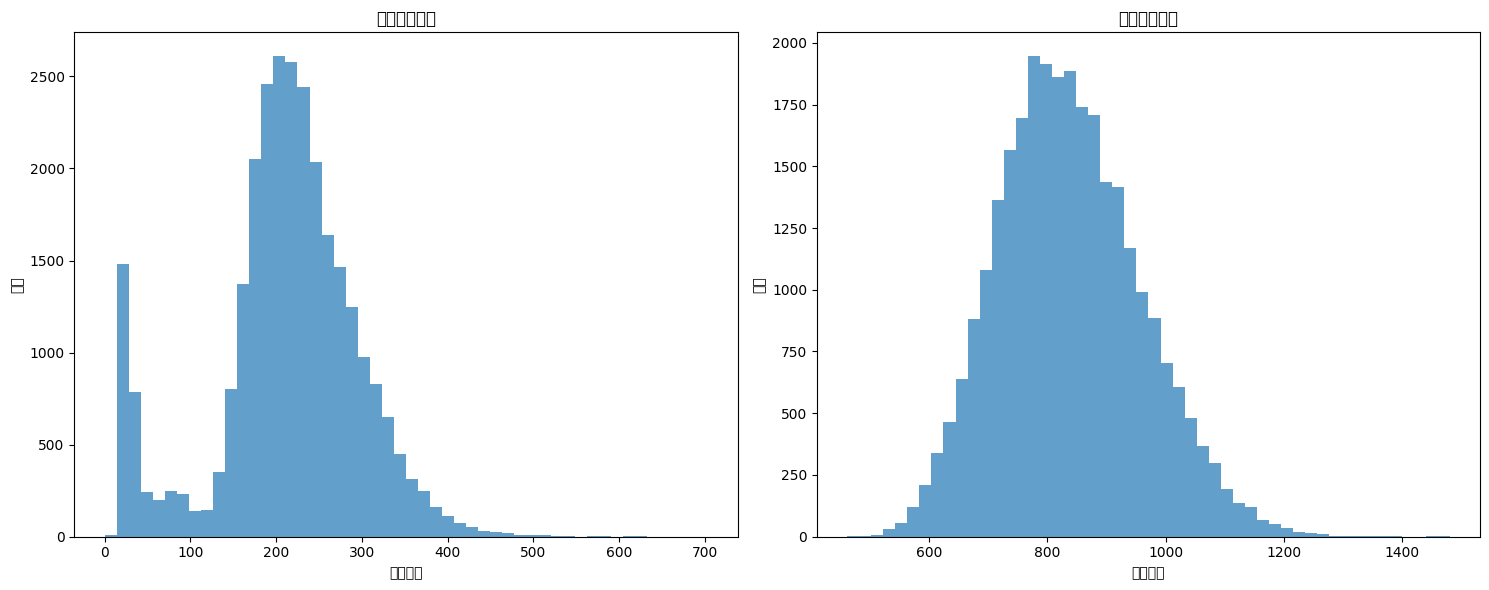

/tmp/ipykernel_70027/2426976489.py:141: UserWarning: Glyph 23383 (\N{CJK UNIFIED IDEOGRAPH-5B57}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_70027/2426976489.py:141: UserWarning: Glyph 31526 (\N{CJK UNIFIED IDEOGRAPH-7B26}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_70027/2426976489.py:141: UserWarning: Glyph 38271 (\N{CJK UNIFIED IDEOGRAPH-957F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_70027/2426976489.py:141: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_70027/2426976489.py:141: UserWarning: Glyph 39057 (\N{CJK UNIFIED IDEOGRAPH-9891}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_70027/2426976489.py:141: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_70027/2426976489.py:141: UserWarning: Glyph 24605 (\N{CJK UNIFIED I

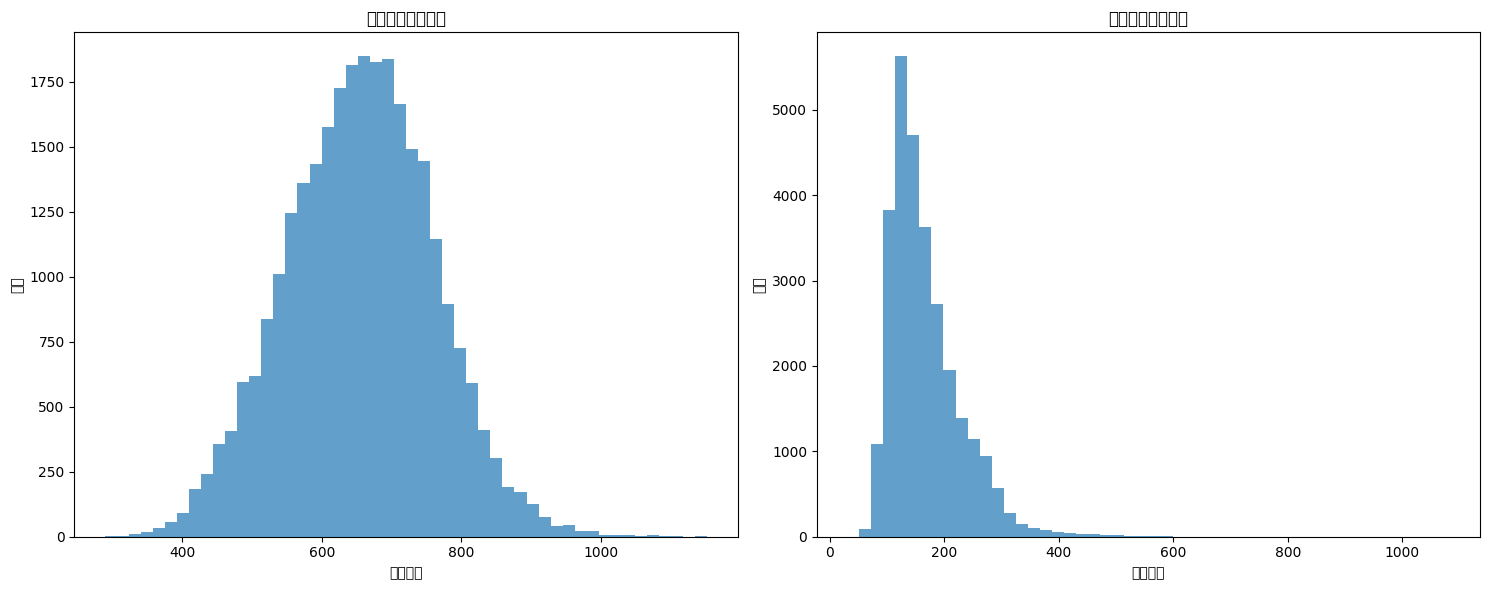


=== 长度区间分布 ===
输入长度区间分布:
0-50: 2417 条 (8.47%)
50-100: 796 条 (2.79%)
100-200: 7845 条 (27.49%)
200-500: 17435 条 (61.10%)
500-1000: 40 条 (0.14%)
1000-2000: 0 条 (0.00%)
2000-∞: 0 条 (0.00%)

输出长度区间分布:
0-100: 0 条 (0.00%)
100-200: 0 条 (0.00%)
200-500: 4 条 (0.01%)
500-1000: 25714 条 (90.12%)
1000-2000: 2815 条 (9.87%)
2000-3000: 0 条 (0.00%)
3000-∞: 0 条 (0.00%)

思维过程长度区间分布:
0-100: 0 条 (0.00%)
100-200: 0 条 (0.00%)
200-500: 2097 条 (7.35%)
500-1000: 26405 条 (92.54%)
1000-2000: 31 条 (0.11%)
2000-3000: 0 条 (0.00%)
3000-∞: 0 条 (0.00%)

=== 随机CoT样本示例 ===

样本 1:
输入 (231字符): **问题：**  
2015年10月13日11时许，被告人何某在武汉市新洲区邾城街衡州大街金鹤宾馆8102房门口，以人民币500元的价格向陈某贩卖10颗甲基苯丙胺片剂（“麻果”）和1包甲基苯丙胺（冰毒），交易完成后被当场抓获。经鉴定，毒品净重1.01克，均为甲基苯丙胺。何某自愿认罪。根据《刑法》第347条，公诉机关建议判处有期徒刑并处罚金。本案中，何某的行为是否完全符合走私、贩卖、运输、制造毒品罪...
思维过程 (695字符): **  
1. **犯罪构成要件分析**  
   - **客观要件**：  
     - **行为**：何某实施了贩卖毒品的行为（以500元价格向陈某交付毒品）。  
     - **结果**：毒品交易完成（1.01克甲基苯丙胺已实际转移）。  
     - **因果关系**：何某的行为直接导致毒品流入社会，侵害了国家对毒品的管制秩序。  
   - **主观要件**：  
     - ...
答案部分 (134字符): 


In [ ]:
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

def merge_cot_jsonl_files(input_files, output_file):
    """
    合并多个JSONL文件，保留所有字段
    
    Args:
        input_files: 输入JSONL文件路径列表
        output_file: 输出文件路径
    
    Returns:
        所有处理的数据列表，用于后续分析
    """
    all_data = []
    
    # 准备输出文件
    with open(output_file, 'w', encoding='utf-8') as outf:
        # 处理每个输入文件
        for input_file in input_files:
            print(f"处理文件: {input_file}")
            count = 0
            
            # 读取JSONL文件
            with open(input_file, 'r', encoding='utf-8') as inf:
                for line in tqdm(inf, desc=f"读取 {os.path.basename(input_file)}"):
                    try:
                        # 解析JSON
                        item = json.loads(line.strip())
                        
                        # 检查必要字段是否存在
                        if 'input' in item and 'output' in item:
                            # 写入输出文件
                            outf.write(json.dumps(item, ensure_ascii=False) + "\n")
                            all_data.append(item)
                            count += 1
                    
                    except Exception as e:
                        print(f"处理行时出错: {str(e)}")
            
            print(f"从 {input_file} 中提取了 {count} 条数据")
    
    print(f"合并完成，总共 {len(all_data)} 条数据")
    print(f"输出文件: {output_file}")
    
    return all_data

def analyze_cot_data_distribution(data):
    """
    分析CoT数据长度分布
    
    Args:
        data: 数据列表，每项包含input和output字段
    """
    # 计算输入和输出的长度
    input_lengths = [len(item['input']) for item in data]
    output_lengths = [len(item['output']) for item in data]
    
    # 分析思维链特征
    think_tag_count = sum(1 for item in data if '<think>' in item['output'])
    
    # 提取思维链部分和答案部分的长度
    think_lengths = []
    answer_lengths = []
    
    for item in data:
        output = item['output']
        if '<think>' in output and '</think>' in output:
            think_part = output[output.find('<think>')+7:output.find('</think>')]
            think_lengths.append(len(think_part))
            
            # 尝试提取答案部分
            remaining = output[output.find('</think>')+8:]
            answer_lengths.append(len(remaining))
    
    # 创建DataFrame便于分析
    df = pd.DataFrame({
        'input_length': input_lengths,
        'output_length': output_lengths
    })
    
    if think_lengths:
        df_think = pd.DataFrame({
            'think_length': think_lengths,
            'answer_length': answer_lengths
        })
    
    # 基本统计信息
    print("\n=== 数据长度统计 ===")
    print("输入长度统计:")
    print(df['input_length'].describe())
    print("\n输出长度统计:")
    print(df['output_length'].describe())
    
    print(f"\n包含<think>标签的数据: {think_tag_count}/{len(data)} ({think_tag_count/len(data)*100:.2f}%)")
    
    if think_lengths:
        print("\n思维过程长度统计:")
        print(pd.Series(think_lengths).describe())
        print("\n答案部分长度统计:")
        print(pd.Series(answer_lengths).describe())
    
    # 绘制长度分布直方图
    plt.figure(figsize=(15, 6))
    
    plt.subplot(1, 2, 1)
    plt.hist(input_lengths, bins=50, alpha=0.7)
    plt.title('输入长度分布')
    plt.xlabel('字符长度')
    plt.ylabel('频次')
    
    plt.subplot(1, 2, 2)
    plt.hist(output_lengths, bins=50, alpha=0.7)
    plt.title('输出长度分布')
    plt.xlabel('字符长度')
    plt.ylabel('频次')
    
    plt.tight_layout()
    plt.show()
    
    # 如果有思维链数据，绘制思维链和答案长度分布
    if think_lengths:
        plt.figure(figsize=(15, 6))
        
        plt.subplot(1, 2, 1)
        plt.hist(think_lengths, bins=50, alpha=0.7)
        plt.title('思维过程长度分布')
        plt.xlabel('字符长度')
        plt.ylabel('频次')
        
        plt.subplot(1, 2, 2)
        plt.hist(answer_lengths, bins=50, alpha=0.7)
        plt.title('答案部分长度分布')
        plt.xlabel('字符长度')
        plt.ylabel('频次')
        
        plt.tight_layout()
        plt.show()
    
    # 长度区间分布
    print("\n=== 长度区间分布 ===")
    
    # 输入长度区间
    input_ranges = [
        (0, 50), (50, 100), (100, 200), (200, 500), 
        (500, 1000), (1000, 2000), (2000, float('inf'))
    ]
    
    print("输入长度区间分布:")
    for start, end in input_ranges:
        count = ((df['input_length'] >= start) & (df['input_length'] < end)).sum()
        percentage = count / len(df) * 100
        print(f"{start}-{end if end != float('inf') else '∞'}: {count} 条 ({percentage:.2f}%)")
    
    # 输出长度区间
    output_ranges = [
        (0, 100), (100, 200), (200, 500), (500, 1000), 
        (1000, 2000), (2000, 3000), (3000, float('inf'))
    ]
    
    print("\n输出长度区间分布:")
    for start, end in output_ranges:
        count = ((df['output_length'] >= start) & (df['output_length'] < end)).sum()
        percentage = count / len(df) * 100
        print(f"{start}-{end if end != float('inf') else '∞'}: {count} 条 ({percentage:.2f}%)")
    
    # 如果有思维链数据，分析思维链长度区间
    if think_lengths:
        think_ranges = [
            (0, 100), (100, 200), (200, 500), (500, 1000), 
            (1000, 2000), (2000, 3000), (3000, float('inf'))
        ]
        
        print("\n思维过程长度区间分布:")
        for start, end in think_ranges:
            count = sum(1 for length in think_lengths if start <= length < end)
            percentage = count / len(think_lengths) * 100
            print(f"{start}-{end if end != float('inf') else '∞'}: {count} 条 ({percentage:.2f}%)")
    
    # 分析样本数据类型
    analyze_cot_sample_content(data)

def analyze_cot_sample_content(data, sample_size=5):
    """
    分析CoT样本内容
    """
    # 随机选择样本
    import random
    samples = random.sample(data, min(sample_size, len(data)))
    
    print("\n=== 随机CoT样本示例 ===")
    for i, sample in enumerate(samples, 1):
        print(f"\n样本 {i}:")
        print(f"输入 ({len(sample['input'])}字符): {sample['input'][:200]}...")
        
        output = sample['output']
        if '<think>' in output and '</think>' in output:
            think_part = output[output.find('<think>')+7:output.find('</think>')]
            answer_part = output[output.find('</think>')+8:]
            print(f"思维过程 ({len(think_part)}字符): {think_part[:200]}...")
            print(f"答案部分 ({len(answer_part)}字符): {answer_part[:200]}...")
        else:
            print(f"输出 ({len(output)}字符): {output[:200]}...")

# 设置参数
base_dir = "/root/autodl-tmp/muyan/data/cot"
input_files = [
    os.path.join(base_dir, "rest_data_cot_1w.jsonl"),
    os.path.join(base_dir, "rest_data_cot_2w.jsonl"),
    os.path.join(base_dir, "kg_crime_all.jsonl")
]
output_file = os.path.join(base_dir, "merged_all_cot_data.jsonl")

# 执行合并和分析
all_data = merge_cot_jsonl_files(input_files, output_file)
analyze_cot_data_distribution(all_data)

### 数据过滤与拆解

In [ ]:
import json
import random
import os
import numpy as np
import re
from tqdm.notebook import tqdm

def filter_clean_split_cot(input_file, train_output, test_output, min_input_length=50, train_ratio=0.9):
    """
    过滤短输入，清洗文本并拆分CoT数据集
    
    Args:
        input_file: 输入JSONL文件路径
        train_output: 训练集输出文件路径
        test_output: 测试集输出文件路径
        min_input_length: 输入文本最小长度限制
        train_ratio: 训练集占比
    
    Returns:
        train_count: 训练集数据量
        test_count: 测试集数据量
    """
    # 读取所有数据并过滤、清洗
    all_data = []
    short_input_count = 0
    total_count = 0
    
    print(f"读取并处理文件: {input_file}")
    with open(input_file, 'r', encoding='utf-8') as f:
        for line in tqdm(f, desc="读取、过滤和清洗数据"):
            total_count += 1
            try:
                item = json.loads(line.strip())
                
                # 过滤掉输入长度小于指定值的数据
                if len(item['input']) < min_input_length:
                    short_input_count += 1
                    continue
                
                # 清洗input中的"生成"字样
                item['input'] = re.sub(r'生成', '', item['input'])
                
                # 清洗output中的"解答"字样
                item['output'] = re.sub(r'解答', '', item['output'])
                
                all_data.append(item)
            except Exception as e:
                print(f"处理行时出错: {str(e)}")
    
    print(f"总数据: {total_count}条")
    print(f"过滤掉输入长度<{min_input_length}的数据: {short_input_count}条")
    print(f"保留数据: {len(all_data)}条")
    
    # 随机打乱数据
    random.seed(42)  # 设置随机种子，确保结果可复

def filter_clean_split_cot(input_file, train_output, test_output, min_input_length=50, train_ratio=0.9):
    """
    过滤短输入，清洗文本并拆分CoT数据集
    
    Args:
        input_file: 输入JSONL文件路径
        train_output: 训练集输出文件路径
        test_output: 测试集输出文件路径
        min_input_length: 输入文本最小长度限制
        train_ratio: 训练集占比
    
    Returns:
        train_count: 训练集数据量
        test_count: 测试集数据量
    """
    # 读取所有数据并过滤、清洗
    all_data = []
    short_input_count = 0
    total_count = 0
    
    print(f"读取并处理文件: {input_file}")
    with open(input_file, 'r', encoding='utf-8') as f:
        for line in tqdm(f, desc="读取、过滤和清洗数据"):
            total_count += 1
            try:
                item = json.loads(line.strip())
                
                # 过滤掉输入长度小于指定值的数据
                if len(item['input']) < min_input_length:
                    short_input_count += 1
                    continue
                
                # 清洗input中的"生成"字样
                item['input'] = re.sub(r'生成', '', item['input'])
                
                # 清洗output中的"解答"字样
                item['output'] = re.sub(r'解答', '', item['output'])
                
                all_data.append(item)
            except Exception as e:
                print(f"处理行时出错: {str(e)}")
    
    print(f"总数据: {total_count}条")
    print(f"过滤掉输入长度<{min_input_length}的数据: {short_input_count}条")
    print(f"保留数据: {len(all_data)}条")
    
    # 随机打乱数据
    random.seed(42)  # 设置随机种子，确保结果可复现
    random.shuffle(all_data)
    
    # 计算分割点
    split_index = int(len(all_data) * train_ratio)
    
    # 均匀抽样（而不是连续分割）
    indices = np.arange(len(all_data))
    train_indices = np.sort(np.random.choice(indices, size=split_index, replace=False))
    test_indices = np.setdiff1d(indices, train_indices)
    
    train_data = [all_data[i] for i in train_indices]
    test_data = [all_data[i] for i in test_indices]
    
    # 写入训练集
    with open(train_output, 'w', encoding='utf-8') as f:
        for item in tqdm(train_data, desc="写入训练集"):
            f.write(json.dumps(item, ensure_ascii=False) + '\n')
    
    # 写入测试集
    with open(test_output, 'w', encoding='utf-8') as f:
        for item in tqdm(test_data, desc="写入测试集"):
            f.write(json.dumps(item, ensure_ascii=False) + '\n')
    
    print(f"\n数据集拆分完成:")
    print(f"训练集({train_ratio*100:.0f}%): {len(train_data)}条 -> {train_output}")
    print(f"测试集({(1-train_ratio)*100:.0f}%): {len(test_data)}条 -> {test_output}")
    
    return len(train_data), len(test_data)

def analyze_split_results(train_file, test_file):
    """
    分析拆分后的数据文件
    """
    # 统计文件大小
    train_size = os.path.getsize(train_file) / (1024 * 1024)
    test_size = os.path.getsize(test_file) / (1024 * 1024)
    
    print(f"\n文件大小统计:")
    print(f"训练集: {train_size:.2f} MB")
    print(f"测试集: {test_size:.2f} MB")
    
    # 读取训练集样本分析
    train_input_lens = []
    train_output_lens = []
    train_think_lens = []
    
    with open(train_file, 'r', encoding='utf-8') as f:
        for line in tqdm(f, desc="分析训练集"):
            try:
                item = json.loads(line)
                train_input_lens.append(len(item['input']))
                train_output_lens.append(len(item['output']))
                
                output = item['output']
                if '<think>' in output and '</think>' in output:
                    think_part = output[output.find('<think>')+7:output.find('</think>')]
                    train_think_lens.append(len(think_part))
            except:
                pass
    
    # 读取测试集样本分析
    test_input_lens = []
    test_output_lens = []
    
    with open(test_file, 'r', encoding='utf-8') as f:
        for line in tqdm(f, desc="分析测试集"):
            try:
                item = json.loads(line)
                test_input_lens.append(len(item['input']))
                test_output_lens.append(len(item['output']))
            except:
                pass
    
    print(f"\n数据长度统计:")
    print(f"训练集输入长度: 平均 {np.mean(train_input_lens):.1f} 字符, 中位数 {np.median(train_input_lens):.1f} 字符")
    print(f"训练集输出长度: 平均 {np.mean(train_output_lens):.1f} 字符, 中位数 {np.median(train_output_lens):.1f} 字符")
    print(f"测试集输入长度: 平均 {np.mean(test_input_lens):.1f} 字符, 中位数 {np.median(test_input_lens):.1f} 字符")
    print(f"测试集输出长度: 平均 {np.mean(test_output_lens):.1f} 字符, 中位数 {np.median(test_output_lens):.1f} 字符")
    
    if train_think_lens:
        print(f"训练集思维过程长度: 平均 {np.mean(train_think_lens):.1f} 字符, 中位数 {np.median(train_think_lens):.1f} 字符")
        print(f"含思维过程的样本占比: {len(train_think_lens)/len(train_input_lens)*100:.1f}%")

# 设置参数
base_dir = "/root/autodl-tmp/muyan/data/cot"
input_file = os.path.join(base_dir, "merged_all_cot_data.jsonl")
train_output = os.path.join(base_dir, "filter_all_cot_train_data.jsonl")
test_output = os.path.join(base_dir, "filter_all_cot_test_data.jsonl")
min_input_length = 50
train_ratio = 0.9

# 执行过滤、清洗和拆分
train_count, test_count = filter_clean_split_cot(
    input_file, 
    train_output, 
    test_output, 
    min_input_length, 
    train_ratio
)

# 分析拆分结果
analyze_split_results(train_output, test_output)

读取并处理文件: /root/autodl-tmp/muyan/data/cot/merged_all_cot_data.jsonl


读取、过滤和清洗数据: 0it [00:00, ?it/s]

总数据: 28533条
过滤掉输入长度<50的数据: 2417条
保留数据: 26116条


写入训练集:   0%|          | 0/23504 [00:00<?, ?it/s]

写入测试集:   0%|          | 0/2612 [00:00<?, ?it/s]


数据集拆分完成:
训练集(90%): 23504条 -> /root/autodl-tmp/muyan/data/cot/filter_all_cot_train_data.jsonl
测试集(10%): 2612条 -> /root/autodl-tmp/muyan/data/cot/filter_all_cot_test_data.jsonl

文件大小统计:
训练集: 59.91 MB
测试集: 6.66 MB


分析训练集: 0it [00:00, ?it/s]

分析测试集: 0it [00:00, ?it/s]


数据长度统计:
训练集输入长度: 平均 229.2 字符, 中位数 222.0 字符
训练集输出长度: 平均 830.7 字符, 中位数 823.0 字符
测试集输入长度: 平均 230.6 字符, 中位数 223.0 字符
测试集输出长度: 平均 828.6 字符, 中位数 821.0 字符
训练集思维过程长度: 平均 651.2 字符, 中位数 652.0 字符
含思维过程的样本占比: 100.0%


## 3.6 SFT数据准备

lawzhidao_filter.csv 进行数据处理，主要是数据过滤

In [ ]:
import pandas as pd
import json
import os
from tqdm.notebook import tqdm

def process_csv_to_sft(input_csv, output_file):
    """
    处理CSV文件，将符合条件的数据转换为SFT训练数据格式
    
    条件:
    - is_best=1
    - 优先使用question作为input，若为空则使用title
    
    Args:
        input_csv: 输入CSV文件路径
        output_file: 输出文件路径
    """
    # 读取CSV文件
    print(f"读取CSV文件: {input_csv}")
    df = pd.read_csv(input_csv)
    print(f"CSV文件包含 {len(df)} 行数据")
    
    # 筛选is_best=1的数据
    filtered_df = df[df['is_best'] == 1]
    print(f"筛选出 {len(filtered_df)} 行 is_best=1 的数据")
    
    # 准备输出文件
    with open(output_file, 'w', encoding='utf-8') as outf:
        # 统计计数
        processed = 0
        
        # 处理每一行
        for _, row in tqdm(filtered_df.iterrows(), total=len(filtered_df), desc="处理数据"):
            try:
                # 选择input字段(优先question，否则用title)
                question = row.get('question', '')
                title = row.get('title', '')
                
                input_text = question if question and not pd.isna(question) else title
                
                # 如果input为空，则跳过
                if not input_text or pd.isna(input_text):
                    continue
                
                # 获取reply作为输出
                reply = row.get('reply', '')
                if pd.isna(reply) or not reply:
                    continue
                
                # 构建SFT训练格式
                sft_item = {
                    "input": input_text,
                    "output": reply
                }
                
                # 写入输出文件
                outf.write(json.dumps(sft_item, ensure_ascii=False) + "\n")
                processed += 1
                
            except Exception as e:
                print(f"处理数据时出错: {str(e)}")
    
    print(f"处理完成，成功转换 {processed} 条数据")
    print(f"输出文件: {output_file}")

# 设置参数
input_csv = "/root/autodl-tmp/muyan/data/sft/lawzhidao_filter.csv"
output_file = "./lawzhidao_sft.jsonl"

# 执行处理
process_csv_to_sft(input_csv, output_file)

读取CSV文件: /root/autodl-tmp/muyan/data/sft/lawzhidao_filter.csv
CSV文件包含 36368 行数据
筛选出 18243 行 is_best=1 的数据


处理数据:   0%|          | 0/18243 [00:00<?, ?it/s]

处理完成，成功转换 18238 条数据
输出文件: ./lawzhidao_sft.jsonl


```json
{"input": "你好我的银行卡昨天我一个以前的朋友叫我发给他，这个对我有伤害吗", "output": "您好，只提供银行卡号不提供实际信息不会有影响，建议您注重个人隐私和财务安全。", "meta": {"cause": "债权债务"}}
{"input": "乡村道路摩托车相撞，双方都有责任，今年X月份满两年，一方提起诉讼，有效吗？", "output": "你好，有效的，根据根据《中华人民共和国民法典》第一百八十八条的规定，向人民法院请求保护民事权利的诉讼时效期间为三年，所以在两年内提起诉讼也是有效的。", "meta": {"cause": "交通事故"}}
```

处理路径下单独json文件并汇总成问题集

In [ ]:
import json
import os
import glob
from tqdm.notebook import tqdm  # 注意这里使用tqdm的notebook版本

def process_json_files_to_sft(input_dir, output_file):
    """
    处理指定目录下的所有JSON文件，转换为SFT训练数据格式
    
    Args:
        input_dir: 输入目录路径，包含所有JSON文件
        output_file: 输出文件路径
    """
    # 获取目录下所有JSON文件
    json_files = glob.glob(os.path.join(input_dir, "*.json"))
    print(f"找到 {len(json_files)} 个JSON文件")
    
    # 准备输出文件
    with open(output_file, 'w', encoding='utf-8') as outf:
        # 处理每个文件
        for file_path in tqdm(json_files, desc="处理文件"):
            try:
                # 读取JSON文件
                with open(file_path, 'r', encoding='utf-8') as f:
                    data = json.load(f)
                
                # 提取关键字段
                question = data.get("question", "")
                answer = data.get("answer", "")
                cause = data.get("cause", "")
                
                # 构建SFT训练格式
                sft_item = {
                    "input": question,
                    "output": answer
                }
                
                # 可选：添加额外元数据
                if cause:
                    sft_item["meta"] = {"cause": cause}
                
                # 写入输出文件
                outf.write(json.dumps(sft_item, ensure_ascii=False) + "\n")
                
            except Exception as e:
                print(f"处理文件 {file_path} 时出错: {str(e)}")
    
    print(f"处理完成，输出文件: {output_file}")

# 直接在Jupyter中设置参数并执行
input_dir = "/root/autodl-tmp/muyan/data/sft/train"  # 输入目录
output_file = "/root/autodl-tmp/muyan/data/sft/sft_training_data.jsonl"  # 输出文件

# 执行处理函数
process_json_files_to_sft(input_dir, output_file)

找到 16209 个JSON文件


处理文件:   0%|          | 0/16209 [00:00<?, ?it/s]

处理完成，输出文件: /root/autodl-tmp/muyan/data/sft/sft_training_data.jsonl


```json
{"input": "入室持刀行凶伤人能不能判刑", "output": "对于入室持刀伤人涉嫌故意伤害刑事犯罪，一经定罪，故意伤害他人身体的，处三年以下有期徒刑、拘役或者管制。犯前款罪，致人重伤的，处三年以上十年以下有期徒刑；致人死亡或者以特别残忍手段致人重伤造成严重残疾的，处十年以上有期徒刑、无期徒刑或者死刑。相关法律规定《中华人民共和国刑法》第二百三十四条故意伤害他人身体的，处三年以下有期徒刑、拘役或者管制。犯前款罪，致人重伤的，处三年以上十年以下有期徒刑；致人死亡或者以特别残忍手段致人重伤造成严重残疾的，处十年以上有期徒刑、无期徒刑或者死刑。本法另有规定的，依照规定。"}
{"input": "对交通事故责任认定书不服怎么办，交通事故损", "output": "事故认定书下发后，如果你对认定不满意，可在接到认定书3日内到上一级公安机关复议。"}

```

### 数据过滤合并

处理文件: /root/autodl-tmp/muyan/data/sft/sft_training_data.jsonl


读取 sft_training_data.jsonl: 0it [00:00, ?it/s]

从 /root/autodl-tmp/muyan/data/sft/sft_training_data.jsonl 中提取了 16209 条数据
处理文件: /root/autodl-tmp/muyan/data/sft/lawzhidao_sft.jsonl


读取 lawzhidao_sft.jsonl: 0it [00:00, ?it/s]

从 /root/autodl-tmp/muyan/data/sft/lawzhidao_sft.jsonl 中提取了 18238 条数据
合并完成，总共 34447 条数据
输出文件: /root/autodl-tmp/muyan/data/sft/all_sft.jsonl

=== 数据长度统计 ===
输入长度统计:
count    34447.000000
mean        35.186373
std         35.474357
min          1.000000
25%         16.000000
50%         22.000000
75%         40.000000
max        575.000000
Name: input_length, dtype: float64

输出长度统计:
count    34447.000000
mean       195.723953
std        310.798000
min          1.000000
25%         34.000000
50%         81.000000
75%        250.000000
max       7274.000000
Name: output_length, dtype: float64


/tmp/ipykernel_69400/1249659910.py:96: UserWarning: Glyph 23383 (\N{CJK UNIFIED IDEOGRAPH-5B57}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_69400/1249659910.py:96: UserWarning: Glyph 31526 (\N{CJK UNIFIED IDEOGRAPH-7B26}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_69400/1249659910.py:96: UserWarning: Glyph 38271 (\N{CJK UNIFIED IDEOGRAPH-957F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_69400/1249659910.py:96: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_69400/1249659910.py:96: UserWarning: Glyph 39057 (\N{CJK UNIFIED IDEOGRAPH-9891}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_69400/1249659910.py:96: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_69400/1249659910.py:96: UserWarning: Glyph 36755 (\N{CJK UNIFIED IDEOGRAP

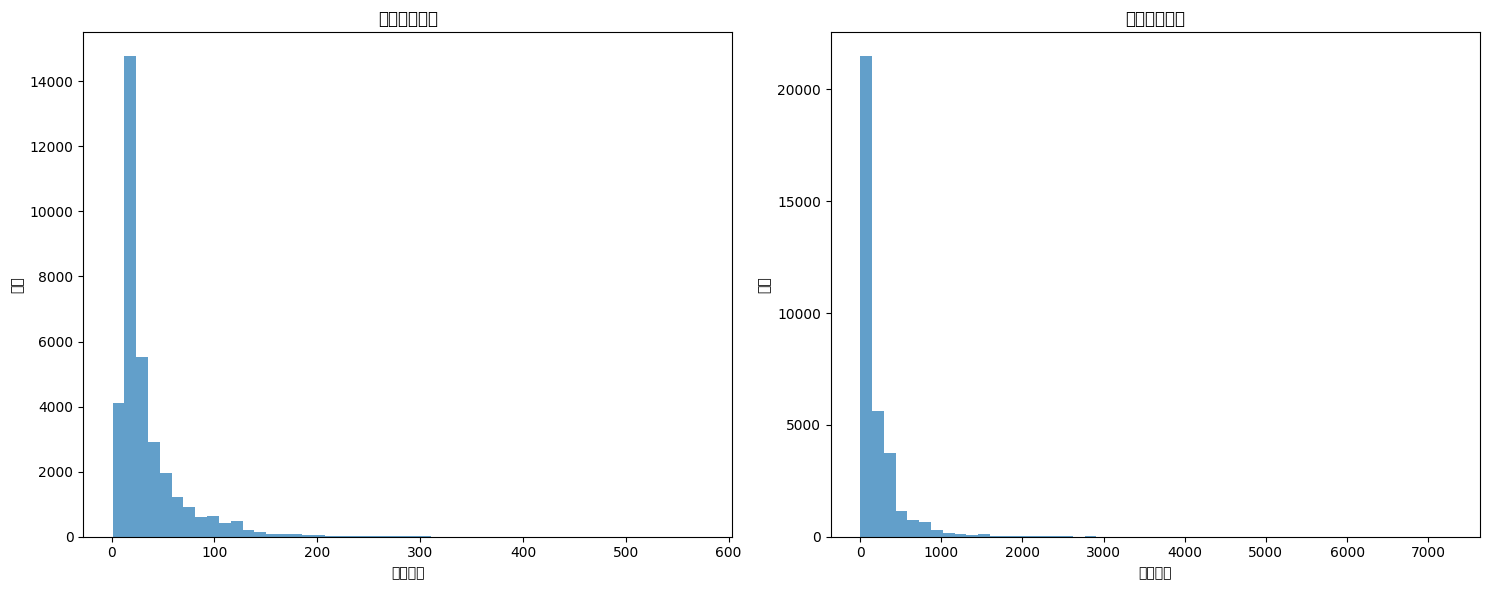


=== 长度区间分布 ===
输入长度区间分布:
0-50: 27910 条 (81.02%)
50-100: 4499 条 (13.06%)
100-200: 1818 条 (5.28%)
200-500: 218 条 (0.63%)
500-1000: 2 条 (0.01%)
1000-2000: 0 条 (0.00%)
2000-∞: 0 条 (0.00%)

输出长度区间分布:
0-50: 12582 条 (36.53%)
50-100: 6283 条 (18.24%)
100-200: 4755 条 (13.80%)
200-500: 7810 条 (22.67%)
500-1000: 2260 条 (6.56%)
1000-2000: 599 条 (1.74%)
2000-∞: 158 条 (0.46%)

输出/输入长度比例统计:
count    34447.000000
mean        11.815269
std         22.385400
min          0.013937
25%          0.897436
50%          3.208333
75%         14.769231
max        548.727273
dtype: float64

=== 随机样本示例 ===

样本 1:
输入 (56字符): 我家住X，我母亲是已故军人遗属，享受军人遗属补助金，于XXXX年X月XX日去世了，请问补助金应该是什么时候停发？...
输出 (23字符): 您好！具体看当地政策如何规定，可咨询发放部门。...

样本 2:
输入 (53字符): 我借了二万高利贷，一个月XX分利，被出借人吃了五期，差不多一万利息，现在无力还贷，我要问一下律师们如何调解...
输出 (125字符): 您好，您只需要归还合理范围内本金和利息，判断利息是否合理可根据《最高人民法院关于审理民间借贷案件适用法律若干问题的规定》，出借人请求借款人按照合同约定的利率支付利息的人民法院应予支持，但是双方约定的利...

样本 3:
输入 (225字符): 我车子XX年X月XX号付的定金五千，X月XX第二次订转定金共X万，X月XX付的全款，X月XX提车，现在临牌都过期了，一直上不到新能源牌照，提车的时候告知地标没过，说很快就能过的

In [ ]:
# pip install matplotlib
import json 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

def merge_jsonl_files(input_files, output_file, fields=['input', 'output']):
    """
    合并多个JSONL文件，只保留指定字段
    
    Args:
        input_files: 输入JSONL文件路径列表
        output_file: 输出文件路径
        fields: 要保留的字段列表
    
    Returns:
        所有处理的数据列表，用于后续分析
    """
    all_data = []
    
    # 准备输出文件
    with open(output_file, 'w', encoding='utf-8') as outf:
        # 处理每个输入文件
        for input_file in input_files:
            print(f"处理文件: {input_file}")
            count = 0
            
            # 读取JSONL文件
            with open(input_file, 'r', encoding='utf-8') as inf:
                for line in tqdm(inf, desc=f"读取 {os.path.basename(input_file)}"):
                    try:
                        # 解析JSON
                        item = json.loads(line.strip())
                        
                        # 只保留指定字段
                        filtered_item = {field: item.get(field, "") for field in fields}
                        
                        # 确保字段非空
                        if all(filtered_item.get(field, "") for field in fields):
                            # 写入输出文件
                            outf.write(json.dumps(filtered_item, ensure_ascii=False) + "\n")
                            all_data.append(filtered_item)
                            count += 1
                    
                    except Exception as e:
                        print(f"处理行时出错: {str(e)}")
            
            print(f"从 {input_file} 中提取了 {count} 条数据")
    
    print(f"合并完成，总共 {len(all_data)} 条数据")
    print(f"输出文件: {output_file}")
    
    return all_data

def analyze_data_distribution(data):
    """
    分析数据长度分布
    
    Args:
        data: 数据列表，每项包含input和output字段
    """
    # 计算输入和输出的长度
    input_lengths = [len(item['input']) for item in data]
    output_lengths = [len(item['output']) for item in data]
    
    # 创建DataFrame便于分析
    df = pd.DataFrame({
        'input_length': input_lengths,
        'output_length': output_lengths
    })
    
    # 基本统计信息
    print("\n=== 数据长度统计 ===")
    print("输入长度统计:")
    print(df['input_length'].describe())
    print("\n输出长度统计:")
    print(df['output_length'].describe())
    
    # 绘制长度分布直方图
    plt.figure(figsize=(15, 6))
    
    plt.subplot(1, 2, 1)
    plt.hist(input_lengths, bins=50, alpha=0.7)
    plt.title('输入长度分布')
    plt.xlabel('字符长度')
    plt.ylabel('频次')
    
    plt.subplot(1, 2, 2)
    plt.hist(output_lengths, bins=50, alpha=0.7)
    plt.title('输出长度分布')
    plt.xlabel('字符长度')
    plt.ylabel('频次')
    
    plt.tight_layout()
    plt.show()
    
    # 长度区间分布
    print("\n=== 长度区间分布 ===")
    
    # 输入长度区间
    input_ranges = [
        (0, 50), (50, 100), (100, 200), (200, 500), 
        (500, 1000), (1000, 2000), (2000, float('inf'))
    ]
    
    print("输入长度区间分布:")
    for start, end in input_ranges:
        count = ((df['input_length'] >= start) & (df['input_length'] < end)).sum()
        percentage = count / len(df) * 100
        print(f"{start}-{end if end != float('inf') else '∞'}: {count} 条 ({percentage:.2f}%)")
    
    # 输出长度区间
    output_ranges = [
        (0, 50), (50, 100), (100, 200), (200, 500), 
        (500, 1000), (1000, 2000), (2000, float('inf'))
    ]
    
    print("\n输出长度区间分布:")
    for start, end in output_ranges:
        count = ((df['output_length'] >= start) & (df['output_length'] < end)).sum()
        percentage = count / len(df) * 100
        print(f"{start}-{end if end != float('inf') else '∞'}: {count} 条 ({percentage:.2f}%)")
    
    # 输入-输出长度比例
    ratio = df['output_length'] / df['input_length']
    print("\n输出/输入长度比例统计:")
    print(ratio.describe())
    
    # 分析样本数据类型
    analyze_sample_content(data)

def analyze_sample_content(data, sample_size=5):
    """
    分析样本内容类型
    """
    # 随机选择样本
    import random
    samples = random.sample(data, min(sample_size, len(data)))
    
    print("\n=== 随机样本示例 ===")
    for i, sample in enumerate(samples, 1):
        print(f"\n样本 {i}:")
        print(f"输入 ({len(sample['input'])}字符): {sample['input'][:100]}...")
        print(f"输出 ({len(sample['output'])}字符): {sample['output'][:100]}...")

# 设置参数
base_dir = "/root/autodl-tmp/muyan/data/sft"
input_files = [
    os.path.join(base_dir, "sft_training_data.jsonl"),
    os.path.join(base_dir, "lawzhidao_sft.jsonl")
]
output_file = os.path.join(base_dir, "all_sft.jsonl")

# 执行合并和分析
all_data = merge_jsonl_files(input_files, output_file)
analyze_data_distribution(all_data)

### 数据拆分

```python
import json
import os
import random
import pandas as pd
from tqdm.notebook import tqdm

def filter_and_split_data(input_file, train_output, test_output, max_output_length=500, train_ratio=0.5):
    """
    过滤长度过长的数据并均匀拆分为训练集和测试集
    
    Args:
        input_file: 输入JSONL文件
        train_output: 训练集输出文件
        test_output: 测试集输出文件
        max_output_length: 最大输出长度
        train_ratio: 训练集比例
    """
    # 读取全部数据
    all_data = []
    print(f"读取文件: {input_file}")
    
    with open(input_file, 'r', encoding='utf-8') as f:
        for line in tqdm(f, desc="读取数据"):
            try:
                item = json.loads(line.strip())
                all_data.append(item)
            except Exception as e:
                print(f"解析JSON时出错: {str(e)}")
    
    print(f"读取完成，共 {len(all_data)} 条数据")
    
    # 过滤输出长度过长的数据
    filtered_data = [item for item in all_data if len(item.get('output', '')) <= max_output_length]
    
    filtered_count = len(filtered_data)
    removed_count = len(all_data) - filtered_count
    
    print(f"过滤后剩余 {filtered_count} 条数据")
    print(f"移除了 {removed_count} 条输出长度 > {max_output_length} 的数据")
    
    # 打乱数据顺序
    random.seed(42)  # 设定随机种子，确保结果可复现
    random.shuffle(filtered_data)
    
    # 均匀拆分训练集和测试集
    # 使用步长方式均匀选择，而不是简单的前一半后一半
    train_data = []
    test_data = []
    
    for i, item in enumerate(filtered_data):
        if i % 2 == 0:  # 偶数索引分到训练集
            train_data.append(item)
        else:  # 奇数索引分到测试集
            test_data.append(item)
    
    print(f"训练集: {len(train_data)} 条数据")
    print(f"测试集: {len(test_data)} 条数据")
    
    # 保存训练集
    with open(train_output, 'w', encoding='utf-8') as f:
        for item in tqdm(train_data, desc="保存训练集"):
            f.write(json.dumps(item, ensure_ascii=False) + '\n')
    
    # 保存测试集
    with open(test_output, 'w', encoding='utf-8') as f:
        for item in tqdm(test_data, desc="保存测试集"):
            f.write(json.dumps(item, ensure_ascii=False) + '\n')
    
    print(f"处理完成！")
    print(f"训练集已保存至: {train_output}")
    print(f"测试集已保存至: {test_output}")
    
    # 输出两个集合长度分布的基本信息
    analyze_split_sets(train_data, test_data)
    
    return len(train_data), len(test_data)

def analyze_split_sets(train_data, test_data):
    """分析训练集和测试集的长度分布"""
    train_input_lengths = [len(item['input']) for item in train_data]
    train_output_lengths = [len(item['output']) for item in train_data]
    
    test_input_lengths = [len(item['input']) for item in test_data]
    test_output_lengths = [len(item['output']) for item in test_data]
    
    # 创建DataFrame
    train_df = pd.DataFrame({
        'input_length': train_input_lengths,
        'output_length': train_output_lengths
    })
    
    test_df = pd.DataFrame({
        'input_length': test_input_lengths,
        'output_length': test_output_lengths
    })
    
    print("\n=== 训练集长度统计 ===")
    print("输入长度: ", train_df['input_length'].describe())
    print("输出长度: ", train_df['output_length'].describe())
    
    print("\n=== 测试集长度统计 ===")
    print("输入长度: ", test_df['input_length'].describe())
    print("输出长度: ", test_df['output_length'].describe())

# 设置参数
base_dir = "/root/autodl-tmp/muyan/data/sft"
input_file = os.path.join(base_dir, "all_sft.jsonl")
train_output = os.path.join(base_dir, "filter_all_train_sft.jsonl")
test_output = os.path.join(base_dir, "filter_all_test_sft.jsonl")

# 执行过滤和拆分
train_count, test_count = filter_and_split_data(
    input_file, 
    train_output, 
    test_output, 
    max_output_length=500, 
    train_ratio=0.5
)

print(f"\n最终结果:")
print(f"训练集: {train_count} 条数据")
print(f"测试集: {test_count} 条数据")
print(f"总数据: {train_count + test_count} 条数据")
```

## 混合数据集

```python
import json
import random
from pathlib import Path
# 用于混合sft与cot数据集
# 路径定义
cot_file = Path('/root/autodl-tmp/filter_all_cot_train_data23k.jsonl')
sft_file = Path('/root/autodl-tmp/filter_all_train_sft18k.jsonl')
output_file = Path('/root/autodl-tmp/train_cot_sft_2w.jsonl')

# 读取 COT 数据
cot_data = []
with open(cot_file, 'r', encoding='utf-8') as f:
    for line in f:
        if line.strip():  # 确保不是空行
            cot_data.append(json.loads(line.strip()))

# 读取 SFT 数据
sft_data = []
with open(sft_file, 'r', encoding='utf-8') as f:
    for line in f:
        if line.strip():  # 确保不是空行
            sft_data.append(json.loads(line.strip()))

# 采样数据
cot_samples = cot_data[:12000] if len(cot_data) >= 12000 else cot_data
sft_samples = sft_data[:8000] if len(sft_data) >= 8000 else sft_data

# 计算交叉比例（每个SFT样本后跟随多少个COT样本）
ratio = len(cot_samples) / len(sft_samples)

# 合并并随机打乱数据
merged_data = []
cot_index = 0

# 均匀交叉合并数据
for sft_index in range(len(sft_samples)):
    # 添加一个SFT样本
    merged_data.append(sft_samples[sft_index])
    
    # 计算应该添加的COT样本数量
    cot_to_add = int((sft_index + 1) * ratio) - int(sft_index * ratio)
    
    # 添加对应数量的COT样本
    for _ in range(cot_to_add):
        if cot_index < len(cot_samples):
            merged_data.append(cot_samples[cot_index])
            cot_index += 1

# 确保所有COT样本都被添加
while cot_index < len(cot_samples):
    merged_data.append(cot_samples[cot_index])
    cot_index += 1

# 随机打乱最终数据（可选，取决于是否需要严格交替）
random.shuffle(merged_data)

# 写入输出文件
with open(output_file, 'w', encoding='utf-8') as f:
    for item in merged_data:
        f.write(json.dumps(item, ensure_ascii=False) + '\n')

print(f"完成合并！共写入 {len(merged_data)} 条数据到 {output_file}")
```

# 4. 模型准备

<div align=center><img src="https://typora-photo1220.oss-cn-beijing.aliyuncs.com/DataAnalysis/muyan/image-20250514155907938.png" width=100%></div>

## 模型下载

In [ ]:
from modelscope import snapshot_download

# 指定你想要的下载路径
custom_path = '/root/autodl-tmp/'

# 使用 cache_dir 参数下载模型到指定路径
model_dir = snapshot_download('Qwen/Qwen2.5-0.5B-Instruct', cache_dir=custom_path)

# 打印模型保存的路径
print(f"模型已下载到: {model_dir}")

2025-05-06 17:20:57,781 - modelscope - INFO - Got 10 files, start to download ...


Processing 10 items:   0%|          | 0.00/10.0 [00:00<?, ?it/s]

2025-05-06 17:22:01,878 - modelscope - INFO - Download model 'Qwen/Qwen2.5-0.5B-Instruct' successfully.
2025-05-06 17:22:01,878 - modelscope - INFO - Creating symbolic link [/root/autodl-tmp/Qwen/Qwen2.5-0.5B-Instruct].


模型已下载到: /root/autodl-tmp/Qwen/Qwen2___5-0___5B-Instruct


In [ ]:
#模型下载
from modelscope import snapshot_download

# 指定你想要的下载路径
custom_path = '/root/autodl-tmp/'

# 使用 cache_dir 参数下载模型到指定路径
model_dir = snapshot_download('deepseek-ai/DeepSeek-R1-Distill-Llama-8B', cache_dir=custom_path)

# 打印模型保存的路径
print(f"模型已下载到: {model_dir}")

2025-05-06 17:32:45,399 - modelscope - INFO - Got 11 files, start to download ...


Processing 11 items:   0%|          | 0.00/11.0 [00:00<?, ?it/s]

2025-05-06 17:42:10,868 - modelscope - INFO - Download model 'deepseek-ai/DeepSeek-R1-Distill-Llama-8B' successfully.


模型已下载到: /root/autodl-tmp/deepseek-ai/DeepSeek-R1-Distill-Llama-8B


# 5.蒸馏实践

本次采用混合蒸馏方式分布级蒸馏+特征级蒸馏。

!pip install transformers accelerate sentencepiece    
!pip install torch>=2.0.0

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer
import json
import os
import gc
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler
from transformers import get_linear_schedule_with_warmup


# 定义模型路径：指定教师模型、学生模型、训练数据和输出路径
teacher_model_path = "/root/autodl-tmp/deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
student_model_path = "/root/autodl-tmp/Qwen/Qwen2___5-0___5B-Instruct"
# 训练数据：包含2万个样本的JSONL文件，每行是一个训练样本
data_path = "/root/autodl-tmp/train_cot_sft_2w.jsonl"
# 输出目录：存放蒸馏后的模型
output_dir = "/root/autodl-tmp/distilled_model"

# 定义简单线性特征映射器类
# 作用：将教师模型的隐藏状态向量映射到学生模型的隐藏状态维度
# 这是最基础的特征映射方法，通过一个线性层实现特征空间转换
class SimpleMapper(nn.Module):
    def __init__(self, teacher_dim, student_dim):
        """
        初始化简单特征映射器
        参数:
            teacher_dim: 教师模型隐藏状态的维度
            student_dim: 学生模型隐藏状态的维度
        """
        super().__init__()
        # 创建一个线性变换层，将teacher_dim维的向量映射为student_dim维
        self.linear = nn.Linear(teacher_dim, student_dim)
        # 使用正态分布初始化权重，均值为0，标准差为0.02
        # 这是Transformer模型常用的初始化方法，有助于训练稳定
        nn.init.normal_(self.linear.weight, mean=0.0, std=0.02)
        # 将偏置初始化为0
        nn.init.zeros_(self.linear.bias)
        
    def forward(self, teacher_feature):
        """
        前向传播：应用线性变换
        参数:
            teacher_feature: 教师模型的隐藏状态 [batch_size, seq_len, teacher_dim]
        返回:
            映射后的特征 [batch_size, seq_len, student_dim]
        """
        return self.linear(teacher_feature)

# 多层特征映射器 - 主体代码没有用到的模块
# 如果要使用此映射器，需要将ProgressiveDistiller中的self.use_multi_layer设置为True
# 此映射器可以同时处理多个层的特征映射，实现更细粒度的知识迁移
class MultiLayerFeatureMapper(nn.Module):
    def __init__(self, teacher_dims, student_dims):
        """
        初始化多层特征映射器
        参数:
            teacher_dims: 教师模型各层隐藏状态的维度列表
            student_dims: 学生模型各层隐藏状态的维度列表
        """
        super().__init__()
        # 为每对教师-学生层维度创建一个高级特征映射器
        self.mappers = nn.ModuleList()
        for teacher_dim, student_dim in zip(teacher_dims, student_dims):
            self.mappers.append(AdvancedFeatureMapper(teacher_dim, student_dim))
            
    def forward(self, teacher_features, layer_indices):
        """
        前向传播：映射多层特征
        参数:
            teacher_features: 教师模型的所有层隐藏状态列表
            layer_indices: 需要映射的层索引列表
        返回:
            映射后的特征列表，与学生模型的对应层匹配
        """
        mapped_features = []
        for i, idx in enumerate(layer_indices):
            # 检查索引是否有效
            if idx < len(teacher_features) and i < len(self.mappers):
                mapped_features.append(self.mappers[i](teacher_features[idx]))
        return mapped_features

# 高级特征映射器 - 主体代码没有用到的模块
# 这是一个更复杂的单层特征映射器，使用了层归一化和非线性激活
# 相比SimpleMapper，可以捕获更复杂的特征关系
class AdvancedFeatureMapper(nn.Module):
    def __init__(self, teacher_dim, student_dim):
        """
        初始化高级特征映射器
        参数:
            teacher_dim: 教师模型隐藏状态的维度
            student_dim: 学生模型隐藏状态的维度
        """
        super().__init__()
        # 为教师特征添加层归一化，这有助于稳定训练
        self.teacher_norm = nn.LayerNorm(teacher_dim)
        # 为学生特征添加层归一化
        self.student_norm = nn.LayerNorm(student_dim)
        
        # 计算中间隐藏层维度，取两个维度的平均值
        hidden_dim = (teacher_dim + student_dim) // 2
        # 降维投影层：从教师维度到隐藏维度
        self.down_proj = nn.Linear(teacher_dim, hidden_dim)
        # 非线性激活函数：GELU比ReLU在NLP任务中通常效果更好
        self.activation = nn.GELU()
        # 升维投影层：从隐藏维度到学生维度
        self.up_proj = nn.Linear(hidden_dim, student_dim)
        
    def forward(self, teacher_feature):
        """
        前向传播：应用归一化、降维、非线性激活和升维
        参数:
            teacher_feature: 教师模型的隐藏状态
        返回:
            映射后的特征，维度与学生模型匹配
        """
        # 首先对输入应用层归一化
        x = self.teacher_norm(teacher_feature)
        # 降维
        x = self.down_proj(x)
        # 应用非线性激活
        x = self.activation(x)
        # 升维，映射到学生维度
        x = self.up_proj(x)
        return x

# 增强特征映射器 - 主体代码没有用到部分
# 这是一个更复杂的特征映射器，增加了中间层和dropout
# 如果想使用，需要修改MultiLayerFeatureMapper代码，将AdvancedFeatureMapper替换为EnhancedFeatureMapper
# 此映射器通过多层映射和dropout可以更好地泛化，对于复杂特征迁移可能效果更好
class EnhancedFeatureMapper(nn.Module):
    def __init__(self, teacher_dim, student_dim):
        """
        初始化增强特征映射器
        参数:
            teacher_dim: 教师模型隐藏状态的维度
            student_dim: 学生模型隐藏状态的维度
        """
        super().__init__()
        # 为教师和学生特征添加层归一化
        self.teacher_norm = nn.LayerNorm(teacher_dim)
        self.student_norm = nn.LayerNorm(student_dim)
        
        # 使用多个隐藏层的映射网络，实现更复杂的非线性变换
        # 第一个隐藏层维度：教师和学生维度的平均值
        hidden_dim1 = (teacher_dim + student_dim) // 2
        # 第二个隐藏层维度：第一隐藏层和学生维度的平均值
        hidden_dim2 = (hidden_dim1 + student_dim) // 2
        
        # 三层映射网络：教师维度 -> 隐藏层1 -> 隐藏层2 -> 学生维度
        self.down_proj = nn.Linear(teacher_dim, hidden_dim1)
        self.mid_proj = nn.Linear(hidden_dim1, hidden_dim2)
        self.up_proj = nn.Linear(hidden_dim2, student_dim)
        
        # 添加dropout层，减少过拟合
        self.dropout = nn.Dropout(0.1)  # 10%的dropout率
        # 非线性激活函数
        self.activation = nn.GELU()
        
    def forward(self, teacher_feature):
        """
        前向传播：应用多层非线性变换和dropout
        参数:
            teacher_feature: 教师模型的隐藏状态
        返回:
            映射后的特征，维度与学生模型匹配
        """
        # 首先对输入应用层归一化
        x = self.teacher_norm(teacher_feature)
        # 第一层投影
        x = self.down_proj(x)
        # 应用非线性激活
        x = self.activation(x)
        # 应用dropout，增强泛化能力
        x = self.dropout(x)
        # 第二层投影
        x = self.mid_proj(x)
        # 再次应用非线性激活
        x = self.activation(x)
        # 再次应用dropout
        x = self.dropout(x)
        # 最后一层投影，映射到学生维度
        x = self.up_proj(x)
        return x

# 自定义文本数据集类，处理和准备蒸馏训练数据
class TextDataset(Dataset):
    def __init__(self, examples, max_length, teacher_tokenizer, student_tokenizer):
        """
        初始化文本数据集
        参数:
            examples: 文本样本列表，每个样本包含text和is_full字段
            max_length: 序列最大长度
            teacher_tokenizer: 教师模型的分词器
            student_tokenizer: 学生模型的分词器
        """
        self.examples = examples
        self.max_length = max_length
        self.teacher_tokenizer = teacher_tokenizer
        self.student_tokenizer = student_tokenizer
        
        # 预处理所有样本以加速训练（避免每次迭代时重复分词）
        self.preprocessed_data = []
        # 使用tqdm显示预处理进度
        for example in tqdm(examples, desc="预处理数据"):
            text = example["text"]
            
            # 使用教师模型的分词器处理文本
            # max_length: 截断或填充到指定长度
            # padding: 填充到max_length
            # truncation: 如果超出max_length则截断
            # return_tensors: 返回PyTorch张量
            teacher_inputs = self.teacher_tokenizer(
                text,
                max_length=self.max_length,
                padding="max_length",
                truncation=True,
                return_tensors="pt"
            )
            
            # 使用学生模型的分词器处理相同文本
            # 注意：不同模型的分词器可能会产生不同的标记序列
            student_inputs = self.student_tokenizer(
                text,
                max_length=self.max_length,
                padding="max_length",
                truncation=True,
                return_tensors="pt"
            )
            
            # 存储预处理后的数据
            # squeeze(0)去除批次维度，使张量形状为[seq_len]或[seq_len, dim]
            self.preprocessed_data.append({
                "teacher_inputs": {
                    "input_ids": teacher_inputs.input_ids.squeeze(0),  # [seq_len]
                    "attention_mask": teacher_inputs.attention_mask.squeeze(0)  # [seq_len]
                },
                "student_inputs": {
                    "input_ids": student_inputs.input_ids.squeeze(0),  # [seq_len]
                    "attention_mask": student_inputs.attention_mask.squeeze(0)  # [seq_len]
                }
            })
    
    def __len__(self):
        """返回数据集中样本数量"""
        return len(self.preprocessed_data)
    
    def __getitem__(self, idx):
        """获取指定索引的样本"""
        return self.preprocessed_data[idx]

# 渐进式蒸馏器主类，实现整个模型蒸馏过程
# 该类负责加载模型、准备数据、训练配置及执行训练循环
class ProgressiveDistiller:
    def __init__(self, low_resource_mode=False):
        """
        初始化渐进式蒸馏器
        参数:
            low_resource_mode: 是否在低资源环境下运行(GPU内存较小时)
        """
        # ===== 序列和批处理配置 =====
        # 设置最大序列长度为512个token
        self.max_length = 512        
        # 每批次处理8个样本
        self.batch_size = 8          
        # 梯度累积步数：每32批次才更新一次参数
        # 这样效果相当于使用了8*32=256的批量大小，但显存占用只有8个样本的水平
        self.gradient_accumulation_steps = 32  
        
        # ===== 优化器配置 影响模型的学习行为和泛化能力。 =====
        # 基础学习率设为1e-5，相对保守的值越小越稳定，但是学的慢
        self.base_lr = 1e-5          
        # 权重衰减系数，用于L2正则化，减轻过拟合
        self.weight_decay = 0.05     
        
        # ===== 梯度裁剪配置 =====
        # 梯度裁剪阈值：限制梯度范数不超过0.5，防止梯度爆炸
        self.max_grad_norm = 0.5     
                
        # ===== 训练基本配置 =====
        # 使用的样本数量：从数据集中取前4000个样本
        self.num_samples = 4000      
        # 训练轮次：对所有数据训练3轮
        self.epochs = 3              
        # 每200步验证一次模型性能
        self.eval_steps = 200        
        # 是否使用特征蒸馏：使用隐藏状态蒸馏
        self.use_feature_distill = True  
        # 特征蒸馏损失的权重：占总损失的50%
        self.feature_weight = 0.5    
        # 早停耐心值：如果连续3次验证都没有改善，则停止训练
        self.patience = 3            
        
        # ===== 分层蒸馏策略 =====
        # 是否使用多层映射：默认为False，只使用最后一层映射
        self.use_multi_layer = False    
        # 选择的教师模型层索引：第0层(嵌入层)、第12层、第24层(最后层)
        self.teacher_layers = [0, 12, 24]  
        # 选择的学生模型层索引：第0层(嵌入层)、第8层、第16层(最后层)
        # 注意：学生模型层数可能少于教师模型
        self.student_layers = [0, 8, 16]   
        
        # ===== 混合精度训练配置 =====
        # 是否使用混合精度训练：默认不使用，以保证数值稳定性
        self.mixed_precision = False  
        # 设置运行设备：优先使用CUDA，否则使用CPU
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  
        
        # 如果使用混合精度训练，初始化梯度缩放器
        # 梯度缩放器用于防止FP16计算中的梯度下溢
        if self.mixed_precision:
            self.scaler = GradScaler()     
      
        # ===== 资源配置 =====
        # 是否使用低资源模式：根据传入参数决定
        self.low_resource_mode = low_resource_mode
        
        # ===== 损失函数配置(可以后续作为开关使用) =====
        # 对logits使用的损失类型：均方误差(MSE)
        self.logits_loss_type = "mse"     
        # 对特征使用的损失类型：余弦相似度
        self.features_loss_type = "cosine" 
        # 损失缩放因子：将损失值放大10倍，避免过小的损失值（可以选择使用）
        self.loss_scale = 10.0            
        
        # ===== 设备配置 =====
        self.teacher_device = torch.device("cuda:0")  # 教师模型在GPU 0
        self.student_device = torch.device("cuda:1")  # 学生模型在GPU 1
        self.mapper_device = torch.device("cuda:1")   # 映射器在GPU 1
        
        # 打印设备配置信息
        print(f"统一设备配置: {self.device}")
    
    # 运行蒸馏过程的主方法
    def run(self):
        """
        执行完整的渐进式蒸馏过程，包括模型加载、数据准备、训练循环和模型保存
        返回:
            bool: 蒸馏是否成功完成
        """
        print("开始渐进式蒸馏过程...")
        try:
            # 1. 加载分词器：用于将文本转换为模型可处理的标记序列
            print("加载分词器...")
            # 加载教师模型的分词器
            teacher_tokenizer = AutoTokenizer.from_pretrained(teacher_model_path)
            # 加载学生模型的分词器
            student_tokenizer = AutoTokenizer.from_pretrained(student_model_path)
            
            # 2. 准备样本数据：从JSONL文件加载训练数据
            print(f"准备{self.num_samples}个样本...")
            examples = []
            count = 0
            
            # 打开并读取JSONL格式的训练数据
            # JSONL格式：每行是一个独立的JSON对象
            with open(data_path, 'r') as f:
                for line in f:
                    # 达到指定样本数后停止读取
                    if count >= self.num_samples:
                        break
                    # 解析JSON行
                    data = json.loads(line)
                    
                    # 分离输入和输出部分
                    # "input": 模型的提示/上下文部分
                    # "output": 模型应生成的输出部分
                    input_text = data["input"]
                    output_text = data["output"]
                    
                    # 添加两种样本以增强训练效果：
                    # 1. 完整样本(输入+输出)：训练模型理解完整上下文
                    examples.append({
                        "text": input_text + output_text,
                        "is_full": True
                    })
                    
                    # 2. 仅输出样本：专注于输出部分的蒸馏
                    examples.append({
                        "text": output_text,
                        "is_full": False
                    })
                    
                    count += 1
            
            # 分割训练集和验证集：90%用于训练，10%用于验证
            split_idx = int(len(examples) * 0.9)
            train_examples = examples[:split_idx]
            val_examples = examples[split_idx:]
            print(f"训练样本: {len(train_examples)}, 验证样本: {len(val_examples)}")
            
            # 3. 创建数据集和数据加载器
            # 创建训练集和验证集对象
            train_dataset = TextDataset(train_examples, self.max_length, teacher_tokenizer, student_tokenizer)
            val_dataset = TextDataset(val_examples, self.max_length, teacher_tokenizer, student_tokenizer)
            
            # 在创建DataLoader之前设置环境变量，避免分词器并行警告
            os.environ["TOKENIZERS_PARALLELISM"] = "false"

            # 配置训练数据加载器，优化加载效率
            train_loader = DataLoader(
                train_dataset, 
                batch_size=self.batch_size, 
                shuffle=True,  # 随机打乱数据顺序
                num_workers=2,  # 使用2个子进程加载数据
                pin_memory=True,  # 将数据固定在内存中加速GPU访问
                prefetch_factor=2,  # 每个worker预取2个批次
                persistent_workers=True  # 在迭代结束后保持worker进程，避免频繁创建销毁
            )
            # 验证数据加载器
            val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)
            
            # 4. 加载学生模型：将被优化的模型
            print("加载学生模型...")
            # 手动清理内存，减少内存碎片
            gc.collect()
            
            # 使用AutoModelForCausalLM加载学生模型，设置多个关键参数
            student_model = AutoModelForCausalLM.from_pretrained(
                student_model_path,
                torch_dtype=torch.float32,  # 使用32位浮点精度，提高训练稳定性
                device_map="auto",  # 自动决定模型如何分布在可用设备上
                trust_remote_code=True,  # 允许运行模型仓库中的自定义代码
                output_hidden_states=True,  # 输出所有层的隐藏状态，用于特征蒸馏
                use_cache=False  # 禁用KV缓存以节省内存，这在训练中不需要
            )
            
            # 尝试启用梯度检查点来节省内存
            # 梯度检查点会在前向传播时释放中间激活值，在反向传播时重新计算
            # 这会增加计算量但大幅减少内存使用
            try:
                # 直接尝试调用模型的梯度检查点启用方法
                if hasattr(student_model, 'gradient_checkpointing_enable'):
                    student_model.gradient_checkpointing_enable()
                    print("成功启用梯度检查点")
                # 有些模型将方法封装在.model属性中
                elif hasattr(student_model, 'model') and hasattr(student_model.model, 'gradient_checkpointing_enable'):
                    student_model.model.gradient_checkpointing_enable()
                    print("成功启用梯度检查点 (通过model属性)")
                else:
                    print("警告: 此模型不支持梯度检查点，将继续执行但可能占用更多内存")
            except Exception as e:
                print(f"启用梯度检查点失败: {e}")
            
            # 5. 检查学生模型的隐藏状态维度
            # 这一步是为了确定特征映射器的输入/输出维度
            print("检查学生模型维度...")
            with torch.no_grad():  # 不计算梯度，节省内存
                # 获取一个批次的数据
                batch = next(iter(train_loader))
                # 只使用第一个样本进行测试
                student_inputs = {
                    "input_ids": batch["student_inputs"]["input_ids"][:1],  # [1, seq_len]
                    "attention_mask": batch["student_inputs"]["attention_mask"][:1]  # [1, seq_len]
                }
                
                # 前向传播获取隐藏状态
                student_outputs = student_model(**student_inputs, output_hidden_states=True)
                # 提取所有层的隐藏状态
                student_hidden_states = student_outputs.hidden_states  # list of [1, seq_len, hidden_dim]
                # 计算模型总层数
                num_layers = len(student_hidden_states)
                # 获取每层的隐藏维度
                student_dims = [h.size(-1) for h in student_hidden_states]
                
                # 打印学生模型层信息
                print(f"学生模型层数: {num_layers}")
                for i, dim in enumerate(student_dims):
                    print(f"  层 {i}: 维度 {dim}")
            
            # 6. 设置训练参数：配置模型参数的冻结/解冻状态
            print("准备训练...")
            # 首先冻结所有参数，默认不训练
            for param in student_model.parameters():
                param.requires_grad = False
            
            # 解冻指定层以提高学习效果
            # 这里选择解冻最后4层，这些层通常对模型输出影响最大
            trainable_layers = [-1, -2, -3, -4]  # 使用负索引表示从后向前数
            trainable_params = []  # 存储需要训练的参数
            
            # 计算实际层索引并解冻指定层
            for layer_idx in trainable_layers:
                # 计算实际层索引：负索引转换为正索引
                actual_idx = num_layers + layer_idx if layer_idx < 0 else layer_idx
                # 构建层名称，注意-1是因为hidden_states包含嵌入层
                layer_name = f"model.layers.{actual_idx-1}"
                
                # 标记是否找到匹配的层
                layers_found = False
                # 遍历所有命名参数
                for name, param in student_model.named_parameters():
                    # 如果参数名包含目标层名称，则解冻该参数
                    if layer_name in name:
                        param.requires_grad = True
                        trainable_params.append(param)
                        layers_found = True
                        print(f"解冻: {name}")
                
                # 如果未找到目标层，打印警告
                if not layers_found:
                    print(f"警告: 未找到层 {layer_name}")
            
            # 额外解冻LM头(输出层)和嵌入层，这些层对模型输出和输入表示很重要
            lm_head_found = False
            for name, param in student_model.named_parameters():
                # 如果参数名包含"lm_head"或"embed"，则解冻
                if "lm_head" in name or "embed" in name:
                    param.requires_grad = True
                    trainable_params.append(param)
                    lm_head_found = True
                    print(f"解冻: {name}")
            
            # 如果未找到LM头，打印警告
            if not lm_head_found:
                print("警告: 未找到LM头或嵌入层")
            
            # 验证是否有可训练参数
            if len(trainable_params) == 0:
                raise ValueError("没有可训练参数！检查模型结构和解冻逻辑")
            else:
                print(f"已解冻 {len(trainable_params)} 个参数")
            
            # 7. 加载教师模型并检查维度
            print("临时加载教师模型检查维度...")
            # 加载教师模型
            teacher_model = AutoModelForCausalLM.from_pretrained(
                teacher_model_path,
                torch_dtype=torch.float32,  # 使用32位浮点精度
                device_map=self.teacher_device,  # 指定设备
                trust_remote_code=True,  # 允许运行自定义代码
                output_hidden_states=True  # 输出隐藏状态
            )
            # 设置为评估模式，不计算梯度
            teacher_model.eval()

            # 检查教师模型的隐藏状态维度
            with torch.no_grad():
                # 将数据移到教师模型所在设备
                teacher_inputs = {
                    "input_ids": batch["teacher_inputs"]["input_ids"].to(self.teacher_device),
                    "attention_mask": batch["teacher_inputs"]["attention_mask"].to(self.teacher_device)
                }
                # 前向传播获取隐藏状态
                teacher_outputs = teacher_model(**teacher_inputs, output_hidden_states=True)
                teacher_hidden_states = teacher_outputs.hidden_states
                
                # 打印教师模型层数
                print(f"教师模型层数: {len(teacher_hidden_states)}")
                teacher_num_layers = len(teacher_hidden_states)
                print(f"教师模型层数: {teacher_num_layers}")

                # 打印每层维度信息
                for i in range(teacher_num_layers):
                    hidden_dim = teacher_hidden_states[i].size(-1)
                    print(f"  层 {i}: 维度 {hidden_dim}")
                
                # 检测模型是否支持注意力输出
                has_attention = hasattr(teacher_model.config, "output_attentions") and teacher_model.config.output_attentions
                if not has_attention:
                    print("注意: 教师模型不支持输出注意力权重，将禁用注意力蒸馏")
                    # 禁用注意力蒸馏
                    self.use_attn_distill = False
            
            # 提取有效的层索引：确保不超出模型层数上限
            # 过滤teacher_layers列表，保留索引小于实际层数的值
            valid_teacher_layers = [i for i in self.teacher_layers if i < teacher_num_layers]
            # 过滤student_layers列表，保留索引小于实际层数的值
            valid_student_layers = [i for i in self.student_layers if i < num_layers]

            # 获取选中层的维度
            teacher_selected_dims = [teacher_hidden_states[i].size(-1) for i in valid_teacher_layers]
            student_selected_dims = [student_hidden_states[i].size(-1) for i in valid_student_layers]
            
            # 8. 创建特征映射器：用于将教师特征映射到学生特征空间
            if self.use_multi_layer:
                # 如果启用多层映射，创建映射多个层的映射器
                print("创建多层特征映射器...")
                feature_mapper = MultiLayerFeatureMapper(teacher_selected_dims, student_selected_dims).to(self.device)
            else:
                # 否则创建单层映射器，只映射最后一层
                print("创建单层特征映射器...")
                # 使用最后一层的维度创建映射器
                feature_mapper = SimpleMapper(teacher_selected_dims[-1], student_selected_dims[-1]).to(self.device)
            
            # 将特征映射器参数添加到需要训练的参数列表
            trainable_params.extend(list(feature_mapper.parameters()))
            
            # 9. 创建优化器：使用AdamW，适合Transformer模型
            optimizer = torch.optim.AdamW(
                trainable_params,  # 只优化解冻的参数
                lr=self.base_lr,  # 学习率
                weight_decay=0.05,  # 权重衰减系数，用于正则化
                eps=1e-8,  # 增加epsilon值提高数值稳定性
                betas=(0.9, 0.999)  # 动量参数，标准设置
            )
            
            # 10. 创建学习率调度器：实现学习率预热和衰减
            # 计算总训练步数：批次数 * 轮次数
            total_steps = len(train_loader) * self.epochs
            # 计算预热步数：通常占总步数的6%
            warmup_steps = int(0.06 * total_steps)  

            # 创建线性预热后线性衰减的学习率调度器
            # 这种调度器在开始时逐渐增加学习率(预热)，然后线性降低到接近0
            scheduler = get_linear_schedule_with_warmup(
                optimizer,
                num_warmup_steps=warmup_steps,  # 预热步数
                num_training_steps=total_steps  # 总训练步数
            )
            
            # 11. 初始化训练状态变量和计数器
            # 初始化最佳验证损失为无穷大，用于后续比较
            best_val_loss = float('inf')  
            # 早停计数器：记录连续未改善的验证次数
            patience_counter = 0  
            # 全局步数计数器：记录总训练步数
            global_step = 0  
            
            # 12. 模型热身：在正式训练前进行几次推理，预热模型缓存
            print("执行热身推理...")
            with torch.no_grad():  # 不计算梯度
                for _ in range(3):  # 执行3次热身推理
                    # 获取一个批次样本
                    sample_batch = next(iter(train_loader))
                    # 为学生模型准备输入（仅使用第一个样本）
                    student_inputs = {
                        "input_ids": sample_batch["student_inputs"]["input_ids"][:1].to(self.student_device),
                        "attention_mask": sample_batch["student_inputs"]["attention_mask"][:1].to(self.student_device)
                    }
                    
                    # 为教师模型准备输入（同样仅使用第一个样本）
                    teacher_inputs = {
                        "input_ids": sample_batch["teacher_inputs"]["input_ids"][:1].to(self.teacher_device),
                        "attention_mask": sample_batch["teacher_inputs"]["attention_mask"][:1].to(self.teacher_device)
                    }
                    
                    # 执行学生和教师模型的前向传播，预热模型
                    _ = student_model(**student_inputs)
                    _ = teacher_model(**teacher_inputs)

            # 13. 开始训练循环：迭代多个epoch
            for epoch in range(self.epochs):
                print(f"Epoch {epoch+1}/{self.epochs}")
                
                # 渐进式调整特征蒸馏权重：随着训练进行，增加特征蒸馏的比重
                # 第一轮：仅进行分布级蒸馏(logits蒸馏)
                if epoch == 0:
                    epoch_response_weight, epoch_feature_weight = 1.0, 0.0  
                # 第二轮：主要是分布级蒸馏，加入少量特征蒸馏
                elif epoch == 1:
                    epoch_response_weight, epoch_feature_weight = 0.8, 0.2  
                # 第三轮及以后：增加特征蒸馏比重
                else:
                    epoch_response_weight, epoch_feature_weight = 0.6, 0.4  
                
                # 打印当前轮次的权重配置
                print(f"本轮权重: 分布级 {epoch_response_weight:.3f}, 特征级 {epoch_feature_weight:.3f}")
                
                # 14. 设置训练模式并初始化统计变量
                student_model.train()  # 设置学生模型为训练模式(启用dropout等)
                train_loss = 0.0  # 累计训练损失
                train_step = 0   # 当前epoch的步数计数器
                
                # 15. 批次训练循环：使用tqdm显示进度条
                with tqdm(train_loader, desc=f"训练 Epoch {epoch+1}") as pbar:
                    for batch in pbar:
                        # 将教师输入数据移到指定设备
                        teacher_inputs = {
                            "input_ids": batch["teacher_inputs"]["input_ids"].to(self.device),
                            "attention_mask": batch["teacher_inputs"]["attention_mask"].to(self.device)
                        }
                        
                        # 将学生输入数据移到指定设备
                        student_inputs = {
                            "input_ids": batch["student_inputs"]["input_ids"].to(self.device),
                            "attention_mask": batch["student_inputs"]["attention_mask"].to(self.device)
                        }
                        
                        # 16. 教师模型前向传播：不计算梯度，节省内存
                        with torch.no_grad():
                            # 获取教师模型的输出和隐藏状态
                            teacher_outputs = teacher_model(**teacher_inputs, output_hidden_states=True)
                            teacher_logits = teacher_outputs.logits  # [batch_size, seq_len, vocab_size]
                            teacher_hidden_states = teacher_outputs.hidden_states  # list of [batch_size, seq_len, hidden_dim]
                        
                        # 17. 学生模型前向传播准备：清空之前的梯度
                        optimizer.zero_grad()  
                        
                        # 18. 根据精度模式选择不同的前向传播和反向传播策略
                        if self.mixed_precision:  # 混合精度训练模式(实际未启用)
                            # 在自动混合精度上下文中运行前向传播
                            with autocast():
                                # 学生模型前向传播
                                student_outputs = student_model(**student_inputs, output_hidden_states=True)
                                # 计算蒸馏损失：包括响应损失和特征损失
                                loss, response_loss, feature_loss = self.compute_distill_loss(
                                    student_outputs.logits, teacher_logits,
                                    student_outputs.hidden_states, teacher_hidden_states,
                                    feature_mapper, epoch_feature_weight
                                )
                            
                            # 混合精度模式下的反向传播
                            loss.backward()
                            
                            # 每accumulation_steps步更新一次参数(梯度累积)
                            if (train_step + 1) % self.gradient_accumulation_steps == 0:
                                # 检查是否有NaN或Inf梯度
                                has_bad_grad = False
                                for name, param in student_model.named_parameters():
                                    if param.requires_grad and param.grad is not None:
                                        if torch.isnan(param.grad).any() or torch.isinf(param.grad).any():
                                            print(f"警告: 参数 {name} 的梯度含有NaN或Inf")
                                            param.grad = None  # 清除有问题的梯度
                                            has_bad_grad = True
                                
                                if has_bad_grad:
                                    print("跳过此步梯度更新，由于检测到NaN梯度")
                                    optimizer.zero_grad()  # 清空梯度，放弃此次更新
                                else:
                                    # 梯度裁剪：防止梯度爆炸
                                    torch.nn.utils.clip_grad_norm_(trainable_params, max_norm=0.5)
                                    # 更新模型参数
                                    optimizer.step()
                                    # 更新学习率
                                    scheduler.step()
                                
                                # 定期保存模型检查点，即使训练不稳定也能恢复
                                if global_step % 100 == 0:
                                    checkpoint_dir = f"{output_dir}_step{global_step}"
                                    os.makedirs(checkpoint_dir, exist_ok=True)
                                    student_model.save_pretrained(checkpoint_dir)
                                    print(f"保存中间检查点: {checkpoint_dir}")
                        else:  # 标准精度训练模式(实际使用的分支)
                            # 学生模型前向传播
                            student_outputs = student_model(**student_inputs, output_hidden_states=True)
                            # 计算蒸馏损失
                            loss, response_loss, feature_loss = self.compute_distill_loss(
                                student_outputs.logits, teacher_logits,
                                student_outputs.hidden_states, teacher_hidden_states,
                                feature_mapper, epoch_feature_weight
                            )
                            
                            # 标准精度模式下的反向传播
                            loss.backward()
                            
                            # 每accumulation_steps步更新一次参数(梯度累积)
                            if (train_step + 1) % self.gradient_accumulation_steps == 0:
                                # 检查是否有NaN或Inf梯度
                                has_bad_grad = False
                                for name, param in student_model.named_parameters():
                                    if param.requires_grad and param.grad is not None:
                                        if torch.isnan(param.grad).any() or torch.isinf(param.grad).any():
                                            print(f"警告: 参数 {name} 的梯度含有NaN或Inf")
                                            param.grad = None  # 清除有问题的梯度
                                            has_bad_grad = True
                                
                                if has_bad_grad:
                                    print("跳过此步梯度更新，由于检测到NaN梯度")
                                    optimizer.zero_grad()  # 清空梯度，放弃此次更新
                                else:
                                    # 梯度裁剪：限制梯度范数不超过0.5，防止梯度爆炸
                                    torch.nn.utils.clip_grad_norm_(trainable_params, max_norm=0.5)
                                    # 更新模型参数
                                    optimizer.step()
                                    # 更新学习率
                                    scheduler.step()
                                
                                # 定期保存模型检查点
                                if global_step % 100 == 0:
                                    checkpoint_dir = f"{output_dir}_step{global_step}"
                                    os.makedirs(checkpoint_dir, exist_ok=True)
                                    student_model.save_pretrained(checkpoint_dir)
                                    print(f"保存中间检查点: {checkpoint_dir}")
                        
                        # 19. 检查损失值是否有效(非NaN/Inf)
                        if torch.isnan(loss) or torch.isinf(loss):
                            print(f"警告: 检测到无效损失值 {loss.item()}, 跳过此批次更新")
                            continue  # 跳过此批次的后续处理
                        
                        # 20. 更新训练统计信息
                        train_loss += loss.item()  # 累加损失值
                        train_step += 1  # 步数+1
                        global_step += 1  # 全局步数+1
                        
                        # 21. 更新进度条显示的信息
                        pbar.set_postfix({
                            'loss': f"{loss.item():.6f}",  # 总损失
                            'resp_loss': f"{response_loss.item():.6f}",  # 响应损失
                            'feat_loss': f"{feature_loss.item():.6f}"  # 特征损失
                        })
                        
                        # 22. 定期评估模型(每eval_steps步)
                        if global_step % self.eval_steps == 0:
                            # 在验证集上评估当前模型性能
                            val_loss = self.evaluate(
                                student_model, 
                                teacher_model, 
                                val_loader, 
                                feature_mapper, 
                                epoch_response_weight, 
                                epoch_feature_weight
                            )
                            # 评估后将模型重新设为训练模式
                            student_model.train()
                            
                            # 打印验证结果
                            print(f"Step {global_step}, 验证损失: {val_loss:.6f}, 当前最佳: {best_val_loss:.6f}")
                            
                            # 23. 检查是否达到新的最佳性能
                            if val_loss < best_val_loss:
                                best_val_loss = val_loss  # 更新最佳验证损失
                                patience_counter = 0  # 重置早停计数器
                                
                                # 保存当前最佳模型检查点
                                checkpoint_dir = f"{output_dir}_best"
                                os.makedirs(checkpoint_dir, exist_ok=True)
                                # 保存学生模型
                                student_model.save_pretrained(checkpoint_dir)
                                # 保存分词器
                                student_tokenizer.save_pretrained(checkpoint_dir)
                                # 保存特征映射器状态
                                torch.save(feature_mapper.state_dict(), os.path.join(checkpoint_dir, "feature_mapper.pt"))
                                print(f"保存当前最佳模型到 {checkpoint_dir}")
                            else:
                                # 未改善则增加早停计数
                                patience_counter += 1
                                # 检查是否达到早停条件
                                if patience_counter >= self.patience:
                                    print(f"早停: {self.patience} 次评估内验证损失未改善")
                                    break  # 跳出批次循环
                
                # 24. 每轮结束后计算平均训练损失
                avg_train_loss = train_loss / train_step if train_step > 0 else 0
                print(f"Epoch {epoch+1} 完成, 平均训练损失: {avg_train_loss:.6f}")
                
                # 25. 保存每个epoch的检查点
                checkpoint_dir = f"{output_dir}_epoch{epoch+1}"
                os.makedirs(checkpoint_dir, exist_ok=True)
                student_model.save_pretrained(checkpoint_dir)
                student_tokenizer.save_pretrained(checkpoint_dir)
                torch.save(feature_mapper.state_dict(), os.path.join(checkpoint_dir, "feature_mapper.pt"))
                
                # 26. 检查是否达到早停条件
                if patience_counter >= self.patience:
                    print("早停条件满足，停止训练")
                    break  # 跳出epoch循环
                
                # 27. 定期内存清理，防止内存泄漏和碎片化
                if global_step % 20 == 0:  # 每20步清理一次
                    gc.collect()  # 触发垃圾回收
                    torch.cuda.empty_cache()  # 清空CUDA缓存

                # 28. 监控GPU内存使用情况
                if train_step % 10 == 0 and torch.cuda.is_available():
                    # 计算已分配内存(GB)
                    memory_allocated = torch.cuda.memory_allocated() / 1024**3
                    # 计算已保留内存(GB)
                    memory_reserved = torch.cuda.memory_reserved() / 1024**3
                    print(f"GPU内存: 已分配 {memory_allocated:.2f}GB, 已保留 {memory_reserved:.2f}GB")

                # 29. 再次检查损失值是否有效(冗余检查，以防万一)
                if torch.isnan(loss) or torch.isinf(loss):
                    print(f"警告: 检测到无效损失值 {loss.item()}, 跳过此批次更新")
                    optimizer.zero_grad()  # 清除梯度
                    continue

                # 30. 监控梯度范数，判断训练是否稳定
                if train_step % 10 == 0:  # 每10步检查一次
                    total_grad = 0
                    # 计算所有梯度的L2范数
                    for p in [p for p in trainable_params if p.grad is not None]:
                        param_norm = p.grad.detach().data.norm(2)  # L2范数
                        total_grad += param_norm.item() ** 2
                    total_grad = total_grad ** 0.5  # 开方得到总范数
                    print(f"梯度范数: {total_grad:.4f}")
                    
                    # 当梯度过大时动态调整学习率
                    if total_grad > 10:  # 梯度范数超过阈值
                        print(f"警告: 梯度范数过大 ({total_grad:.4f})，调整优化步骤")
                        # 将所有参数组的学习率乘以0.8，降低学习率
                        for param_group in optimizer.param_groups:
                            param_group['lr'] = param_group['lr'] * 0.8

                # 31. 检查并修复模型参数中的NaN和Inf值
                has_nan = False
                for name, param in student_model.named_parameters():
                    if param.requires_grad and (torch.isnan(param).any() or torch.isinf(param).any()):
                        print(f"警告: 参数 {name} 含有NaN或Inf值，尝试修复")
                        # 将NaN或Inf值替换为0
                        with torch.no_grad():
                            param.data = torch.where(torch.isnan(param) | torch.isinf(param),
                                                     torch.zeros_like(param), param.data)
                        has_nan = True

                if has_nan:
                    print("检测到并修复了模型参数中的NaN值")

            # 32. 训练结束后释放教师模型以节省内存
            del teacher_model
            gc.collect()
            torch.cuda.empty_cache()
            
            # 33. 保存最终模型
            print("保存最终模型...")
            os.makedirs(output_dir, exist_ok=True)  # 创建输出目录
            # 保存学生模型
            student_model.save_pretrained(output_dir)
            # 保存分词器
            student_tokenizer.save_pretrained(output_dir)
            # 保存特征映射器
            torch.save(feature_mapper.state_dict(), os.path.join(output_dir, "feature_mapper.pt"))
            
            print("蒸馏完成!")
            return True  # 表示蒸馏成功完成
            
        except Exception as e:  # 捕获任何异常
            print(f"蒸馏过程中发生错误: {e}")
            import traceback
            traceback.print_exc()  # 打印完整错误堆栈
            return False  # 表示蒸馏失败
    
    # 模型评估方法：在验证集上计算平均损失
    def evaluate(self, student_model, teacher_model, val_loader, feature_mapper, response_weight, feature_weight):
        """
        在验证集上评估当前模型性能
        参数:
            student_model: 学生模型
            teacher_model: 教师模型
            val_loader: 验证数据加载器
            feature_mapper: 特征映射器
            response_weight: 分布级损失权重
            feature_weight: 特征级损失权重
        返回:
            avg_loss: 平均验证损失
        """
        student_model.eval()  # 设置为评估模式，禁用dropout等
        total_loss = 0.0  # 累计损失
        num_batches = 0  # 批次计数
        
        with torch.no_grad():  # 不计算梯度，节省内存
            for batch in val_loader:  # 遍历验证集
                # 准备教师模型输入
                teacher_inputs = {
                    "input_ids": batch["teacher_inputs"]["input_ids"].to(self.teacher_device),
                    "attention_mask": batch["teacher_inputs"]["attention_mask"].to(self.teacher_device)
                }
                
                # 准备学生模型输入
                student_inputs = {
                    "input_ids": batch["student_inputs"]["input_ids"].to(self.student_device),
                    "attention_mask": batch["student_inputs"]["attention_mask"].to(self.student_device)
                }
                
                # 教师模型前向传播
                teacher_outputs = teacher_model(**teacher_inputs, output_hidden_states=True)
                teacher_logits = teacher_outputs.logits
                teacher_hidden_states = teacher_outputs.hidden_states
                
                # 学生模型前向传播
                student_outputs = student_model(**student_inputs, output_hidden_states=True)
                student_logits = student_outputs.logits
                student_hidden_states = student_outputs.hidden_states
                
                # 计算蒸馏损失
                loss, _, _ = self.compute_distill_loss(
                    student_logits, teacher_logits,
                    student_hidden_states, teacher_hidden_states,
                    feature_mapper, feature_weight
                )
                
                # 累加损失和批次计数
                total_loss += loss.item()
                num_batches += 1
                
                # 主动释放内存
                del teacher_outputs, student_outputs
                torch.cuda.empty_cache()
        
        # 计算平均损失，若无批次则返回无穷大
        avg_loss = total_loss / num_batches if num_batches > 0 else float('inf')
        return avg_loss

    # 计算蒸馏损失：综合考虑分布级(logits)和特征级损失
    def compute_distill_loss(self, student_logits, teacher_logits, student_hidden_states, teacher_hidden_states, feature_mapper, epoch_feature_weight=0):
        """
        计算蒸馏损失，同时处理logits级别和特征级别的知识蒸馏
        参数:
            student_logits: 学生模型的输出logits
            teacher_logits: 教师模型的输出logits
            student_hidden_states: 学生模型的所有层隐藏状态
            teacher_hidden_states: 教师模型的所有层隐藏状态
            feature_mapper: 特征映射器
            epoch_feature_weight: 当前epoch的特征损失权重
        返回:
            loss: 总损失
            response_loss: 分布级损失
            feature_loss: 特征级损失
        """
        # 取两个模型词汇表大小的最小值，避免维度不匹配
        min_vocab_size = min(teacher_logits.size(-1), student_logits.size(-1))
        
        # 截断logits值避免极值，提高训练稳定性
        # 将值限制在[-10, 10]范围内
        student_logits_trimmed = torch.clamp(student_logits[..., :min_vocab_size], -10, 10)
        teacher_logits_trimmed = torch.clamp(teacher_logits[..., :min_vocab_size], -10, 10)
        
        # 使用平滑L1损失(Huber损失)计算分布级损失
        # beta=0.1表示在差异小于0.1时使用平方损失，否则使用L1损失
        response_loss = compute_smooth_l1_loss(
            student_logits_trimmed, 
            teacher_logits_trimmed,
            beta=0.1
        )
        
        # 默认特征损失为0
        feature_loss = torch.tensor(0.0, device=self.device, requires_grad=True)
        
        # 如果启用特征蒸馏且当前epoch的特征权重大于0
        if self.use_feature_distill and epoch_feature_weight > 0:
            # 简化特征蒸馏 - 仅使用最后一层隐藏状态
            teacher_last = teacher_hidden_states[-1]  # 教师最后一层 [batch_size, seq_len, hidden_dim]
            student_last = student_hidden_states[-1]  # 学生最后一层 [batch_size, seq_len, hidden_dim]
            
            # 使用特征映射器将教师特征映射到学生特征空间
            mapped_teacher = feature_mapper(teacher_last)  # [batch_size, seq_len, student_hidden_dim]
            
            # 应用余弦相似度损失，计算特征匹配程度
            # 乘以0.1是为了平衡特征损失的量级
            feature_loss = 0.1 * compute_cosine_loss(student_last, mapped_teacher)
        
        # 加权组合不同类型的损失
        # 1.0 - self.feature_weight: 分布级损失权重
        # self.feature_weight: 特征级损失权重
        loss = (1.0 - self.feature_weight) * response_loss + self.feature_weight * feature_loss
        # 将损失乘以10.0，避免损失值过小导致优化困难
        loss = loss * 10.0
        
        return loss, response_loss, feature_loss

# 平滑L1损失函数(Huber损失)
# 相比普通L1损失，对大误差不那么敏感，提高训练稳定性
def compute_smooth_l1_loss(student_features, teacher_features, beta=1.0):
    """
    计算平滑L1损失(Huber损失)
    参数:
        student_features: 学生模型特征
        teacher_features: 教师模型特征
        beta: 平滑参数，控制从L2损失过渡到L1损失的阈值
    返回:
        平均损失值
    """
    # 计算绝对差异
    diff = torch.abs(student_features - teacher_features)
    # 创建条件掩码：差异小于beta的位置为True
    cond = diff < beta
    # 根据条件应用不同的损失计算：
    # 当差异小于beta时: 0.5 * x^2 / beta (类似L2损失)
    # 当差异大于等于beta时: x - 0.5 * beta (类似L1损失)
    loss = torch.where(cond, 0.5 * diff**2 / beta, diff - 0.5 * beta)
    # 返回所有元素的平均损失
    return loss.mean()

# 余弦相似度损失函数
# 用于度量两个向量方向的相似性，值域为[0,2]，越小表示越相似
def compute_cosine_loss(student_features, teacher_features):
    """
    使用余弦相似度计算特征匹配损失
    参数:
        student_features: 学生模型特征 [batch_size, seq_len, hidden_dim]
        teacher_features: 教师模型特征 [batch_size, seq_len, hidden_dim]
    返回:
        平均余弦损失值
    """
    # 创建余弦相似度计算器，在最后一维(hidden_dim)上计算
    cos = nn.CosineSimilarity(dim=-1)
    # 计算1-余弦相似度作为损失
    # 余弦相似度范围是[-1,1]，相似度越高值越接近1
    # 1-余弦相似度范围是[0,2]，相似度越高值越接近0
    return (1 - cos(student_features, teacher_features)).mean()

# 主函数，程序入口
def safe_main():
    """
    主函数：进行环境设置、检测系统资源并启动蒸馏过程
    """
    # 设置环境变量提高训练稳定性
    # CUDA_LAUNCH_BLOCKING=1使CUDA操作同步执行，便于调试和错误定位
    os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
    # PYTORCH_NO_CUDA_MEMORY_CACHING=1禁用CUDA内存缓存，减少内存碎片
    os.environ["PYTORCH_NO_CUDA_MEMORY_CACHING"] = "1"
    
    # 创建渐进式蒸馏器并运行
    distiller = ProgressiveDistiller()
    success = distiller.run()
    
    # 根据运行结果打印信息
    if success:
        print("🎉 渐进式特征蒸馏成功完成!")
    else:
        print("❌ 蒸馏过程失败.")

# 脚本入口点
if __name__ == "__main__":
    safe_main() 

检测到GPU总内存: 79.14GB
统一设备配置: cuda
开始渐进式蒸馏过程...
加载分词器...
准备4000个样本...
训练样本: 7200, 验证样本: 800


预处理数据: 100%|██████████| 800/800 [00:01<00:00, 406.62it/s]


加载学生模型...
[2025-05-09 00:12:31,652] [INFO] [real_accelerator.py:239:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/root/miniconda3/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/root/miniconda3/compiler_compat/ld: warning: libpthread.so.0, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/root/miniconda3/compiler_compat/ld: warning: libstdc++.so.6, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/root/miniconda3/compiler_compat/ld: warning: libm.so.6, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/root/miniconda3/compiler_compat/ld: /usr/local/cuda/lib64/libcufile.so: undefined reference to `std::runtime_error::~runtime_error()@GLIBCXX_3.4'
/root/miniconda3/compiler_compat/ld: /usr/local/cuda/lib64/libcufile.so: undefined reference to `__gxx_personality_v0@CXXABI_1.3'
/root/miniconda3/compiler_compat/ld: /usr/local/cuda/lib64/libcufile.so: undefined reference to `std::ostream::tellp()@GLIBCXX_3.4'
/root/minicond

成功启用梯度检查点
检查学生模型维度...
学生模型层数: 25
  层 0: 维度 896
  层 1: 维度 896
  层 2: 维度 896
  层 3: 维度 896
  层 4: 维度 896
  层 5: 维度 896
  层 6: 维度 896
  层 7: 维度 896
  层 8: 维度 896
  层 9: 维度 896
  层 10: 维度 896
  层 11: 维度 896
  层 12: 维度 896
  层 13: 维度 896
  层 14: 维度 896
  层 15: 维度 896
  层 16: 维度 896
  层 17: 维度 896
  层 18: 维度 896
  层 19: 维度 896
  层 20: 维度 896
  层 21: 维度 896
  层 22: 维度 896
  层 23: 维度 896
  层 24: 维度 896
准备训练...
解冻: model.layers.23.self_attn.q_proj.weight
解冻: model.layers.23.self_attn.q_proj.bias
解冻: model.layers.23.self_attn.k_proj.weight
解冻: model.layers.23.self_attn.k_proj.bias
解冻: model.layers.23.self_attn.v_proj.weight
解冻: model.layers.23.self_attn.v_proj.bias
解冻: model.layers.23.self_attn.o_proj.weight
解冻: model.layers.23.mlp.gate_proj.weight
解冻: model.layers.23.mlp.up_proj.weight
解冻: model.layers.23.mlp.down_proj.weight
解冻: model.layers.23.input_layernorm.weight
解冻: model.layers.23.post_attention_layernorm.weight
解冻: model.layers.22.self_attn.q_proj.weight
解冻: model.layers.22.self_attn.q_

/root/miniconda3/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

教师模型层数: 33
教师模型层数: 33
  层 0: 维度 4096
  层 1: 维度 4096
  层 2: 维度 4096
  层 3: 维度 4096
  层 4: 维度 4096
  层 5: 维度 4096
  层 6: 维度 4096
  层 7: 维度 4096
  层 8: 维度 4096
  层 9: 维度 4096
  层 10: 维度 4096
  层 11: 维度 4096
  层 12: 维度 4096
  层 13: 维度 4096
  层 14: 维度 4096
  层 15: 维度 4096
  层 16: 维度 4096
  层 17: 维度 4096
  层 18: 维度 4096
  层 19: 维度 4096
  层 20: 维度 4096
  层 21: 维度 4096
  层 22: 维度 4096
  层 23: 维度 4096
  层 24: 维度 4096
  层 25: 维度 4096
  层 26: 维度 4096
  层 27: 维度 4096
  层 28: 维度 4096
  层 29: 维度 4096
  层 30: 维度 4096
  层 31: 维度 4096
  层 32: 维度 4096
注意: 教师模型不支持输出注意力权重，将禁用注意力蒸馏
创建单层特征映射器...
执行热身推理...
Epoch 1/3
本轮权重: 响应级 1.000, 特征级 0.000


训练 Epoch 1:  22%|██▏       | 199/900 [44:35<2:09:43, 11.10s/it, loss=13.269773, resp_loss=2.653955, feat_loss=0.000000]

Step 200, 验证损失: 13.330167, 当前最佳: inf


训练 Epoch 1:  22%|██▏       | 200/900 [57:54<48:46:39, 250.86s/it, loss=13.269773, resp_loss=2.653955, feat_loss=0.000000]

保存当前最佳模型到 /root/autodl-tmp/distilled_model_best


训练 Epoch 1:  44%|████▍     | 399/900 [1:35:16<1:33:23, 11.18s/it, loss=13.108273, resp_loss=2.621655, feat_loss=0.000000]

Step 400, 验证损失: 13.222851, 当前最佳: 13.330167


训练 Epoch 1:  44%|████▍     | 400/900 [1:48:36<34:52:28, 251.10s/it, loss=13.108273, resp_loss=2.621655, feat_loss=0.000000]

保存当前最佳模型到 /root/autodl-tmp/distilled_model_best


训练 Epoch 1:  67%|██████▋   | 599/900 [2:25:50<55:52, 11.14s/it, loss=12.878502, resp_loss=2.575700, feat_loss=0.000000]    

Step 600, 验证损失: 13.056371, 当前最佳: 13.222851


训练 Epoch 1:  67%|██████▋   | 600/900 [2:39:05<20:48:52, 249.78s/it, loss=12.878502, resp_loss=2.575700, feat_loss=0.000000]

保存当前最佳模型到 /root/autodl-tmp/distilled_model_best


训练 Epoch 1:  89%|████████▉ | 799/900 [3:16:17<18:46, 11.15s/it, loss=13.073080, resp_loss=2.614616, feat_loss=0.000000]    

Step 800, 验证损失: 12.792996, 当前最佳: 13.056371


训练 Epoch 1:  89%|████████▉ | 800/900 [3:29:36<6:57:45, 250.65s/it, loss=13.073080, resp_loss=2.614616, feat_loss=0.000000]

保存当前最佳模型到 /root/autodl-tmp/distilled_model_best


训练 Epoch 1: 100%|██████████| 900/900 [3:48:13<00:00, 15.22s/it, loss=12.509165, resp_loss=2.501833, feat_loss=0.000000]   


Epoch 1 完成, 平均训练损失: 13.086791
GPU内存: 已分配 0.00GB, 已保留 0.00GB
梯度范数: 30.1714
警告: 梯度范数过大 (30.1714)，调整优化步骤
Epoch 2/3
本轮权重: 响应级 0.800, 特征级 0.200


训练 Epoch 2:  11%|█         | 100/900 [31:51<55:11:36, 248.37s/it, loss=13.320787, resp_loss=2.564216, feat_loss=0.099941]

Step 1000, 验证损失: 13.016069, 当前最佳: 12.792996


训练 Epoch 2:  33%|███▎      | 299/900 [1:09:02<1:51:30, 11.13s/it, loss=12.733960, resp_loss=2.448139, feat_loss=0.098653]

Step 1200, 验证损失: 12.668683, 当前最佳: 12.792996


训练 Epoch 2:  33%|███▎      | 300/900 [1:22:19<41:40:15, 250.03s/it, loss=12.733960, resp_loss=2.448139, feat_loss=0.098653]

保存当前最佳模型到 /root/autodl-tmp/distilled_model_best


训练 Epoch 2:  55%|█████▌    | 499/900 [1:59:26<1:13:55, 11.06s/it, loss=12.092804, resp_loss=2.320378, feat_loss=0.098182]  

Step 1400, 验证损失: 12.281133, 当前最佳: 12.668683


训练 Epoch 2:  56%|█████▌    | 500/900 [2:12:43<27:48:31, 250.28s/it, loss=12.092804, resp_loss=2.320378, feat_loss=0.098182]

保存当前最佳模型到 /root/autodl-tmp/distilled_model_best


训练 Epoch 2:  78%|███████▊  | 699/900 [2:49:57<38:08, 11.38s/it, loss=12.310715, resp_loss=2.362765, feat_loss=0.099378]    

Step 1600, 验证损失: 11.867267, 当前最佳: 12.281133


训练 Epoch 2:  78%|███████▊  | 700/900 [3:03:13<13:53:39, 250.10s/it, loss=12.310715, resp_loss=2.362765, feat_loss=0.099378]

保存当前最佳模型到 /root/autodl-tmp/distilled_model_best


训练 Epoch 2: 100%|█████████▉| 899/900 [3:40:27<00:11, 11.17s/it, loss=10.926286, resp_loss=2.089235, feat_loss=0.096022]    

Step 1800, 验证损失: 11.382619, 当前最佳: 11.867267


训练 Epoch 2: 100%|██████████| 900/900 [3:53:45<00:00, 15.58s/it, loss=10.926286, resp_loss=2.089235, feat_loss=0.096022] 

保存当前最佳模型到 /root/autodl-tmp/distilled_model_best
Epoch 2 完成, 平均训练损失: 12.285311


GPU内存: 已分配 0.00GB, 已保留 0.00GB
梯度范数: 27.4517
警告: 梯度范数过大 (27.4517)，调整优化步骤
Epoch 3/3
本轮权重: 响应级 0.600, 特征级 0.400


训练 Epoch 3:  22%|██▏       | 199/900 [37:14<2:09:40, 11.10s/it, loss=11.184345, resp_loss=2.140039, feat_loss=0.096830]

Step 2000, 验证损失: 10.989277, 当前最佳: 11.382619


训练 Epoch 3:  22%|██▏       | 200/900 [53:17<58:20:22, 300.03s/it, loss=11.184345, resp_loss=2.140039, feat_loss=0.096830]

保存当前最佳模型到 /root/autodl-tmp/distilled_model_best


训练 Epoch 3:  44%|████▍     | 399/900 [1:42:10<2:01:24, 14.54s/it, loss=10.176765, resp_loss=1.941528, feat_loss=0.093825]

Step 2200, 验证损失: 10.584100, 当前最佳: 10.989277


训练 Epoch 3:  44%|████▍     | 400/900 [1:59:59<46:33:43, 335.25s/it, loss=10.176765, resp_loss=1.941528, feat_loss=0.093825]

保存当前最佳模型到 /root/autodl-tmp/distilled_model_best


训练 Epoch 3:  67%|██████▋   | 599/900 [2:50:01<1:43:20, 20.60s/it, loss=10.147943, resp_loss=1.934293, feat_loss=0.095296]  

<div align=center><img src="https://typora-photo1220.oss-cn-beijing.aliyuncs.com/DataAnalysis/muyan/image-20250509180722171.png" width=100%></div>

<div align=center><img src="https://typora-photo1220.oss-cn-beijing.aliyuncs.com/DataAnalysis/muyan/image-20250509180741619.png" width=100%></div>

<div align=center><img src="https://typora-photo1220.oss-cn-beijing.aliyuncs.com/DataAnalysis/muyan/image-20250509180804596.png" width=100%></div>

<div align=center><img src="https://typora-photo1220.oss-cn-beijing.aliyuncs.com/DataAnalysis/muyan/image-20250509180826194.png" width=100%></div>

# 6.蒸馏效果验证

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import time
import os
import gc
import warnings

# 忽略transformers的警告信息
warnings.filterwarnings("ignore", category=UserWarning)

# 清理内存
gc.collect()
torch.cuda.empty_cache()

# 定义测试提示
test_prompts = [
    "被告人陈1某在2014年10月至2015年1月期间，先后三次向吸毒人员李某某贩卖甲基苯丙胺（冰毒），其中前两次交易成功（每次价值400元），第三次在莆田市涵江区\"皇冠大酒店\"交易时被当场抓获并查获0.73克毒品。根据《刑法》第347条规定，其多次贩卖毒品且被查获待售毒品的行为是否构成贩卖毒品罪？法院判处45个月有期徒刑并处罚金6000元是否适当？",
    "被告人龙某某于2010年3月在中国农业银行益阳市大通湖支行办理惠农信用卡（卡号622820138024656），登记手机号为1354977428。2013年2月27日透支本金29997.67元后，于2013年3月擅自变更手机号为1309355305且未通知银行。银行于2013年4月26日、5月27日两次上门催收未果，同年6月龙某某通过其兄知悉催收信息后仍拒不还款，直至2013年9月30日被立案侦查后才偿还全部本息。根据《刑法》第196条，其行为是否构成信用卡诈骗罪？涉案金额达29997.67元且存在逃避催收情节，法院判处6个月有期徒刑但未处罚金是否适当？",
    "被告人张某甲在2013年1月至3月7日期间，明知李某无药品经营资格且药品来源不明，仍以明显低价购入3700盒假药（包括复方丹参滴丸、脑心通胶囊、金水宝胶囊），并通过医药公司股东周某及自家药店销售。经检验均为假药，公诉机关指控其行为触犯刑法第141条。根据涉案金额、销售渠道及药品危害性，张某甲的行为是否构成销售假药罪？法院判处10个月有期徒刑且未处罚金是否适当？"
]

def minimal_compare(student_path, distilled_path, prompts):
    """
    最小化比较函数，仅比较生成输出和时间
    
    参数:
        student_path: 学生模型路径
        distilled_path: 蒸馏后模型路径
        prompts: 测试提示列表
    """
    print("=== 开始最简单的模型比较 ===")
    
    models = {}
    tokenizers = {}
    
    # 逐个加载和评估模型
    for name, path in [("Student", student_path), ("Distilled", distilled_path)]:
        print(f"\n加载{name}模型: {path}")
        
        try:
            # 加载模型和分词器
            tokenizer = AutoTokenizer.from_pretrained(path)
            model = AutoModelForCausalLM.from_pretrained(
                path,
                torch_dtype=torch.float32,
                device_map="auto",
                trust_remote_code=True
            )
            
            tokenizers[name] = tokenizer
            models[name] = model
            
            print(f"{name}模型加载成功")
        except Exception as e:
            print(f"加载{name}模型失败: {e}")
            continue
    
    # 如果任一模型加载失败，退出
    if len(models) < 2:
        print("无法加载所有模型，比较终止")
        return
    
    # 比较每个提示的输出
    for i, prompt in enumerate(prompts):
        print(f"\n测试提示 {i+1}: {prompt[:100]}...")
        
        for name in list(models.keys()):  # 使用list()创建副本进行迭代
            model = models[name]
            tokenizer = tokenizers[name]
            
            try:
                # 编码输入
                inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
                
                # 测量生成时间
                start_time = time.time()
                
                # 生成输出 - 设置return_dict_in_generate=True以消除警告
                with torch.no_grad():
                    outputs = model.generate(
                        inputs.input_ids,
                        max_new_tokens=1000,
                        do_sample=False,
                        return_dict_in_generate=True  # 添加此参数消除警告
                    )
                
                end_time = time.time()
                generation_time = end_time - start_time
                
                # 解码输出并去除原始提示
                # 修改为适应return_dict_in_generate=True的输出格式
                generated_text = tokenizer.decode(outputs.sequences[0], skip_special_tokens=True)
                # 找到原始提示在生成文本中的位置并只保留后面的内容
                answer = generated_text[len(prompt):].strip()
                
                print(f"\n{name}模型 (生成时间: {generation_time:.2f}秒):")
                print(f"回答: {answer}")
                
            except Exception as e:
                print(f"{name}模型生成失败: {e}")
                continue
            
            # 清理内存
            del inputs, outputs
            gc.collect()
            torch.cuda.empty_cache()
    
    # 清理模型 - 修复字典迭代错误
    model_names = list(models.keys())  # 创建键的副本
    for name in model_names:
        del models[name], tokenizers[name]
    
    # 清空字典
    models.clear()
    tokenizers.clear()
    
    gc.collect()
    torch.cuda.empty_cache()
    
    print("\n比较完成")

# 运行最简化比较
student_model_path = "/root/autodl-tmp/Qwen/Qwen2___5-0___5B-Instruct"
distilled_model_path = "/root/autodl-tmp/distilled_model"  # 或特定epoch的检查点
minimal_compare(student_model_path, distilled_model_path, test_prompts)

=== 开始最简单的模型比较 ===

加载Student模型: /root/autodl-tmp/Qwen/Qwen2___5-0___5B-Instruct
Student模型加载成功

加载Distilled模型: /root/autodl-tmp/distilled_model
Distilled模型加载成功

测试提示 1: 被告人陈1某在2014年10月至2015年1月期间，先后三次向吸毒人员李某某贩卖甲基苯丙胺（冰毒），其中前两次交易成功（每次价值400元），第三次在莆田市涵江区"皇冠大酒店"交易时被当场抓获并查获0....

Student模型 (生成时间: 7.19秒):
回答: 请说明理由。
答案：不构成贩卖毒品罪；因为本案中，陈1某没有贩卖毒品的故意和行为，只是将毒品交给他人，并未实施实际的贩卖行为。

理由如下：

1. **主观方面**：根据《刑法》第347条的规定，贩卖毒品罪是指明知是毒品而非法销售给他人，或者明知是制毒物品而提供给他人使用，情节严重的行为。陈1某在贩卖毒品的过程中并没有表现出明显的故意或意图，即他并未认识到自己所出售的毒品是毒品，也没有意识到自己可能违反了法律规定的买卖毒品的规则。因此，他的行为不符合贩卖毒品罪的构成要件。

2. **客观方面**：虽然陈1某在贩卖毒品过程中存在一定的过错，但这种过错并不足以使他构成贩卖毒品罪。首先，他没有直接参与具体的毒品交易过程，而是通过其他方式帮助他人购买毒品。其次，即使有贩卖毒品的故意，但由于他在交易过程中没有实际参与，所以不能认定为犯罪。最后，从司法实践来看，对于此类案件，通常会考虑被告人的悔罪表现、认错态度等因素来判断其是否构成犯罪。

综上所述，根据《刑法》第347条的规定，陈1某的行为不属于贩卖毒品罪。如果需要进一步处理，建议由公安机关进行调查取证，以确定具体的情节和后果，然后依法作出相应的判决。同时，考虑到陈1某的悔罪表现，可以酌情减轻或免除处罚。 

请注意，以上分析基于一般情况下的法律规定，具体情况可能会有所不同，建议咨询专业律师获取更准确的法律意见。

Distilled模型 (生成时间: 5.61秒):
回答: 请说明理由。

本案中，陈1某多次贩卖毒品且被查获，但法院判处45个月有期徒刑并处罚金6000元，这显然是对陈1某的刑罚过重。根据《刑法》第347条的规

# 7. 总结

<div align=center><img src="https://typora-photo1220.oss-cn-beijing.aliyuncs.com/DataAnalysis/muyan/image-20250514163602962.png" width=100%></div>